In [20]:
import haiku as hk
import h5py
import os
import sys
sys.path.append(os.path.abspath("birdflow/birdflow-bilevel/src/"))
from flow_model_training import loss_fn, mask_input, Datatuple, train_model, w2_loss_fn
from flow_model_training import Scheduler
from flow_model import model_forward
from hdfs import get_plot_parameters
import numpy as np
import optax
from functools import partial
from jax import jit
import jax.numpy as jnp
from ott.geometry.pointcloud import PointCloud
from ott.geometry.geometry import Geometry
from ott.geometry.costs import CostFn
from ott.solvers import linear
from ott.solvers.linear.implicit_differentiation import ImplicitDiff
import jax
from jaxtyping import Float, Array, Int
from typing import Any, Union
import functools
from tqdm import tqdm
import matplotlib.pyplot as plt
from beartype import (
    beartype,
    BeartypeConf,
    BeartypeStrategy,
)
import pickle
import pandas as pd
import scipy.stats as stats

%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype

The jaxtyping extension is already loaded. To reload it, use:
  %reload_ext jaxtyping


## Learning an S&T distribution with W2 distance

#### Implementation

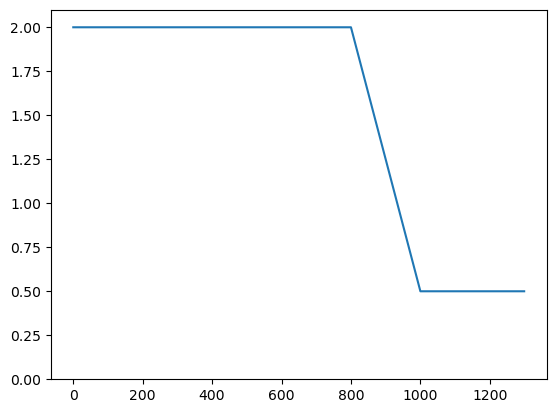

In [9]:
# check scheduler implementation

scheduler = Scheduler(1.0, 2, 0.5, 200, 800)
get_epsilons = jax.vmap(jax.jit(scheduler.get_epsilon))
iters_arr = jnp.arange(0, 1300, 1)
plt.plot(iters_arr, get_epsilons(iters_arr))
plt.ylim(0, 2.1)
plt.show()

In [147]:
hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_39km.hdf5'
with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.1
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_39km.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [13]:
def make_grid(marginal, mask, big_mask, x_dim, y_dim):
    """
    Arguments
    week: the week whose marginal we wish to fill into the grid to be plotted
    marginal: the marginal from week "week"
    mask: the dynamic mask.
    big_mask: the mask used to eliminate oceans
    x_dim: number of columns of final grid
    y_dim: number of rows of the final grid

    Returns:
    A grid with all the densities of the weekly marginals filled in
    """
    medium_grid = np.zeros(mask.shape[0])
    medium_grid[mask] = marginal
    big_grid = np.empty(big_mask.shape[0])
    big_grid.fill(np.nan)
    big_grid[big_mask] = medium_grid
    return big_grid.reshape(y_dim, x_dim)

In [36]:
sinkhorn_solver = jit(linear.solve, static_argnames=['max_iterations', 'progress_fn'])

class Scheduler:
    @beartype(conf=BeartypeConf(strategy=(BeartypeStrategy.O0)))
    def __init__(self, target, init, decay, decay_after):
        self.target = target
        self.init = init
        self.decay = decay
        self.decay_after = decay_after
    
    def get_epsilon(self, it: Int[Array, ""]):
        """
        At training step it, get a value of epsilon
        """
        epsilon = self.init * self.target
        epsilon = jax.lax.cond(it > self.decay_after,
                     lambda t : jax.lax.cond(t - self.decay * (it - self.decay_after) > self.target, lambda s : t - self.decay * (it - self.decay_after), lambda s: self.target, None),
                     lambda t: t,
                     epsilon)  # linear decay   
        return epsilon

def w2_distance(mu: Float[Array, "n "], mu_true: Float[Array, "n "], distance_matrix: Float[Array, "n n"], epsilon: Union[Float[Array, ""], Any]):
    geom = Geometry(cost_matrix=distance_matrix, epsilon=epsilon)
    ot = sinkhorn_solver(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true, max_iterations=5000)
    return ot.reg_ot_cost

def loss_fn(theta: Float[Array, "n "], st_marginal: Float[Array, "n "], distance_matrix: Float[Array, "n n"], epsilon: Union[Float[Array, ""], Any]):
    mu = jax.nn.softmax(theta)
    return w2_distance(mu, st_marginal, distance_matrix, epsilon)

def logit_l2_loss(theta: Float[Array, "n "], marginal: Float[Array, "n "]):
    """
    l2 distance between logits and probability distribution
    """
    mu = jax.nn.softmax(theta)
    return jnp.sqrt(jnp.sum((mu - marginal)**2))

def learn_st_marginal(st_marginal: Float[Array, "n"], 
                      distance_matrix: Float[Array, "n n"], 
                      seed=42,
                      training_steps=500, 
                      epsilon: Union[float, Any]=None, 
                      tau: float=1.0, 
                      lr: float=1e-3, 
                      init_from_mu_true: bool=False, 
                      use_adam: bool=True, 
                      use_stabilization: bool=False, 
                      scheduler: Union[Scheduler, Any]=None,
                      loss_fn=loss_fn):
    
    solver = optax.adam(learning_rate=lr)
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    
    # if init_from_mu_true:  # initialize at the true marginal
    #     mu_true_logits = jnp.log(mu_true)
    #     theta_init = mu_true_logits
    # else:
    #     theta_init = jnp.zeros(shape=X.shape[0]) # uniform initialization

    # initialize parameter values
    theta_init = jnp.zeros(shape=st_marginal.shape[0]) # uniform initialization    
    
    # initialize solver
    theta = theta_init
    opt_state = solver.init(theta)
    
    # create loss function
    loss_fn = functools.partial(loss_fn, st_marginal=st_marginal, distance_matrix=distance_matrix)
    grad_loss_fn = jax.value_and_grad(loss_fn)
    
    @jax.jit
    def make_step_adam(theta, epsilon, opt_state):
        loss_val, grads = grad_loss_fn(theta, epsilon=epsilon)
        updates, opt_state = solver.update(grads, opt_state)
        theta = optax.apply_updates(theta, updates)
        return loss_val, theta, opt_state
    
    @jax.jit
    def make_step(theta, epsilon, opt_state):
        loss_val, grads = grad_loss_fn(theta, epsilon)
        theta = theta - lr * grads
        return loss_val, theta, None
    
    @jax.jit
    def make_step_stabilized(theta, epsilon, opt_state):
        loss_val, grads = grad_loss_fn(theta, epsilon)
        theta = theta - lr * grads
        
        # stabilize by subtracting max from theta
        theta = theta - jnp.max(theta) # softmax(X - c) = softmax(X) 
        
        return loss_val, theta, None
    
    if use_adam:
        make_step = make_step_adam
    if use_stabilization:
        make_step = make_step_stabilized
    
    w2_loss_vals = []
    l2_loss_vals = []
    thetas = {}
    if scheduler != None:
        get_epsilon = jax.jit(scheduler.get_epsilon)
    for step in tqdm(range(1, training_steps + 1), desc="Training Steps", unit="step"):
        if scheduler != None:
            epsilon = float(get_epsilon(step))
        loss_val, theta, opt_state = make_step(theta, epsilon, opt_state)
        if step % int(training_steps / 40) == 0:
            thetas[step] = theta
        w2_loss_vals.append(loss_val)
        l2_loss_val = logit_l2_loss(theta, st_marginal)
        l2_loss_vals.append(l2_loss_val)
        #print(f"iteration {step}, loss value {loss_val}, l2 loss: {l2_loss_val}")
    
    return theta, thetas, (w2_loss_vals, l2_loss_vals)

#### Experiment 1
2000 training steps

In [14]:
xs = jnp.arange(0, 5000, 1)
week = 0
eps_default = eps_defaults[week]
scheduler = Scheduler(eps_default * 0.01, 200, 9.352196e-06, 2000)
get_epsilon = jax.jit(scheduler.get_epsilon)
ys = [float(get_epsilon(x)) for x in xs]
plt.plot(xs, ys)
#plt.axvline(x = 2, color='red', linestyle='--')
plt.title("epsilon decay, ex 1")
plt.xlabel("iteration")
plt.show()

NameError: name 'eps_defaults' is not defined

In [145]:
experiment_pkl_path = '/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results/learn-st-marginal-week0.pkl'
with open(experiment_pkl_path, 'rb') as f:
    data = pickle.load(f)
learned = data['learned']
thetas = data['thetas']
w2_loss_vals = data['w2_loss_vals']
l2_loss_vals = data['l2_loss_vals']
week = 0
st_marginal = jnp.array(masked_densities[week])

# plot difference between learned / ground truth st at each step
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_st = jax.nn.softmax(theta)
    grid_learned = make_grid(learned_st, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(st_marginal, dynamic_masks[week], big_mask, ncol, nrow)
    diff_grid = jnp.abs(grid_learned - grid_true)
    pos = ax_list[i].imshow(diff_grid, cmap="plasma")
    ax_list[i].set_title(f"step {step}")
    # ax_list[i].colorbar(pos)
    
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results/learn-st-marginal-week0.pkl'

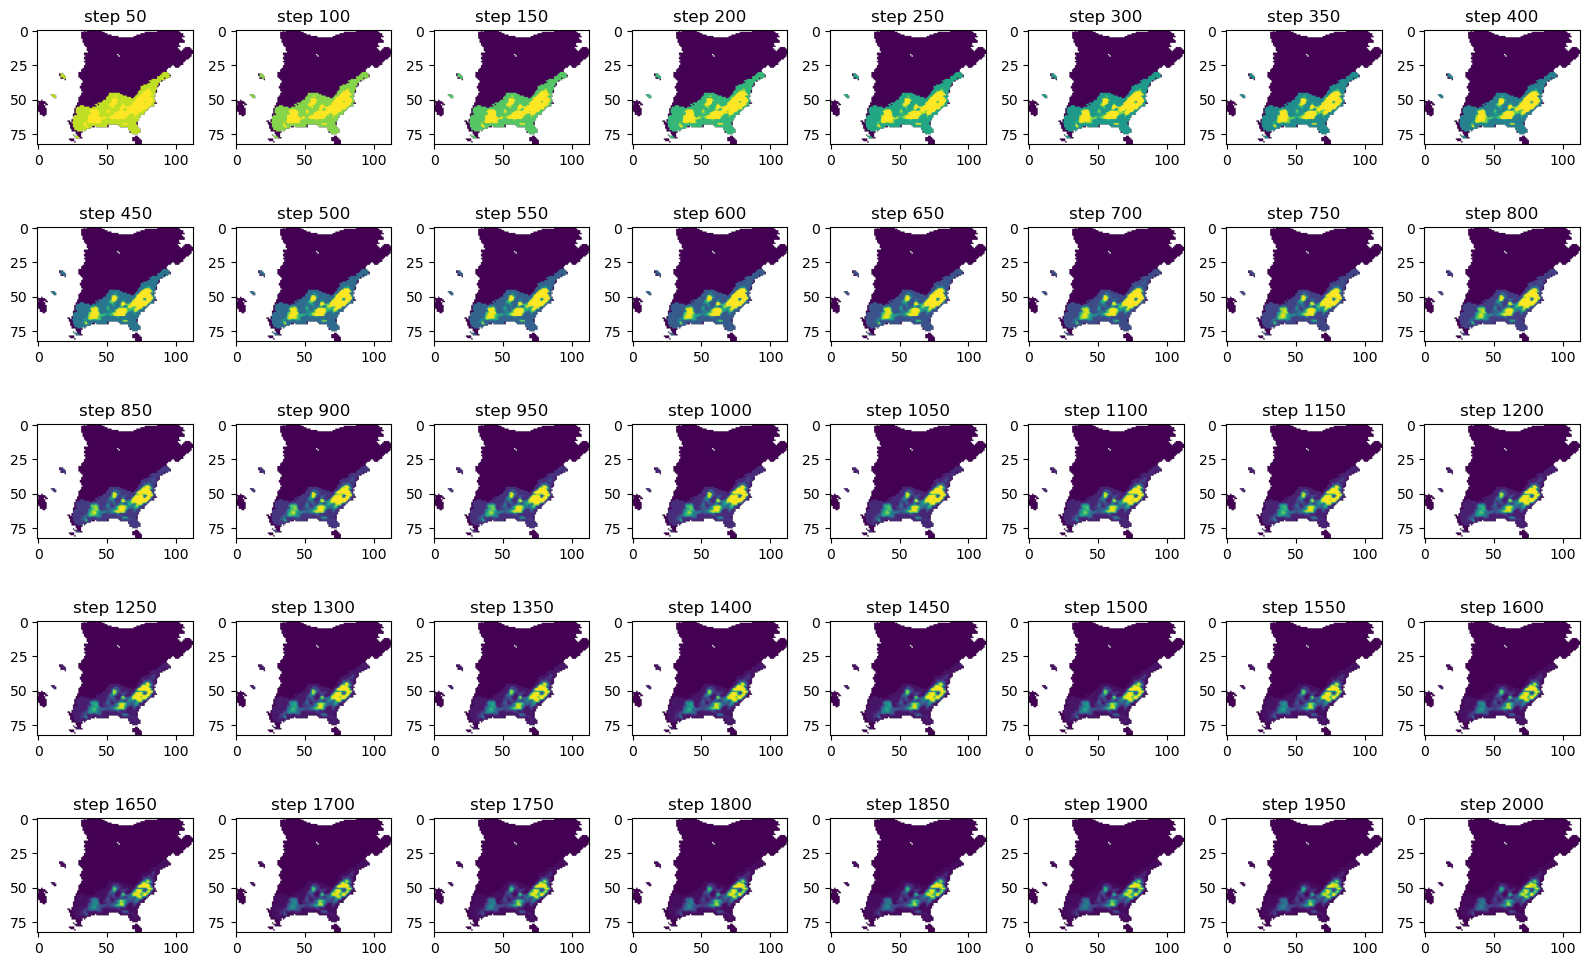

In [ ]:
# plot learned at each timestep
fig, axes = plt.subplots(5, 8, figsize=(16, 10))
ax_list = axes.flat
for i, (step, theta) in enumerate(thetas.items()):
    learned_st = jax.nn.softmax(theta)
    grid_learned = make_grid(learned_st, dynamic_masks[week], big_mask, ncol, nrow)
    # grid_true = make_grid(st_marginal, dynamic_masks[week], big_mask, ncol, nrow)
    # diff_grid = jnp.abs(grid_learned - grid_true)
    pos = ax_list[i].imshow(grid_learned, cmap="viridis")
    ax_list[i].set_title(f"step {step}")
    # ax_list[i].colorbar(pos)
    
plt.tight_layout()
plt.show()

In [146]:
# plot ground truth
grid_true = make_grid(st_marginal, dynamic_masks[week], big_mask, ncol, nrow)
# learned_st_marginal = jax.nn.softmax(learned)
# grid_learned = make_grid(learned_st_marginal, dynamic_masks[week], big_mask, ncol, nrow)

# grid_true_vals = grid_true.flatten()
# grid_true_vals = grid_true_vals[~np.isnan(grid_true_vals)]
# grid_learned_vals = grid_learned.flatten()
# grid_learned_vals = grid_learned_vals[~np.isnan(grid_learned_vals)]

# vmin = min(grid_true_vals.min(), grid_learned_vals.min())
# vmax = max(grid_true_vals.max(), grid_learned_vals.max())
# print(vmin, vmax)

plt.figure(1)
pos = plt.imshow(grid_true, cmap="viridis", vmin=vmin, vmax=vmax)
plt.colorbar(pos)
plt.title("ground truth")

# plt.figure(2)
# pos = plt.imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
# plt.colorbar(pos)
# plt.title("learned")

# plt.figure(3)
# diff_grid = jnp.abs(grid_true - grid_learned)
# pos = plt.imshow(diff_grid, cmap="plasma")
# plt.colorbar(pos)
# plt.title("difference between learned and ground truth")
plt.show()

NameError: name 'st_marginal' is not defined

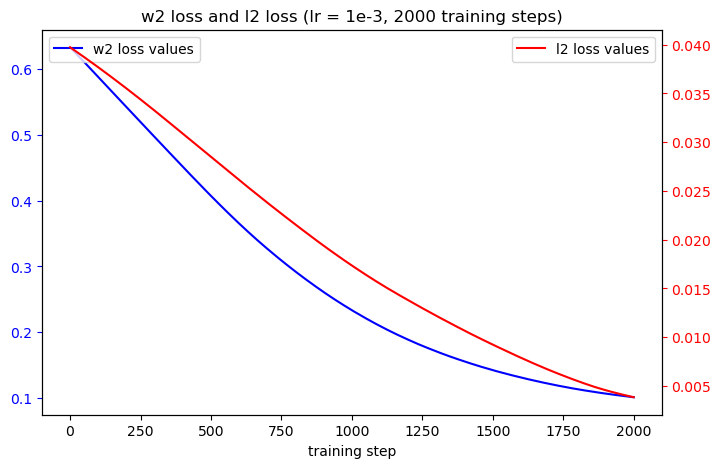

In [ ]:
# Create figure and first y-axis (left)
fig, ax_left = plt.subplots(figsize=(8, 5))
ax_left.plot(list(range(2000)), w2_loss_vals, 'b', label='w2 loss values')
#ax_left.set_ylabel("w2 loss value", color='b')
ax_left.tick_params(axis='y', colors='b')

# Create second y-axis (right)
ax_right = ax_left.twinx()  # Mirror y-axis on the right
ax_right.plot(list(range(2000)), l2_loss_vals, 'r', label='l2 loss values')  # Red dashed line for cos(x)
#ax_right.set_ylabel("l2 loss value", color='r')
ax_right.tick_params(axis='y', colors='r')

# Set labels and title
ax_left.set_xlabel(f"training step")
plt.title(f"w2 loss and l2 loss (lr = 1e-3, 2000 training steps)")

# Add legends
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")

# Show plot
plt.show()

#### Experiment 1.1
- Vary the `threshold` OTT parameter (tolerance for sinkhorn algorithm)

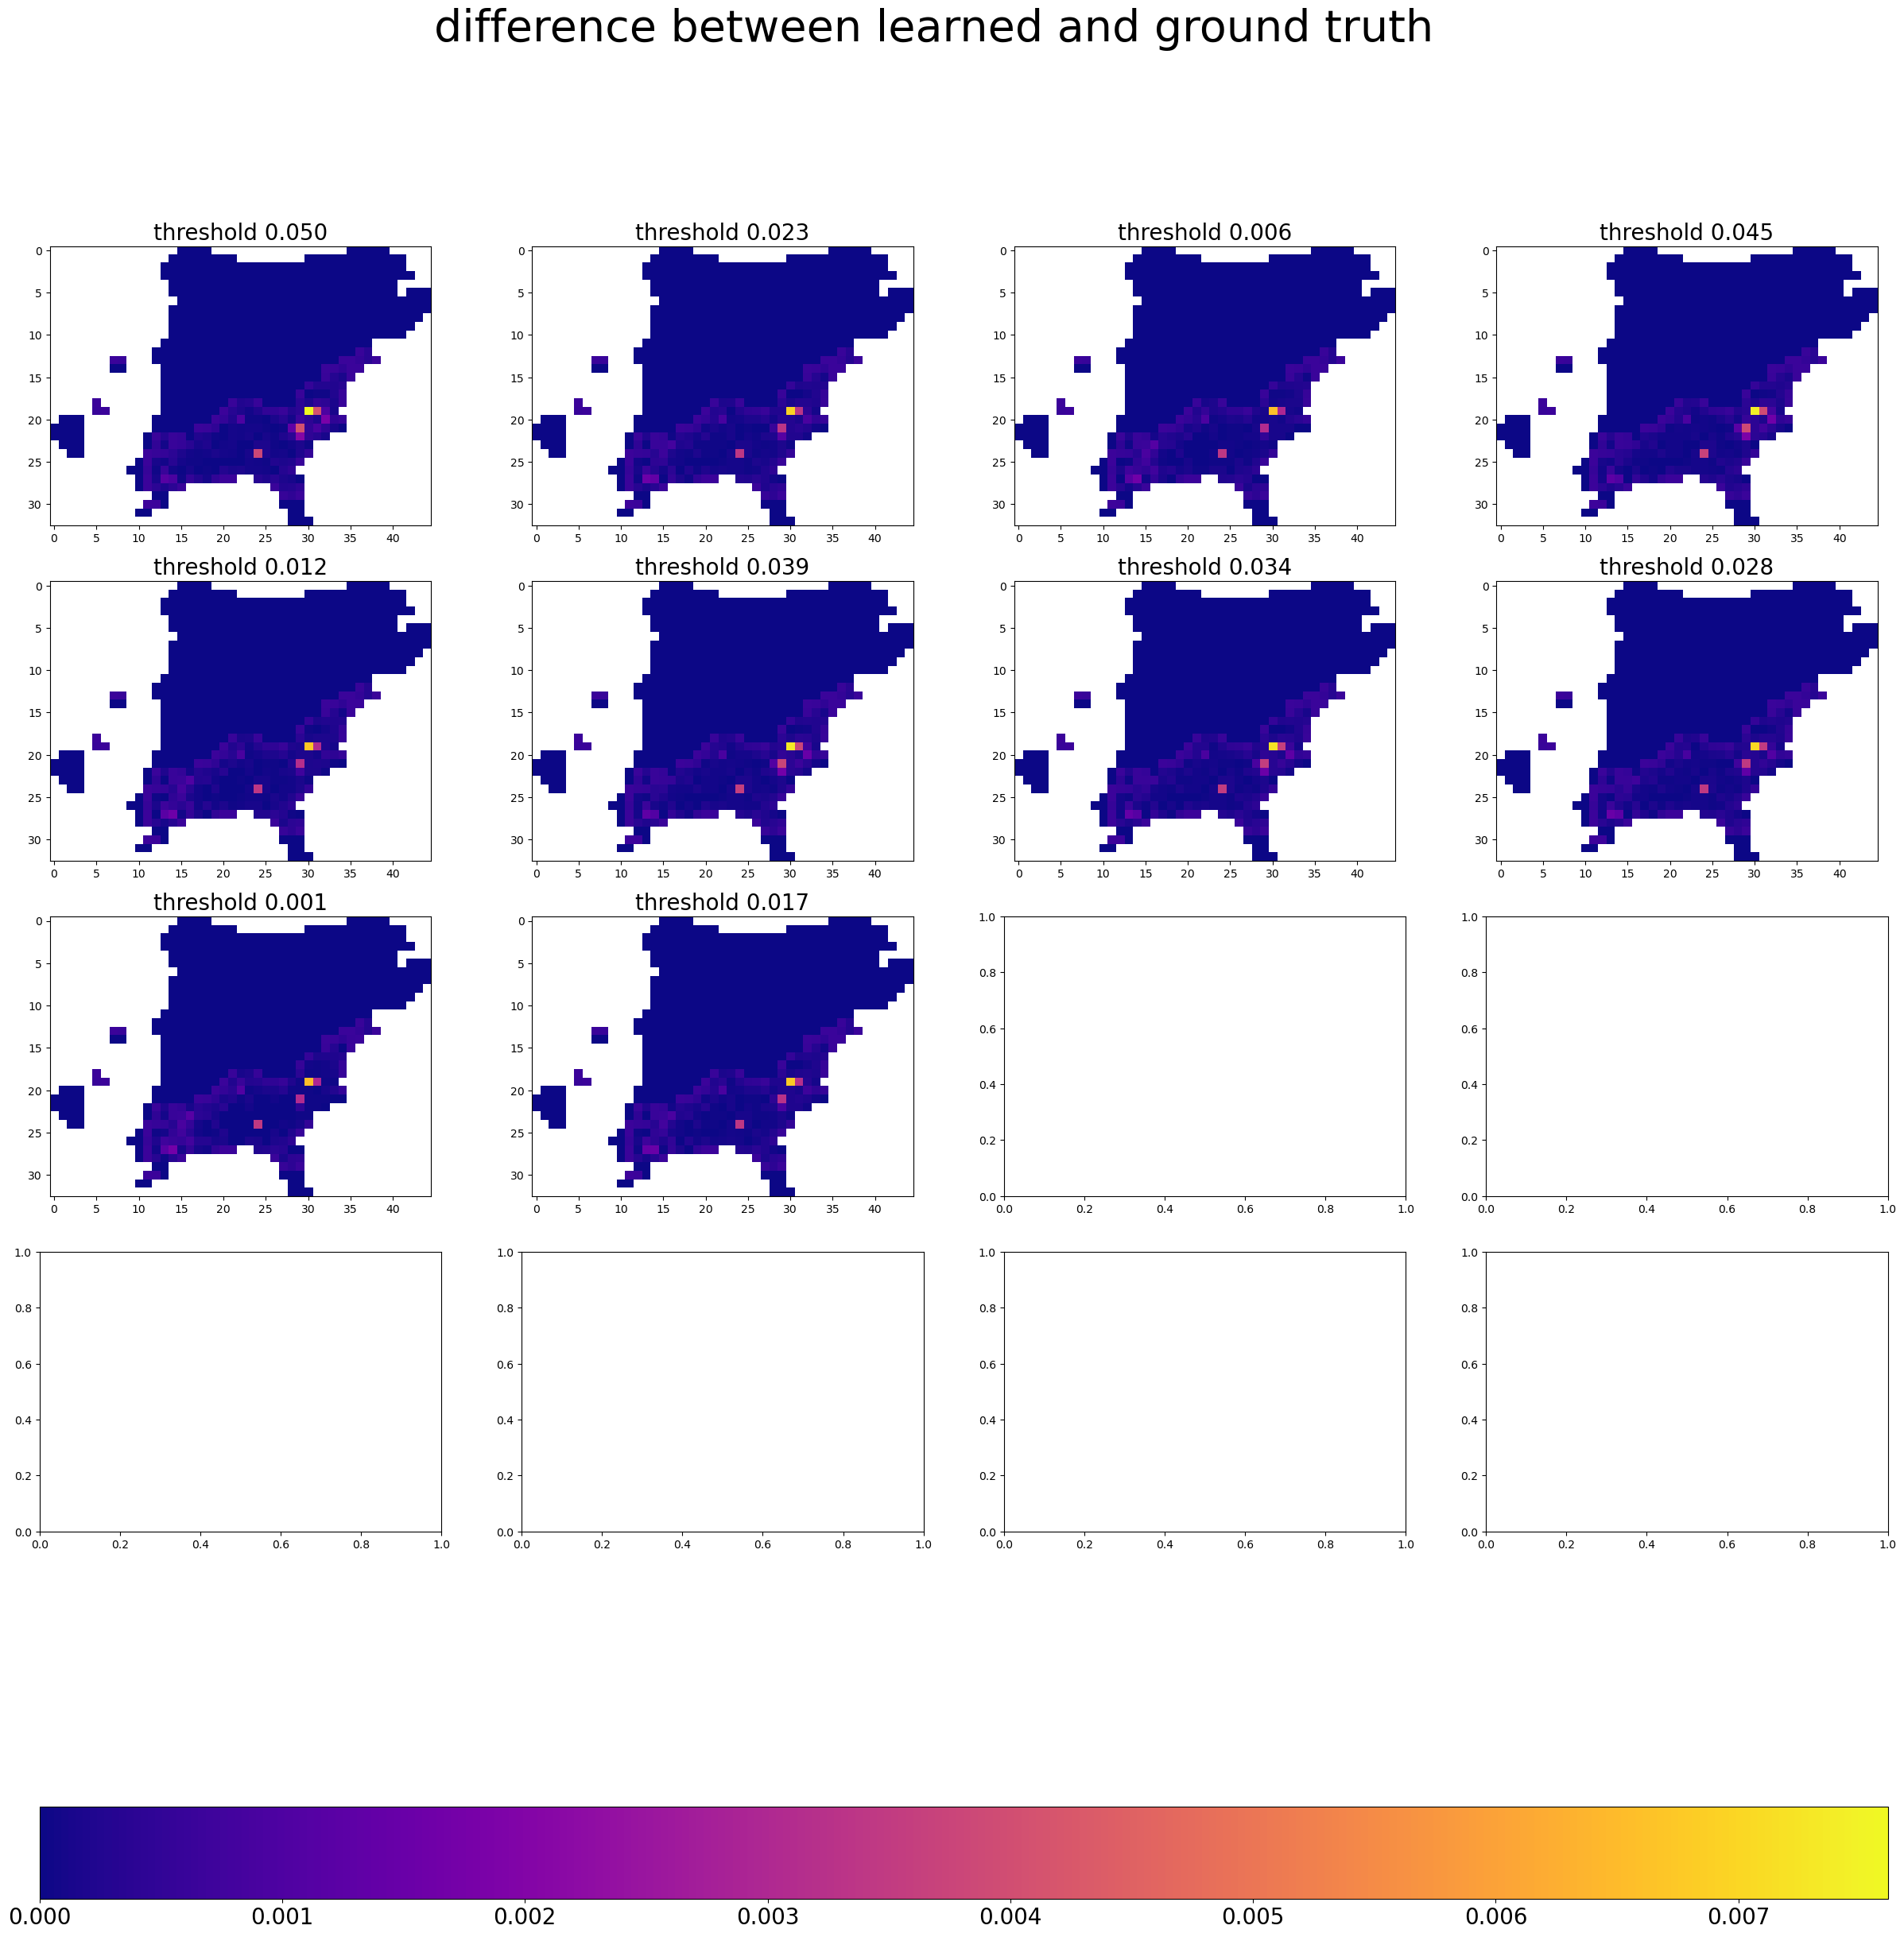

In [ ]:
hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.1
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)
    week = 0
    st_marginal = jnp.array(masked_densities[week])

experiment_dir = '/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results/st-marginals-compute'
experiment_files = os.listdir(experiment_dir)
experiment_results = []
for file in experiment_files:
    try:
        with open(os.path.join(experiment_dir, file), 'rb+') as f:
            experiment_results.append(pickle.load(f))
    except:
        continue

fig, axes = plt.subplots(4, 4, figsize=(30, 30))
ax_list = axes.flat

def map_result(result):
    learned = result['learned']
    marginal = jax.nn.softmax(learned)
    diff = jnp.abs(marginal - st_marginal)
    return diff.max()

vmax = max(list(map(map_result, experiment_results)))

for i, result in enumerate(experiment_results):
    grid_true = make_grid(st_marginal, dynamic_masks[week], big_mask, ncol, nrow)
    learned = result['learned']
    learned_st_marginal = jax.nn.softmax(learned)
    grid_learned = make_grid(learned_st_marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_true - grid_learned)
    pos = ax_list[i].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[i].set_title(f"threshold {result["threshold"]:.3f}", fontsize=20)
cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=40)
plt.show()

    

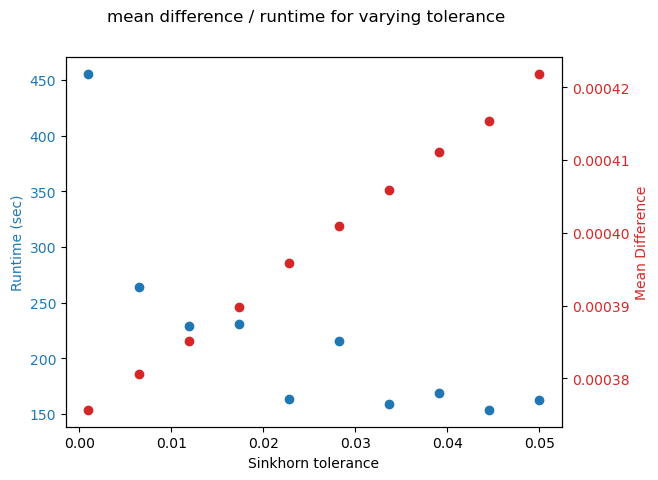

In [ ]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# Extract data
runtimes = [result['compute-time'] for result in experiment_results]
thresholds = [result['threshold'] for result in experiment_results]

# Compute mean differences
def map_result(result):
    learned = result['learned']
    marginal = jax.nn.softmax(learned)
    diff = jnp.abs(marginal - st_marginal)
    return diff.mean()

mean_diffs = list(map(map_result, experiment_results))

# Create figure and primary axis
fig, ax1 = plt.subplots()

# Plot runtime on primary y-axis
ax1.set_xlabel("Sinkhorn tolerance")
ax1.set_ylabel("Runtime (sec)", color="tab:blue")
ax1.scatter(thresholds, runtimes, color="tab:blue", label="Runtime")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Create secondary y-axis for mean differences
ax2 = ax1.twinx()
ax2.set_ylabel("Mean Difference", color="tab:red")
ax2.scatter(thresholds, mean_diffs, color="tab:red", label="Mean Difference")
ax2.tick_params(axis='y', labelcolor="tab:red")

# Add title
fig.suptitle("mean difference / runtime for varying tolerance")
plt.show()


## Training with the full model

### Experiment 1
- Markov chain
- 600 training steps
- Standard observation loss
- ew: 1e-4, dw: 1e-2, ow: 1, dp: 0.4

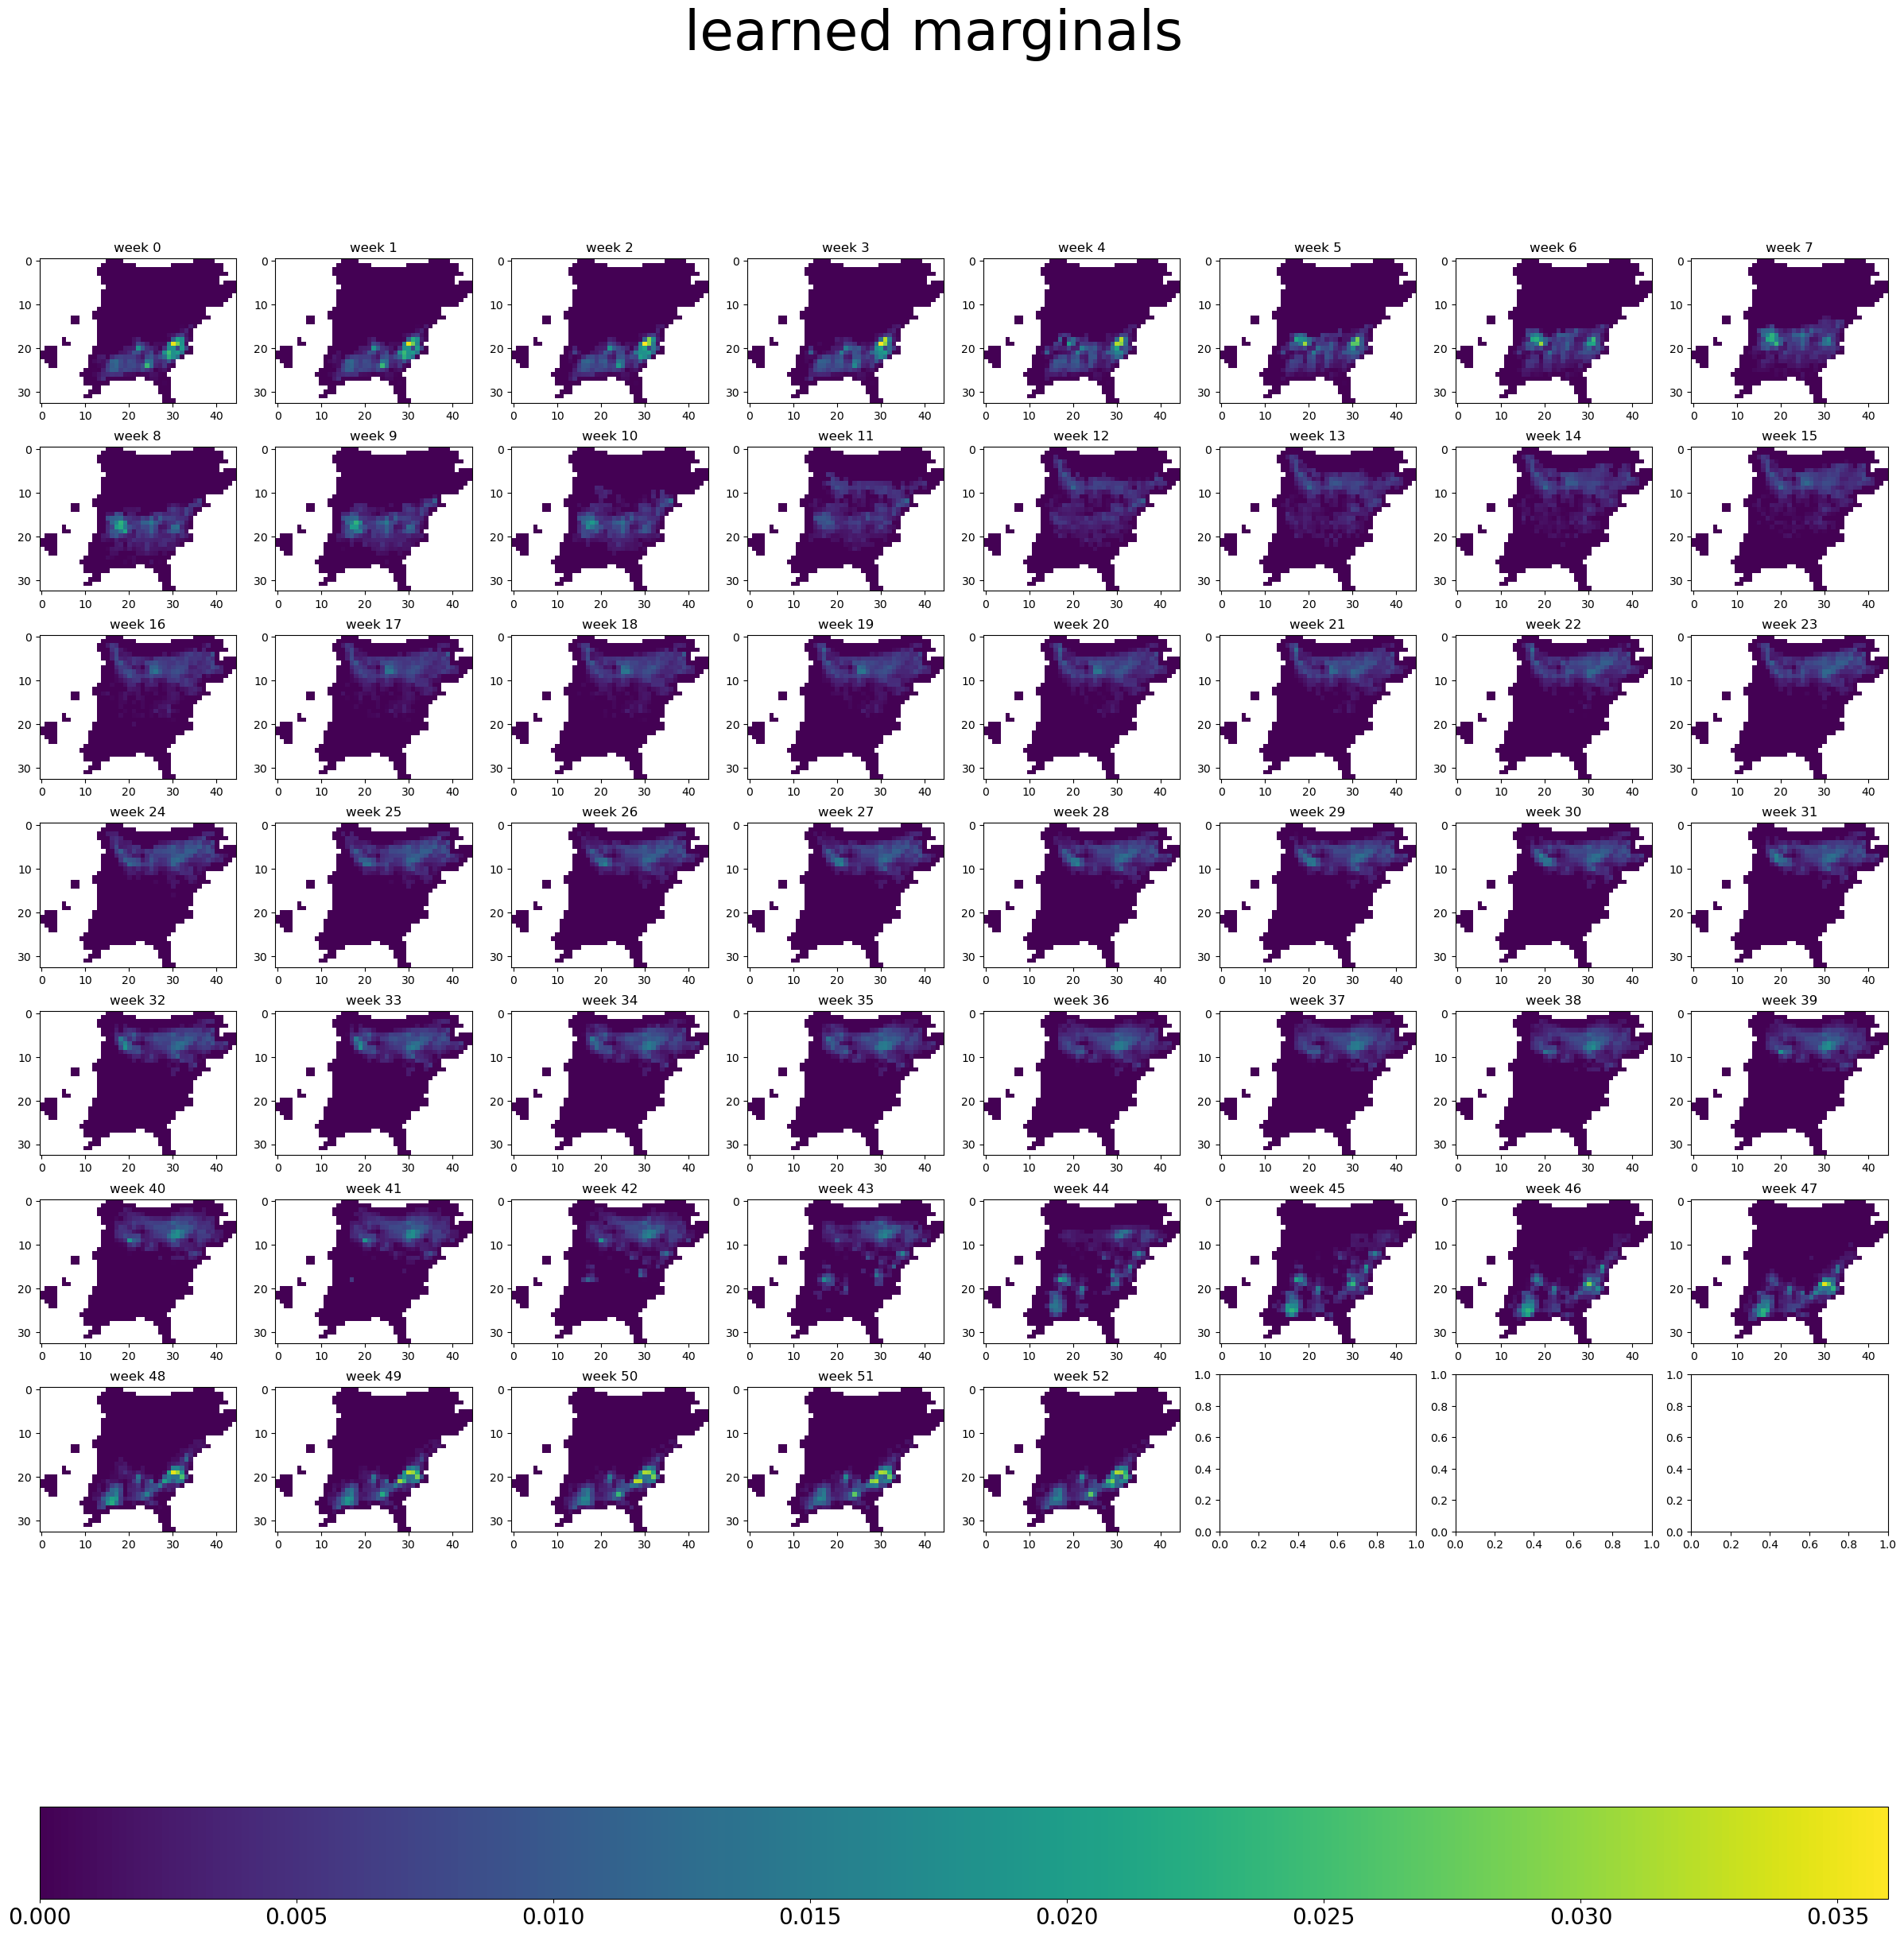

In [139]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'params_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

with open(os.path.join(experiment_dir, 'losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    loss_dict = pickle.load(f)

hdf_src = '/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(t_start, t_end):
        z = params[f'Flow_Model/Week_{week}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(7, 8, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in marginals])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()


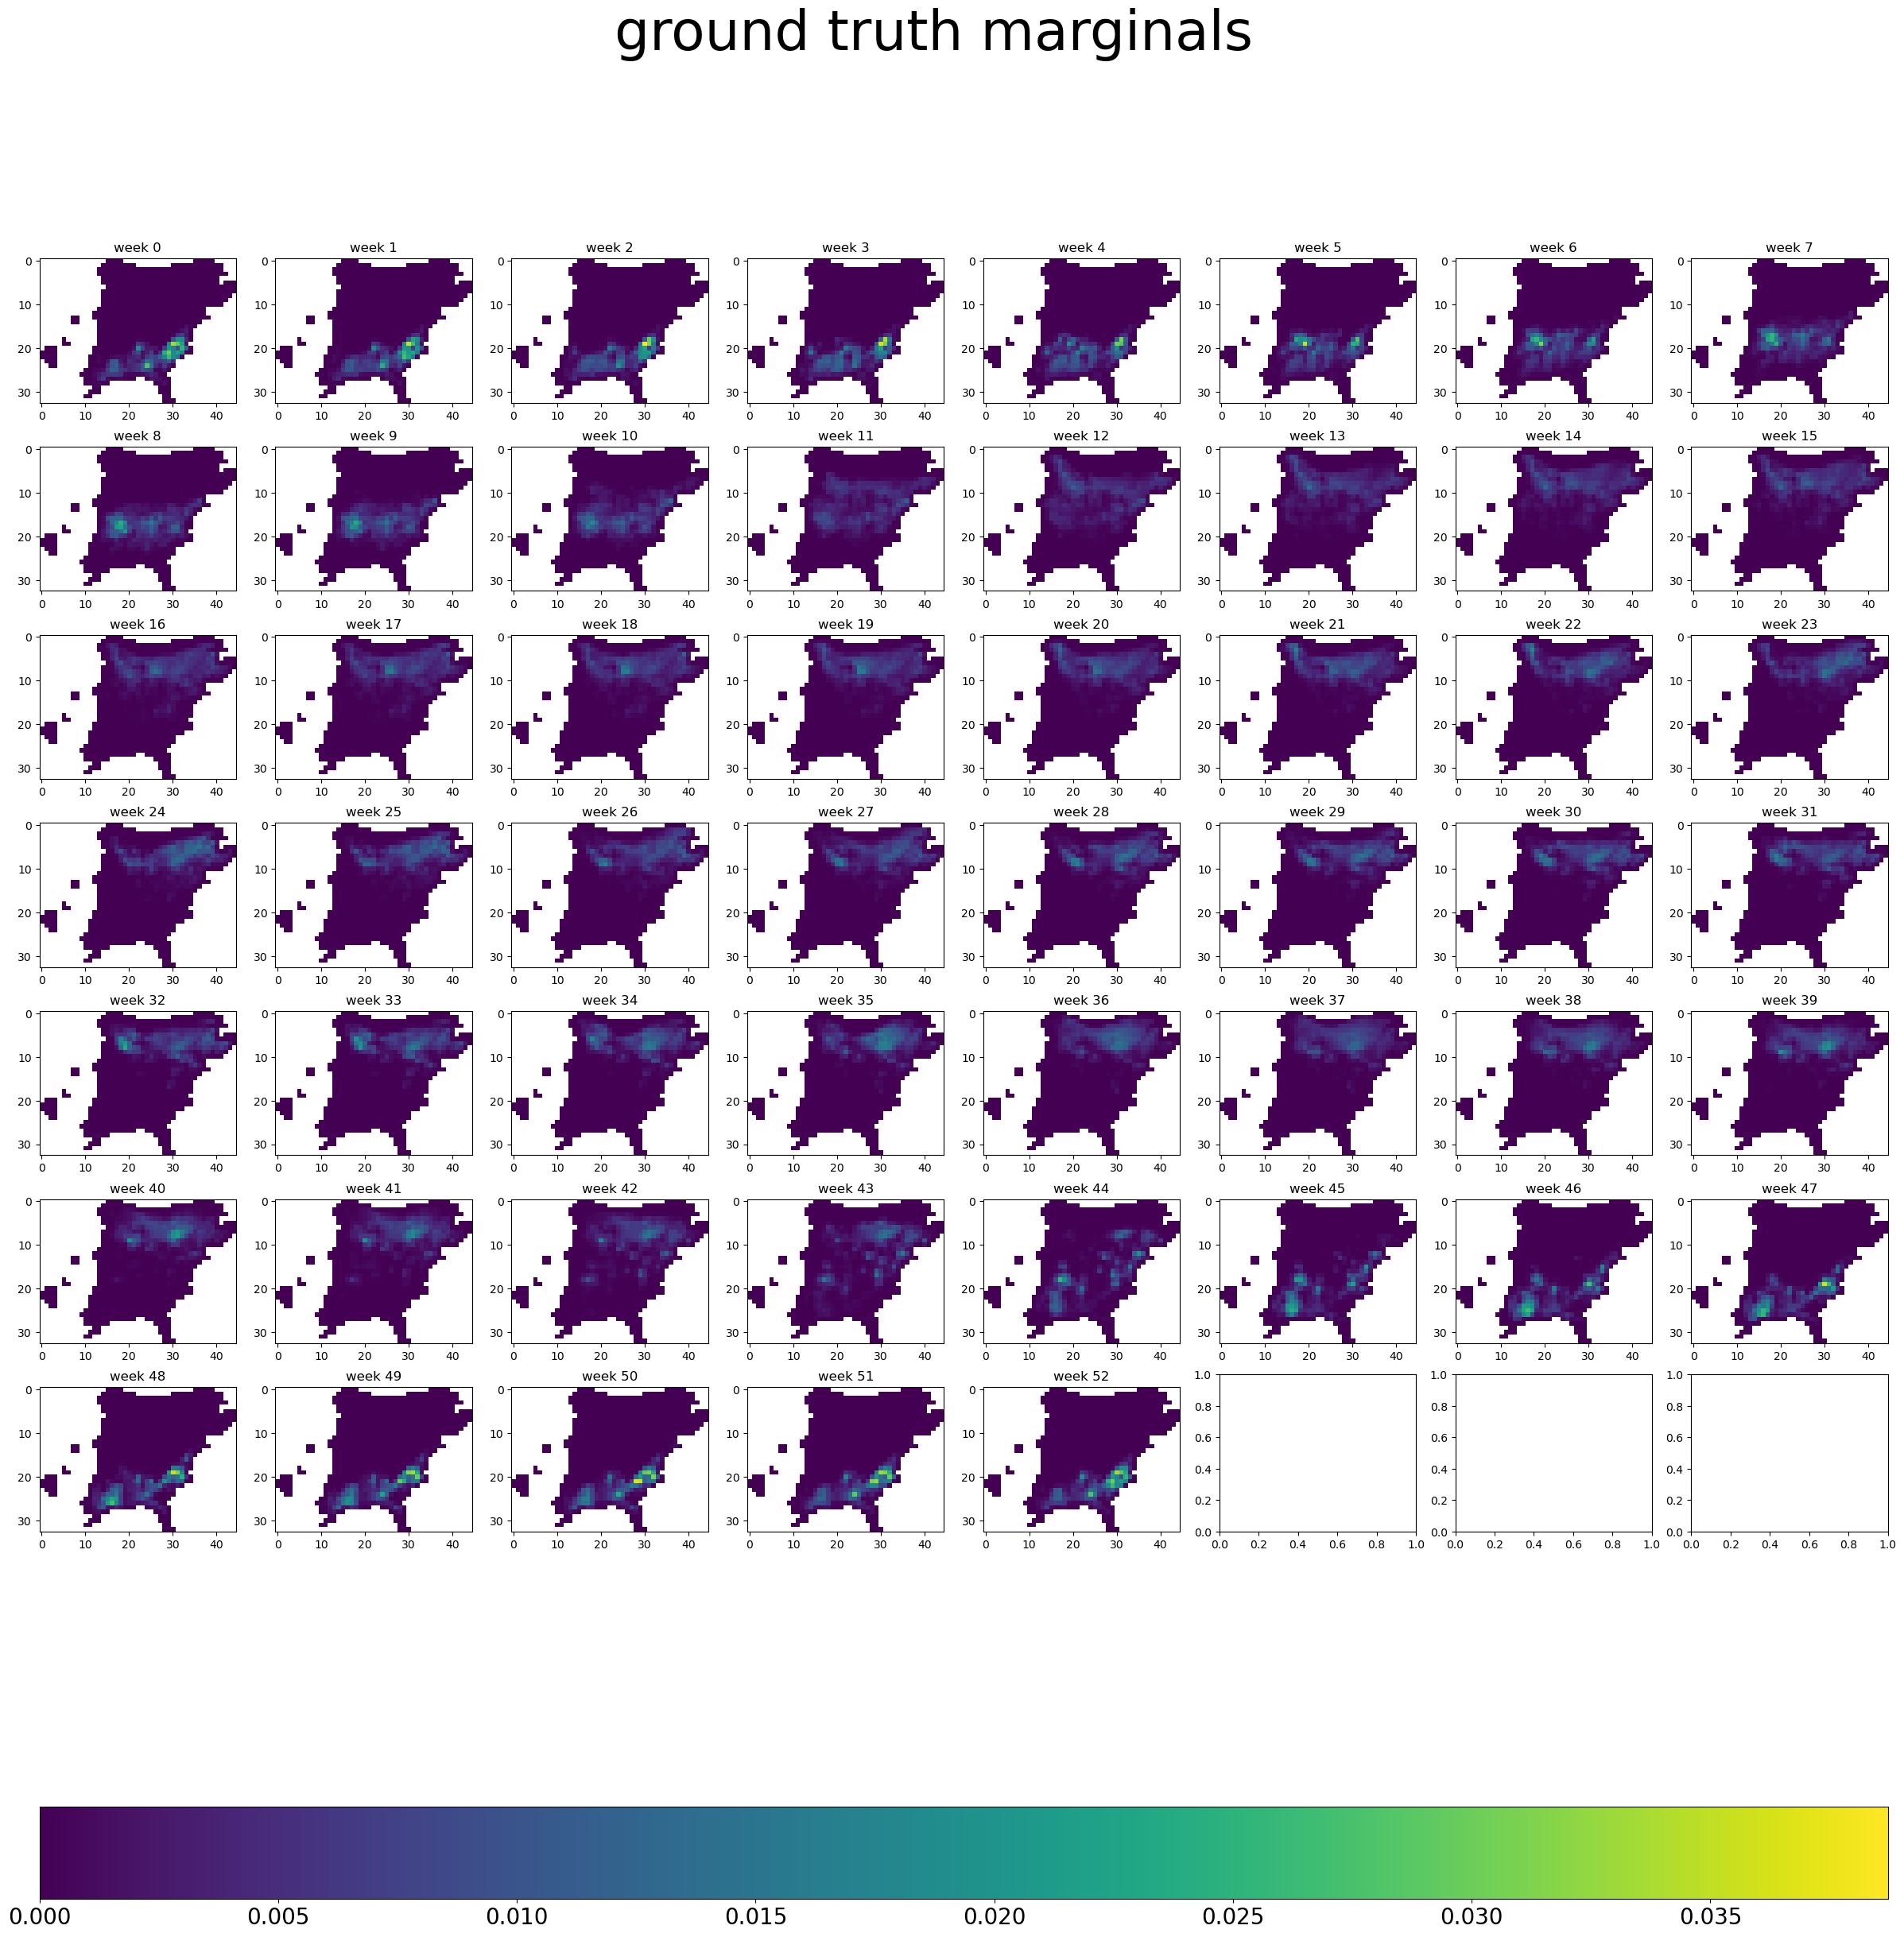

In [128]:
# plot ground truth at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(7, 8, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in masked_densities])
for week, marginal in enumerate(masked_densities):
    grid_true = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_true, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("ground truth marginals", fontsize=50)
plt.show()

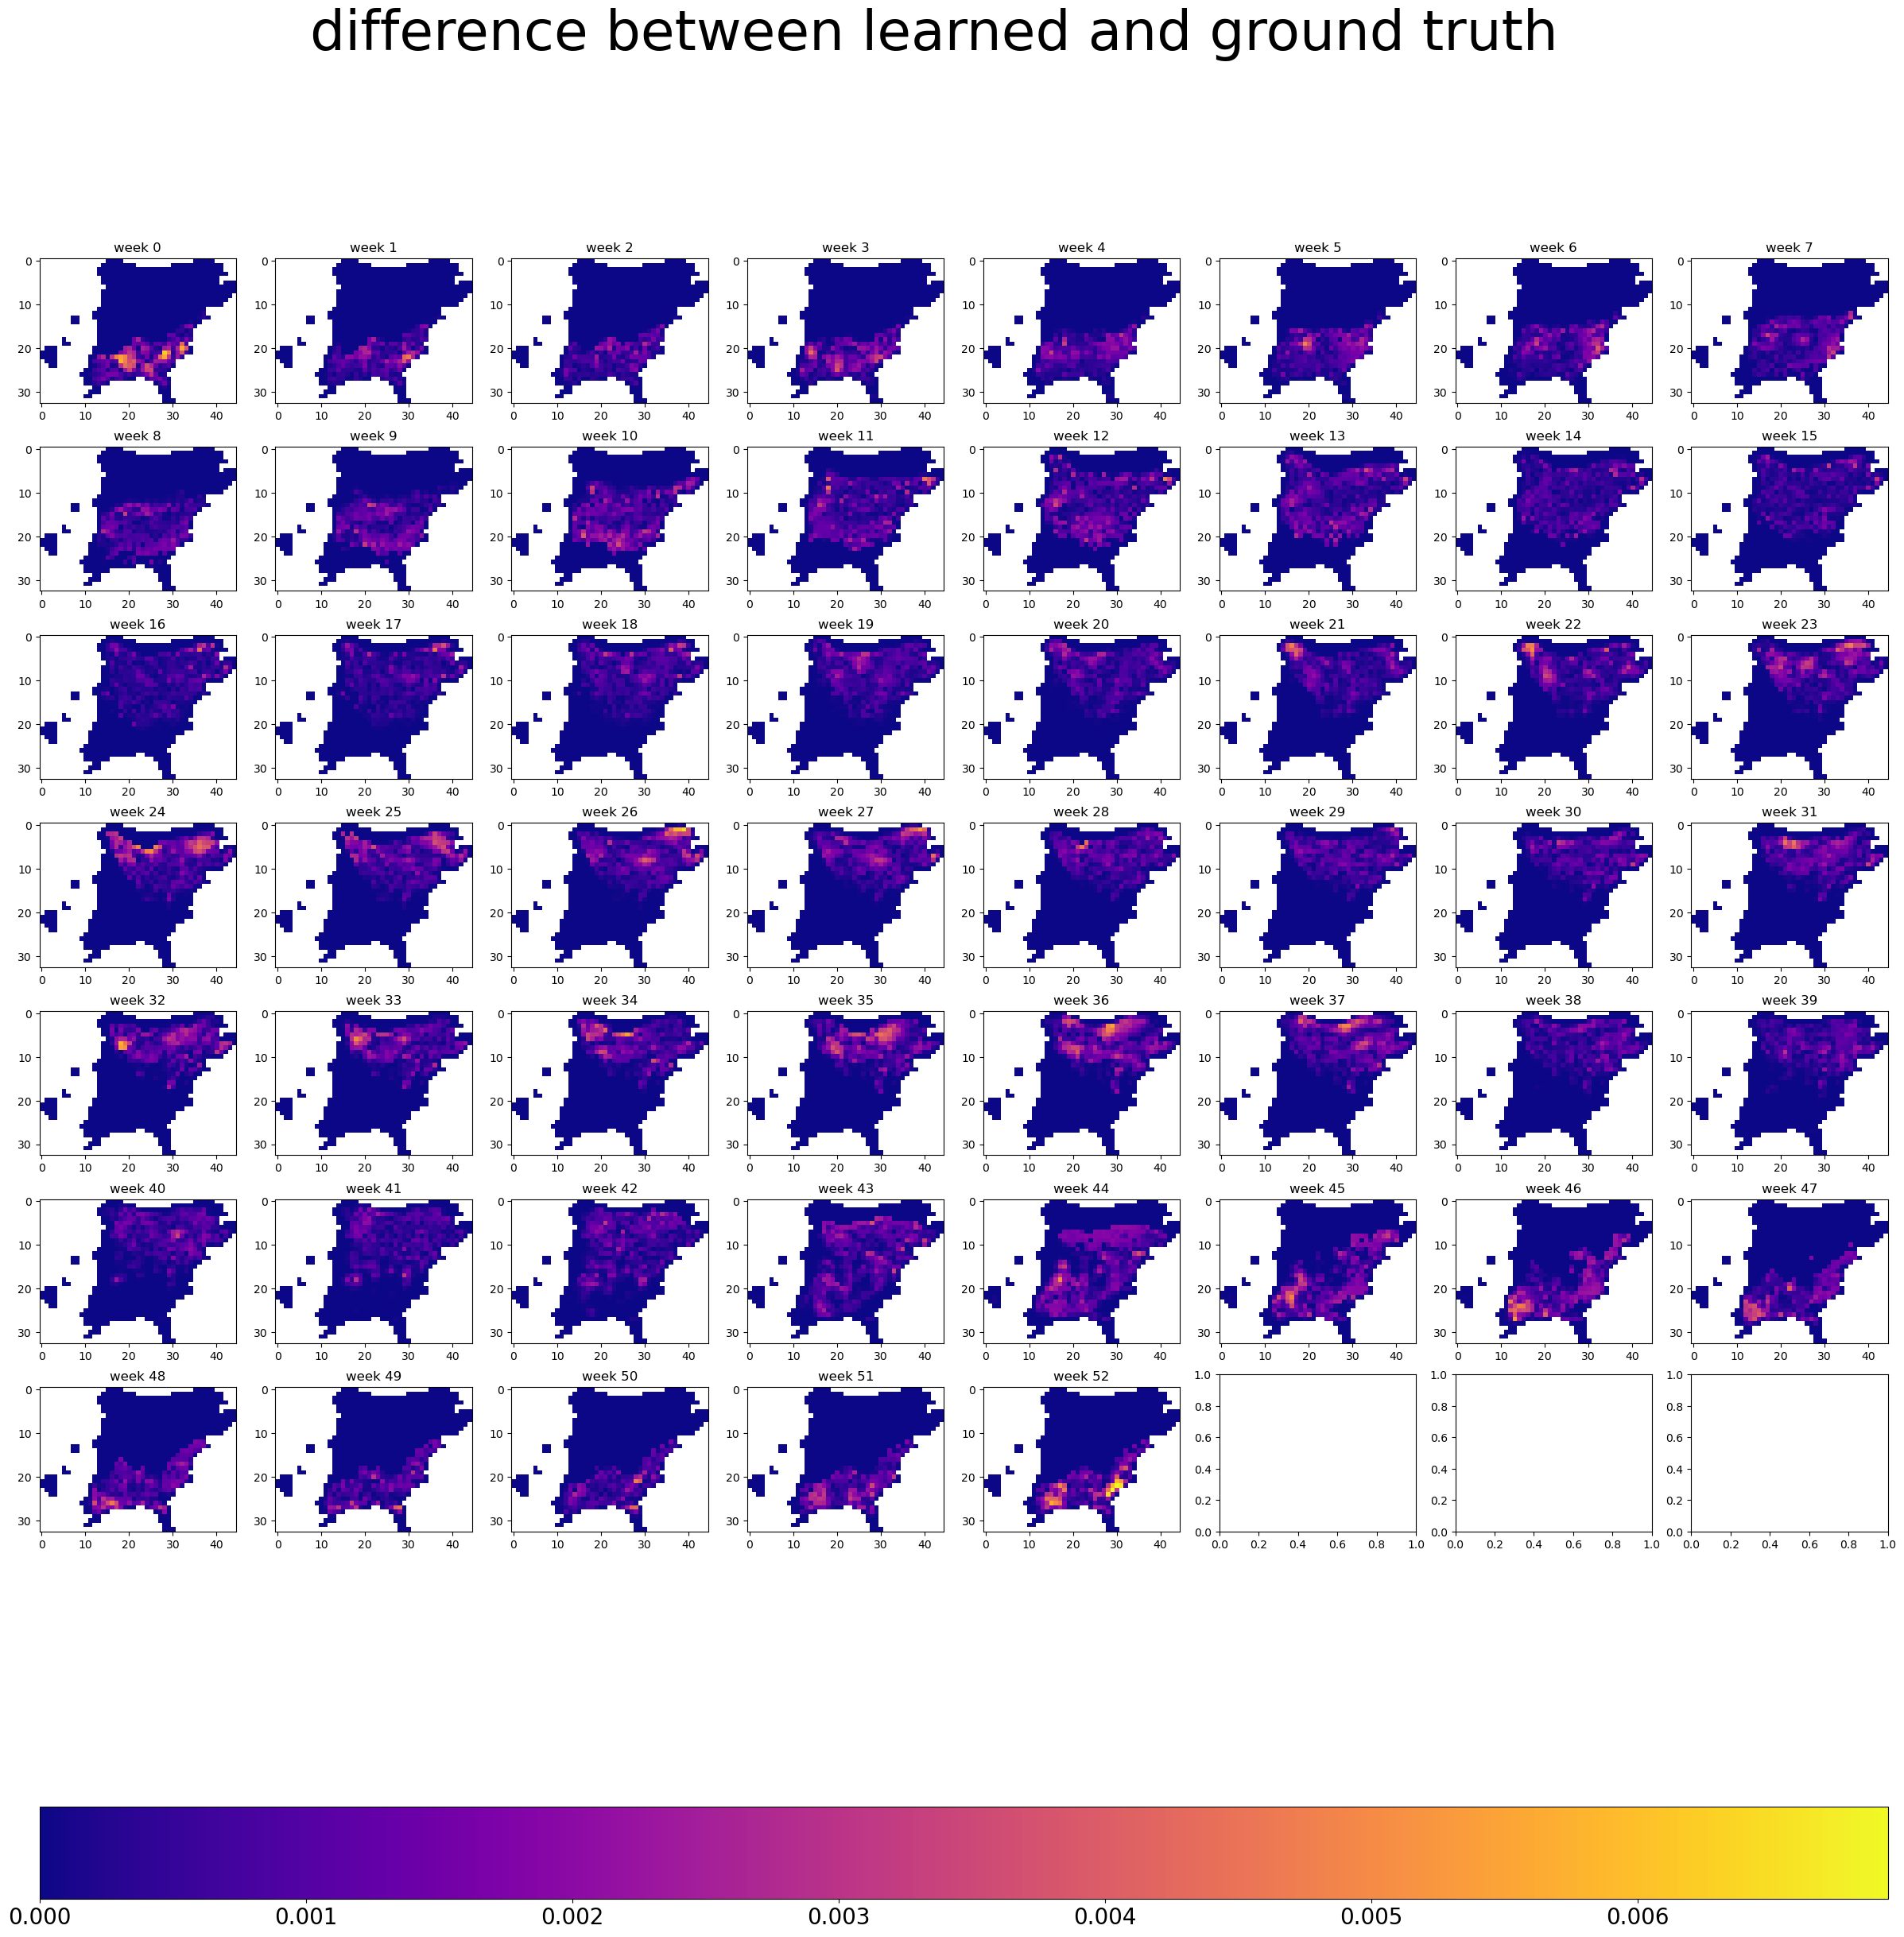

In [129]:
# plot difference between learned and ground truth for each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(7, 8, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, masked_densities)])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_learned - grid_true)
    pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=50)

plt.show()

26


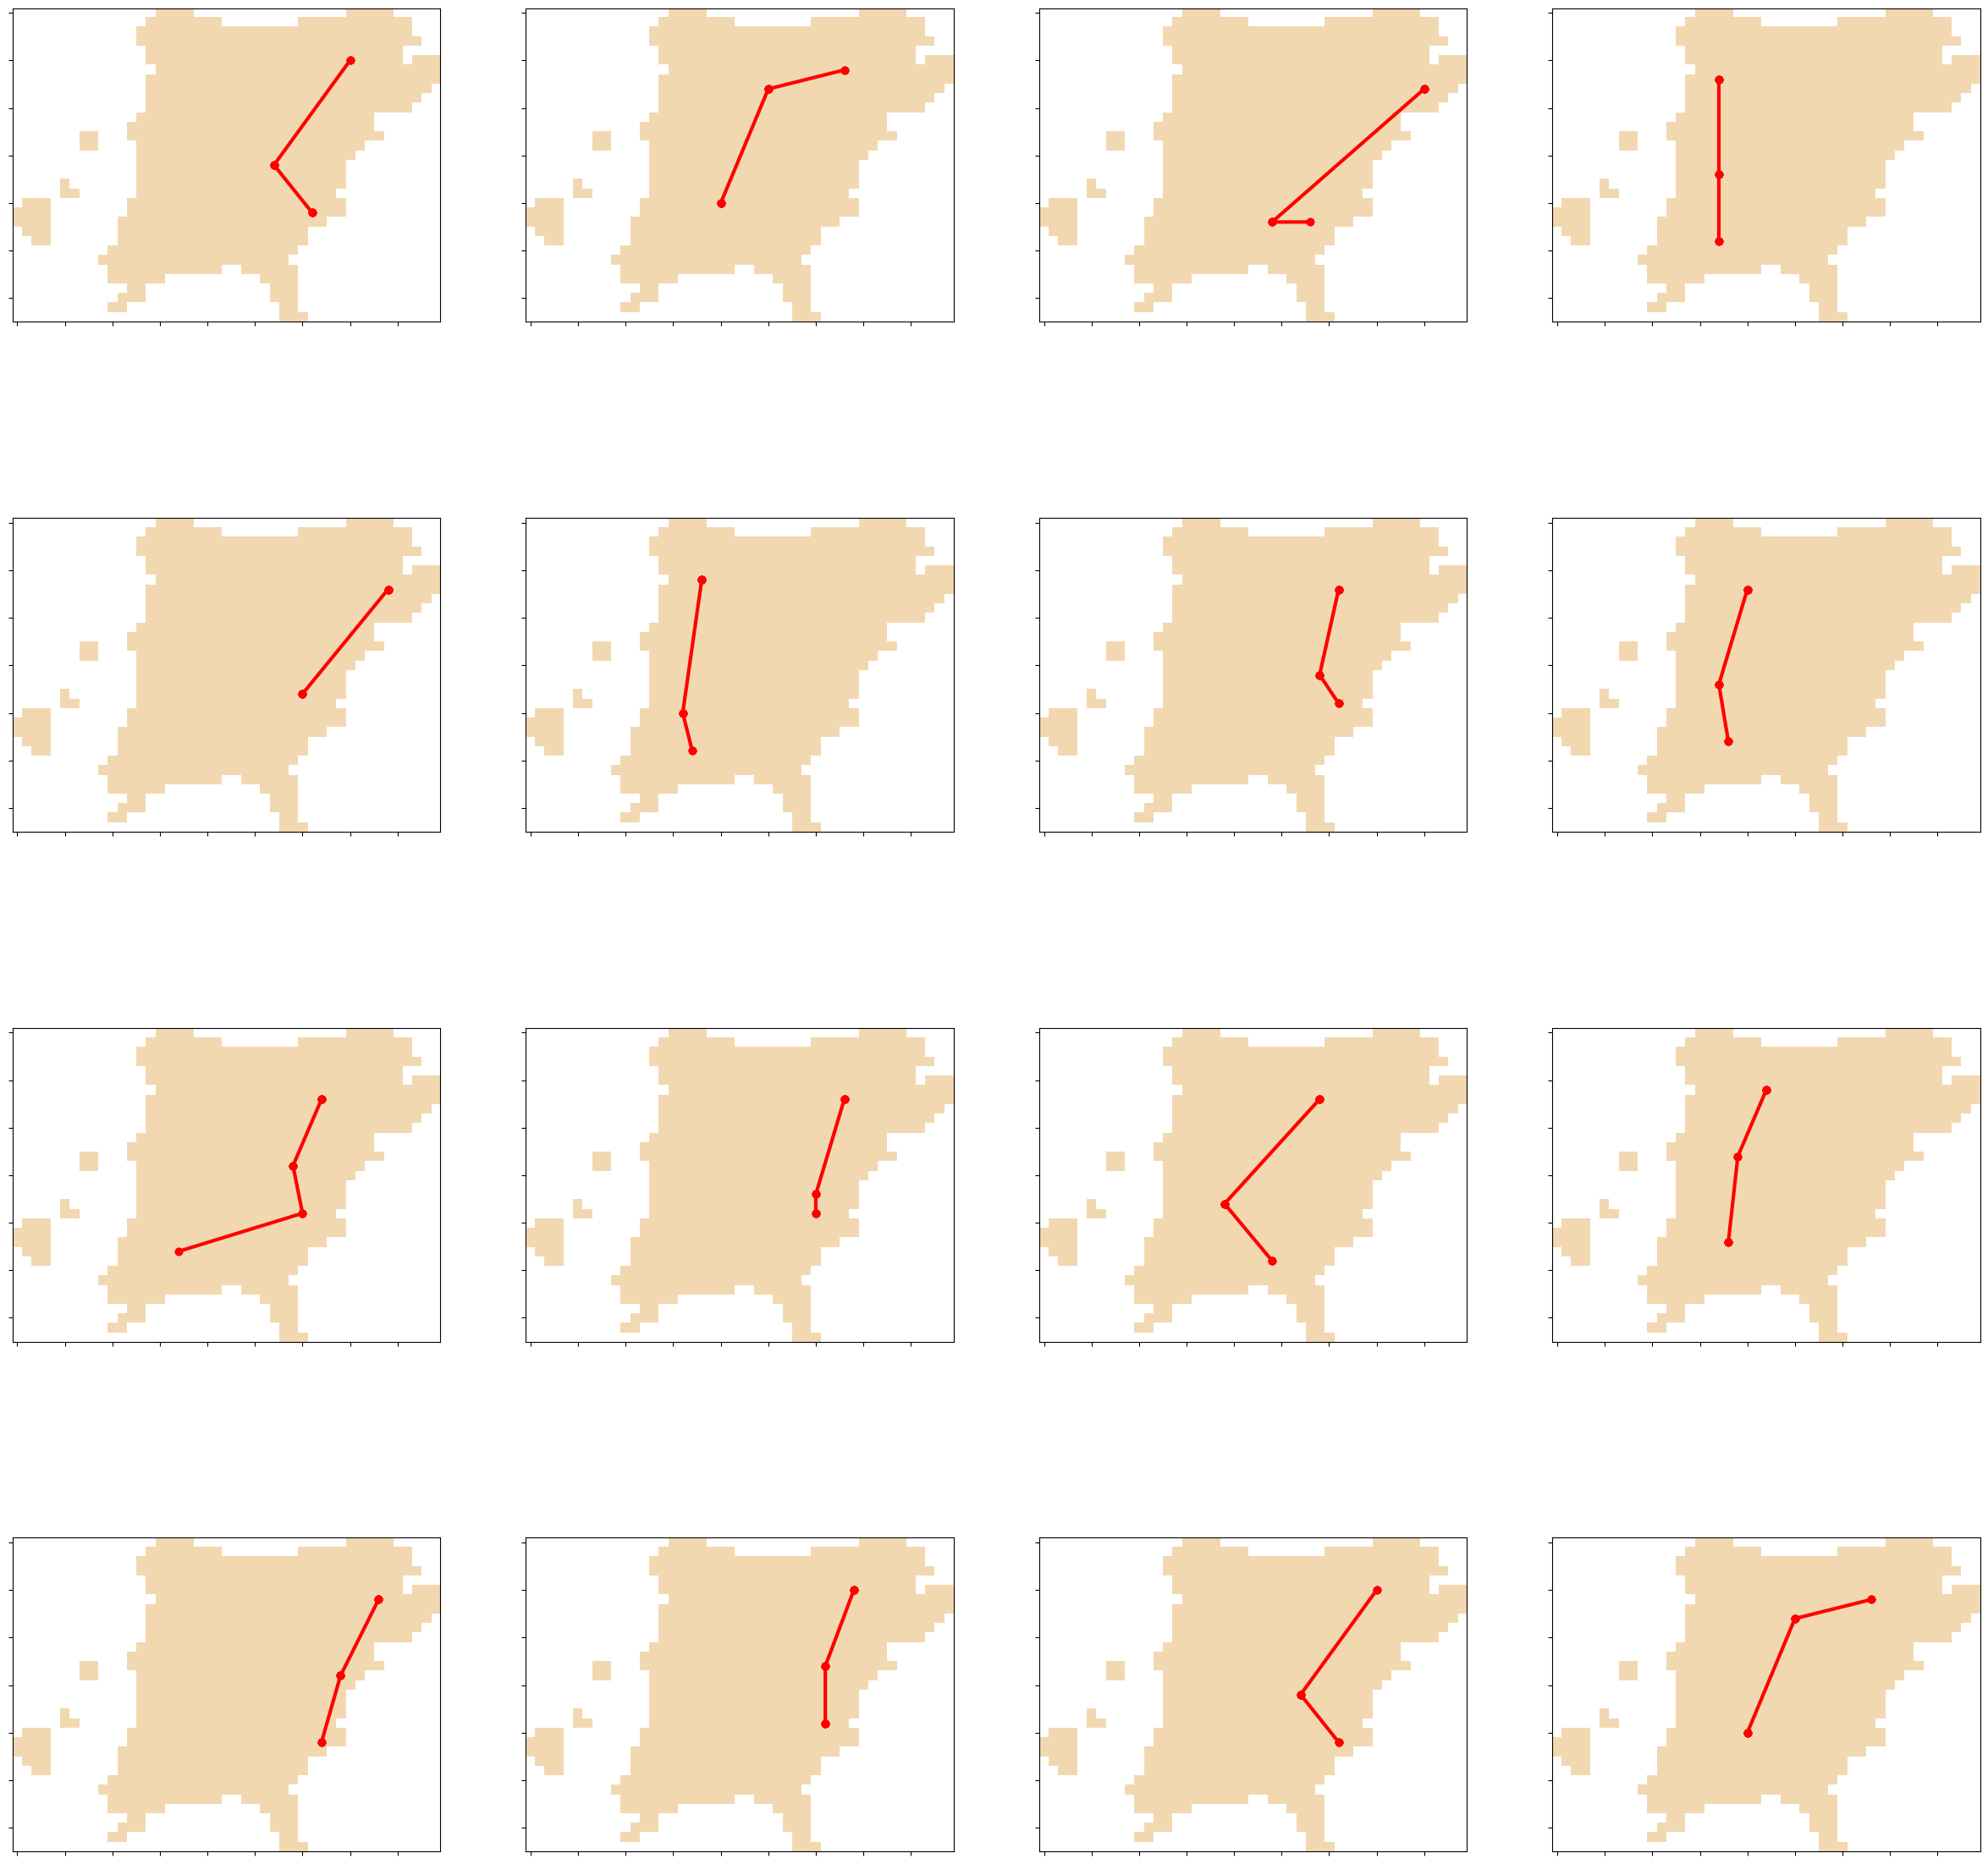

In [144]:
from flow_model import sample_trajectory
import matplotlib.colors as mcolors
import random

# plot sampled routes from the model
# rng sequence
def rng_sequence(seed):
    key = jax.random.PRNGKey(seed)
    while True:
        key, subkey = jax.random.split(key)
        yield subkey

trajectory = sample_trajectory(rng_sequence(90), params)[:26] # filter to just take first 26 weeks

# create big grid for land pixels
big_grid = jnp.zeros(big_mask.shape[0])
big_grid = big_grid.at[big_mask].set(1) # mask for the land pixels
big_grid = big_grid.reshape(nrow, ncol) # reshape into a square

# colormap for plotting land pixels
cmap = mcolors.ListedColormap(['white', '#f2d8b1'])  # 0 = water, 1 = land
bounds = [0, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# convert trajectory to get indices in the big grid
dynamic_masks_for_traj = dynamic_masks[:len(trajectory)]

print(len(trajectory))

def index_of_nth_occurrence(arr, value, n):
    """
    Returns index of nth occurence of value in arr
    """
    indices = jnp.where(arr == value)[0]
    if n - 1 >= len(indices) or n - 1 < 0:
        raise ValueError(f"{n}th occurrence of value {value} not found in array.")
    return indices[n-1]

def convert_trajectory(traj, dynamic_masks_for_traj, big_mask, nrow, ncol):
    # convert trajectory to coordinates in big grid
    traj_big_grid = [] # get points for the trajectory in flattened big grid
    for x, mask in zip(traj, dynamic_masks_for_traj):
        x_in_medium_grid = index_of_nth_occurrence(mask, True, x + 1) # use x + 1 since x is an index, not a count
        x_in_flattened_big_grid = index_of_nth_occurrence(big_mask, True, x_in_medium_grid + 1) # use x_in_medium_grid + 1 since x is an index, not a count
        x_in_big_grid = jnp.unravel_index(x_in_flattened_big_grid, (nrow, ncol))
        traj_big_grid.append(x_in_big_grid)
        # print(f"converted {x} to {x_in_medium_grid} to {x_in_flattened_big_grid} to {x_in_big_grid}")
    
    traj_big_grid = jnp.array(traj_big_grid)
    traj_coords_in_big_grid = traj_big_grid[:, [1, 0]] # swap columns to get plot coordinates

    return traj_coords_in_big_grid

def convert_to_coordinates_in_mask(cells, dynamic_mask, big_mask, nrow, ncol):
    cells_in_big_grid = [] # get points for the trajectory in flattened big grid
    for x in cells:
        x_in_medium_grid = index_of_nth_occurrence(dynamic_mask, True, x + 1) # use x + 1 since x is an index, not a count
        x_in_flattened_big_grid = index_of_nth_occurrence(big_mask, True, x_in_medium_grid + 1) # use x_in_medium_grid + 1 since x is an index, not a count
        x_in_big_grid = jnp.unravel_index(x_in_flattened_big_grid, (nrow, ncol))
        cells_in_big_grid.append(x_in_big_grid)
    
    # postprocess
    cells_in_big_grid = jnp.array(cells_in_big_grid)
    coords_in_big_grid = cells_in_big_grid[:, [1, 0]] # swap columns to get plot coordinates
    
    return coords_in_big_grid

# plot test marginal
# coords = convert_to_coordinates_in_mask(jnp.arange(337), dynamic_masks[25], big_mask, nrow, ncol)
# coords_x = coords[:, 0]
# coords_y = coords[:, 1]

# print(coords)
# print(coords_x)
# print(coords_y)
# plt.scatter(coords_x, coords_y, marker='o', color='red')
# plt.scatter([10], [10])

# plot 100 trajectories
num_trajectories = 16
fig, axes = plt.subplots(4, 4, figsize=(30, 30))
ax_list = axes.flat
for i in range(num_trajectories):
    # plot land pixels
    ax_list[i].imshow(big_grid, cmap=cmap, norm=norm)

    # sample trajectory
    seed = random.randint(0, 100)
    trajectory = sample_trajectory(rng_sequence(seed), params)

    # plot trajectory
    traj_in_big_grid = convert_trajectory(trajectory, dynamic_masks_for_traj, big_mask, nrow, ncol)
    traj_xs = traj_in_big_grid[:, 0]
    traj_ys = traj_in_big_grid[:, 1]
    ax_list[i].plot(traj_xs, traj_ys, marker='o', color='red', linewidth=3)
    ax_list[i].set_xticklabels([])
    ax_list[i].set_yticklabels([])
# plt.suptitle("standard model sampled trajectories", fontsize=50)
plt.show()

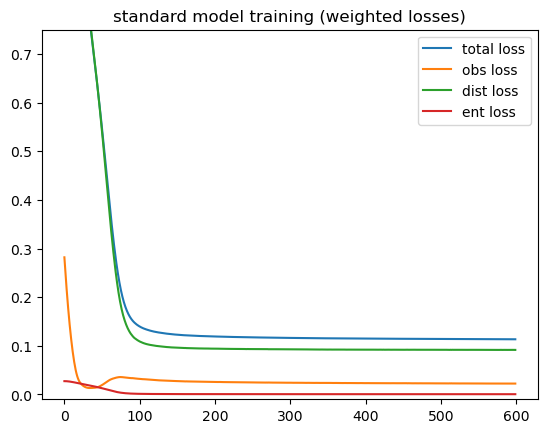

In [137]:
ent_weight = 1e-4
dist_weight = 1e-2
obs_weight = 1.0
num_iters = len(loss_dict['total'])
plt.plot(jnp.arange(num_iters), loss_dict['total'], label='total loss')
plt.plot(jnp.arange(num_iters), loss_dict['obs'], label='obs loss')
plt.plot(jnp.arange(num_iters), dist_weight * jnp.array(loss_dict['dist']), label='dist loss')
plt.plot(jnp.arange(num_iters), ent_weight * jnp.array(loss_dict['ent']), label='ent loss')
plt.legend()
plt.title("standard model training (weighted losses)")
plt.ylim(-0.01, 0.75)
plt.show()

### Experiment 2
- Markov chain
- 600 training steps
- Standard observation loss
- ew: 0, dw: 0, ow: 1, dp: 0.4

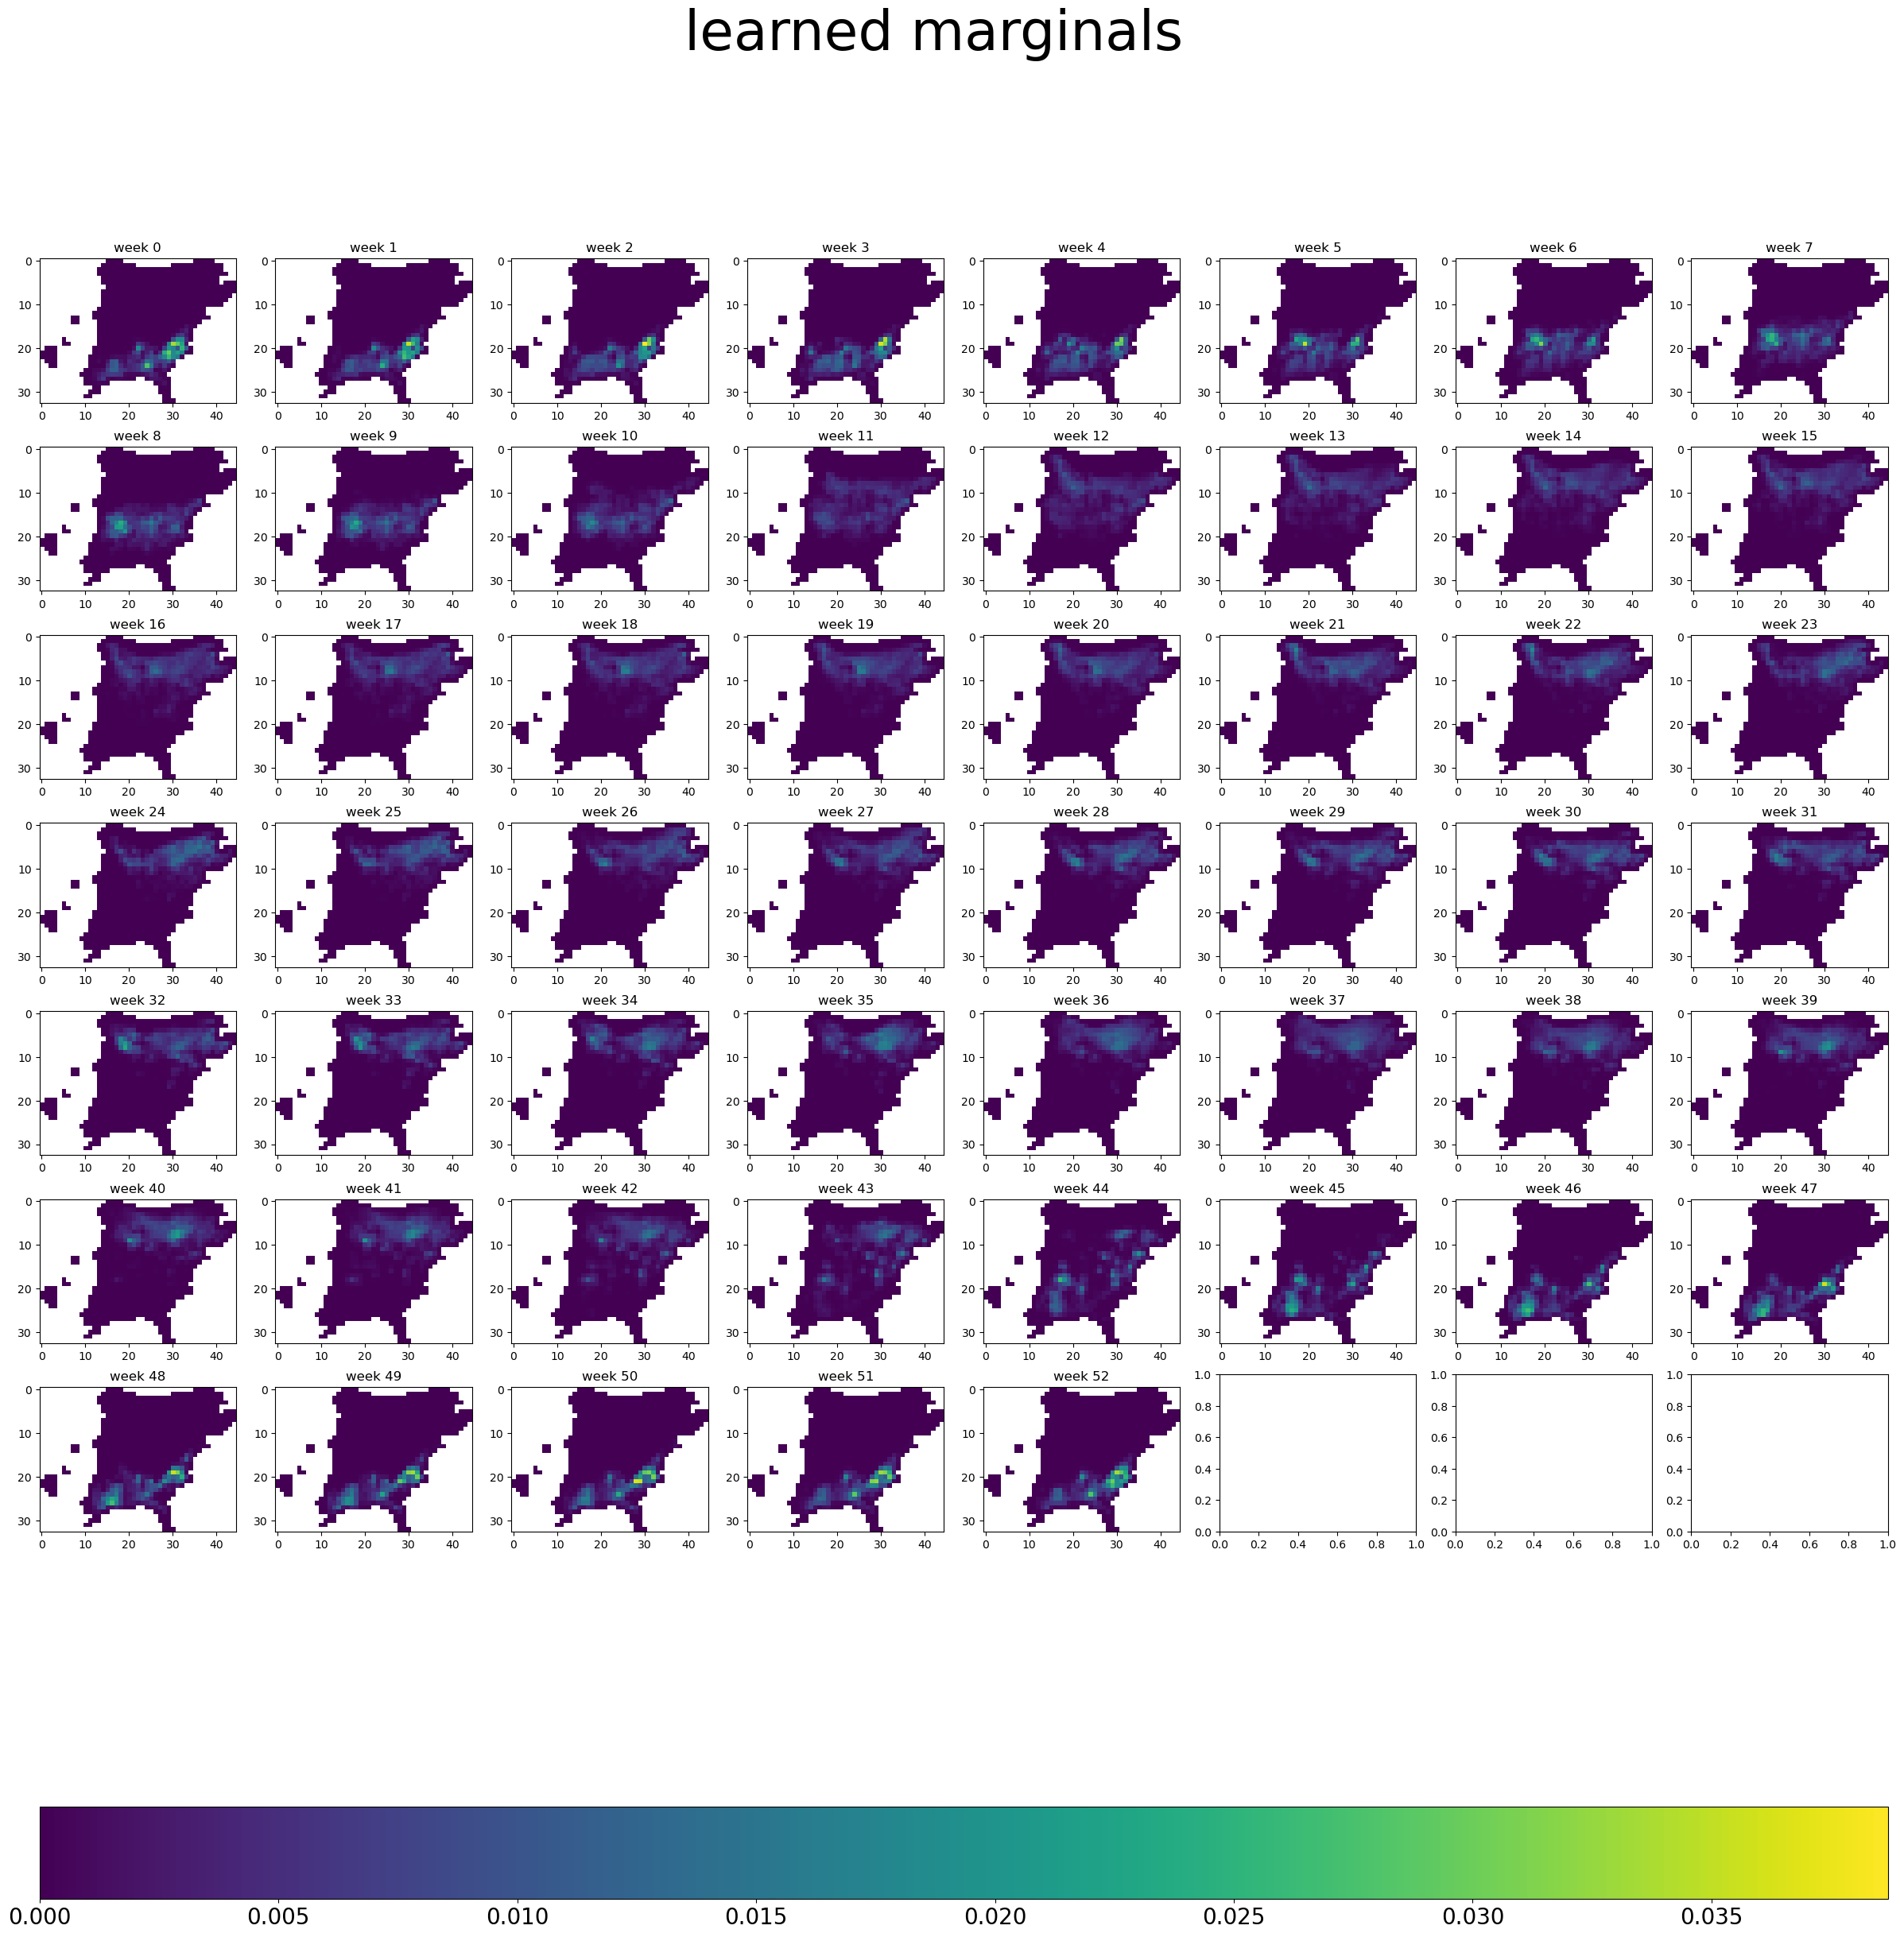

In [ ]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'params_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

with open(os.path.join(experiment_dir, 'losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    loss_dict = pickle.load(f)

hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(t_start, t_end):
        z = params[f'Flow_Model/Week_{week}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(7, 8, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in marginals])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()


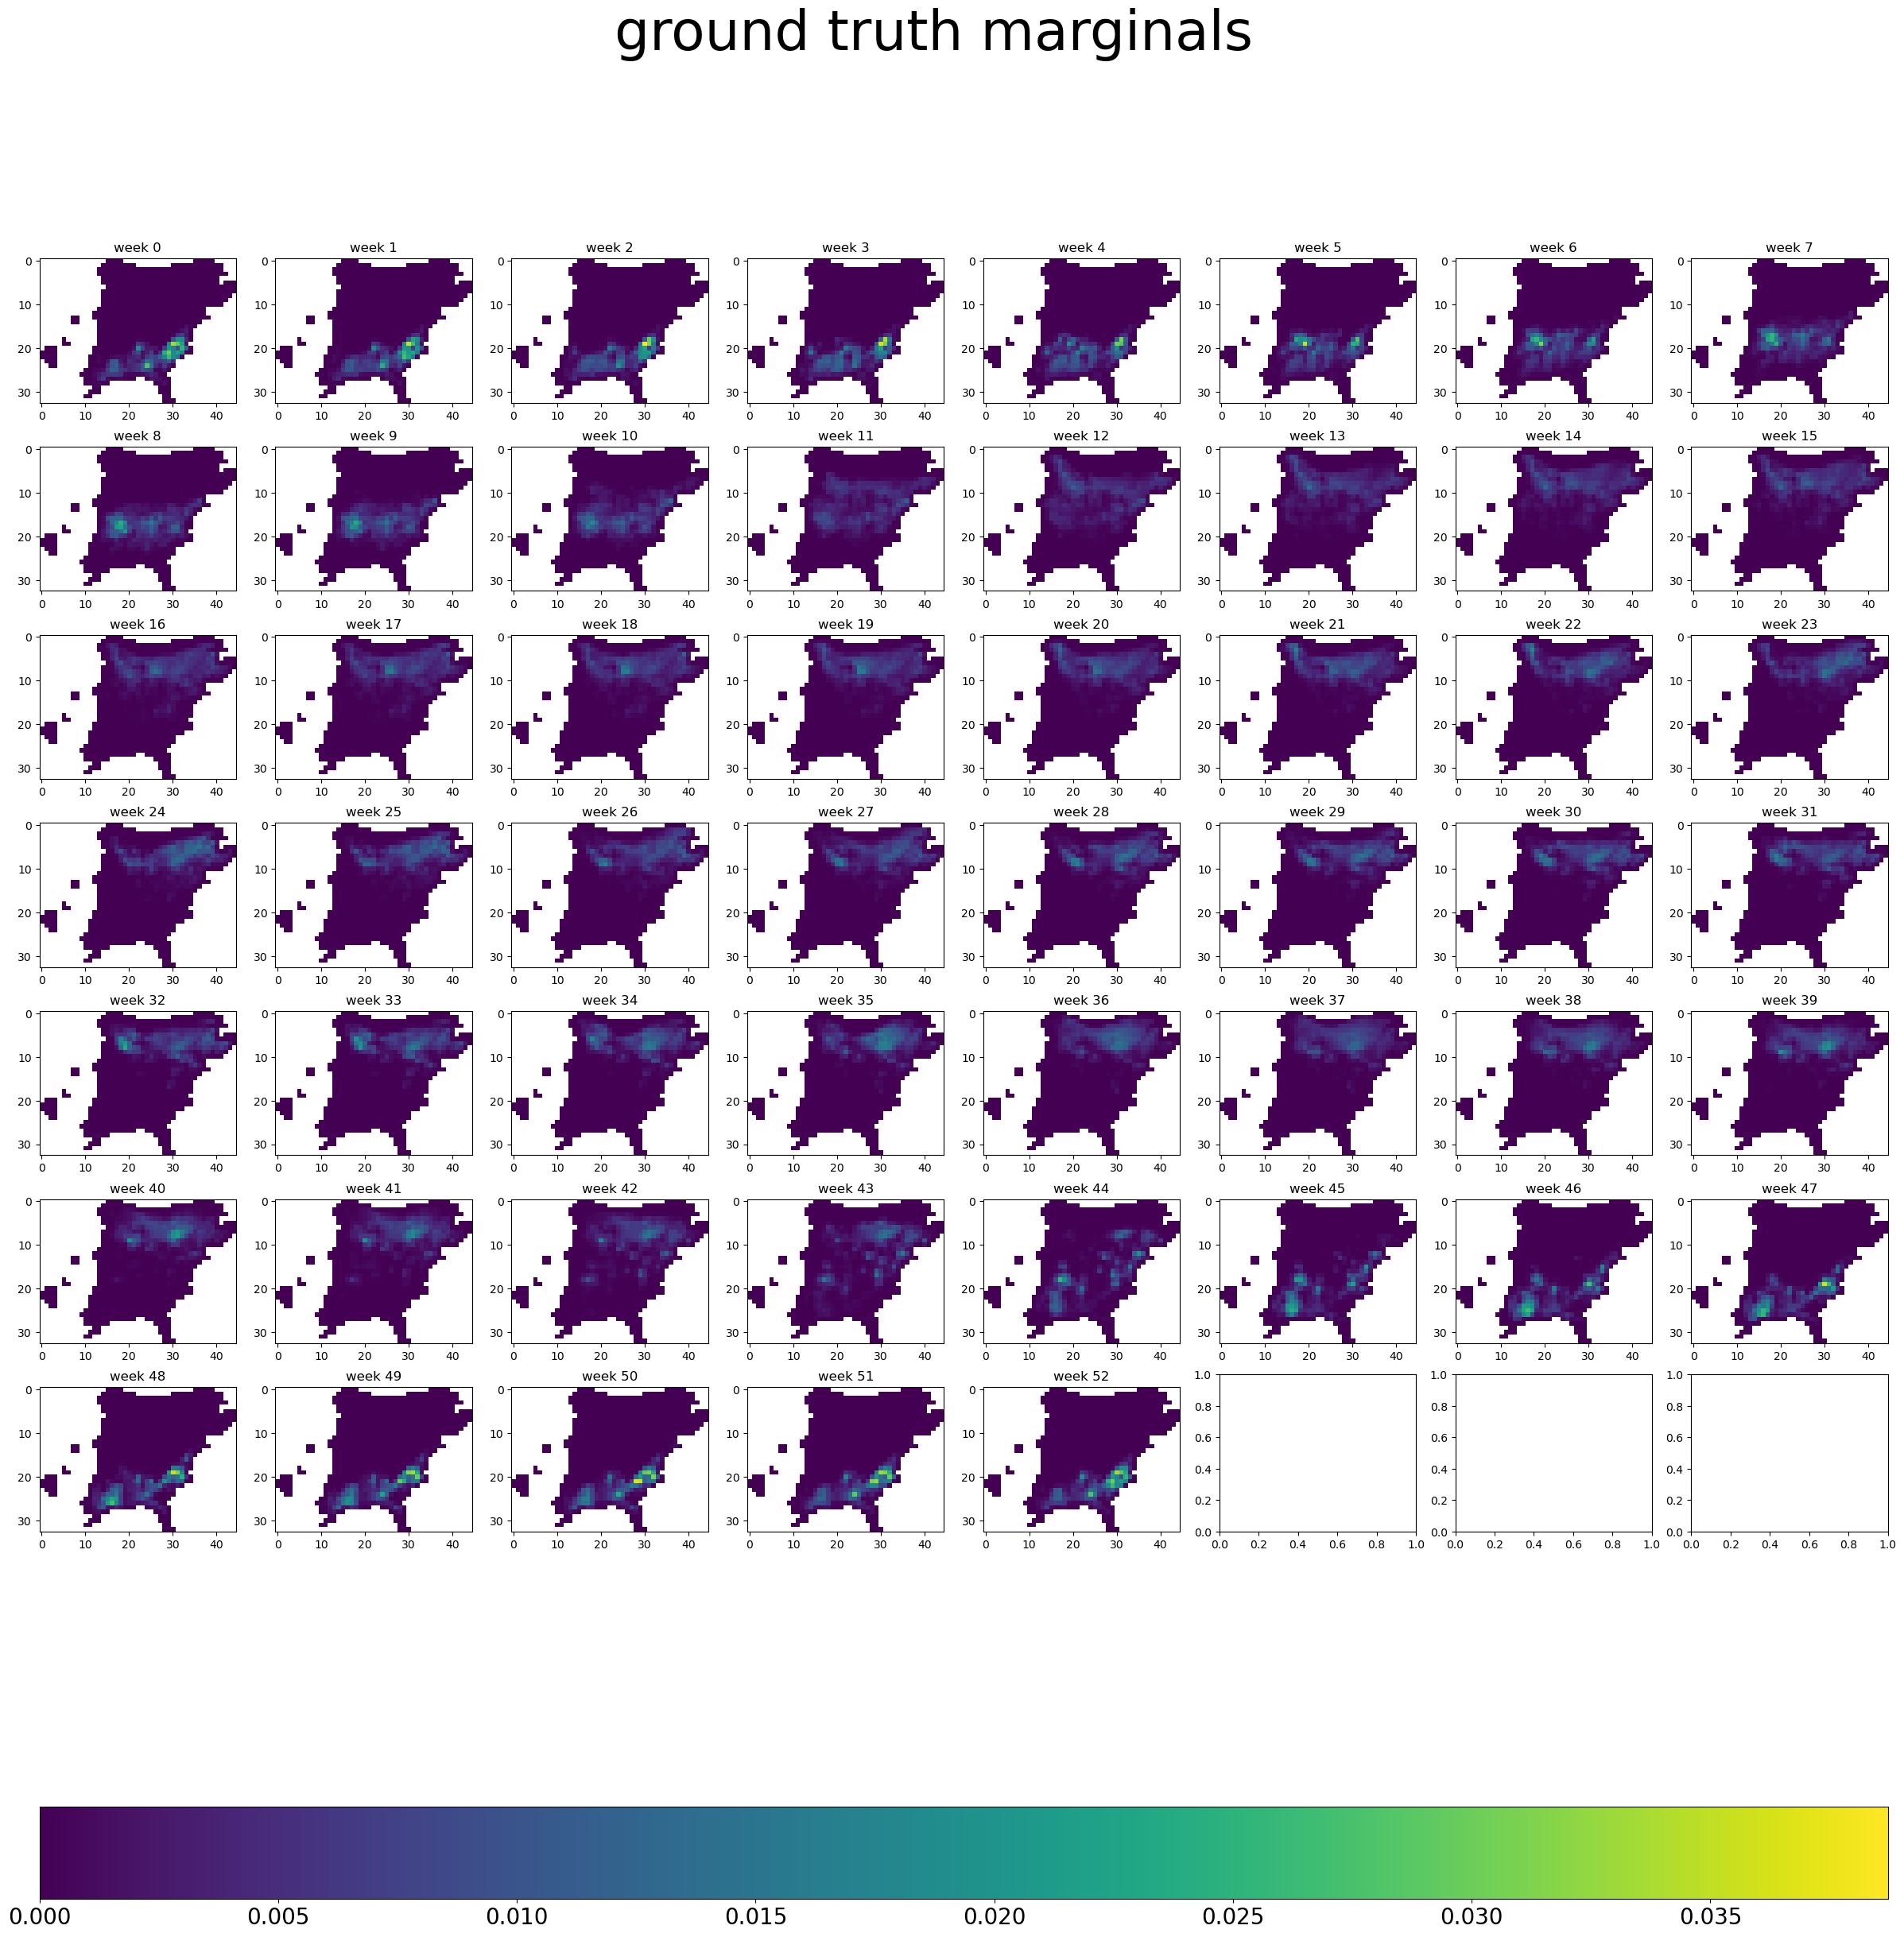

In [ ]:
# plot ground truth at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(7, 8, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in masked_densities])
for week, marginal in enumerate(masked_densities):
    grid_true = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_true, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("ground truth marginals", fontsize=50)
plt.show()

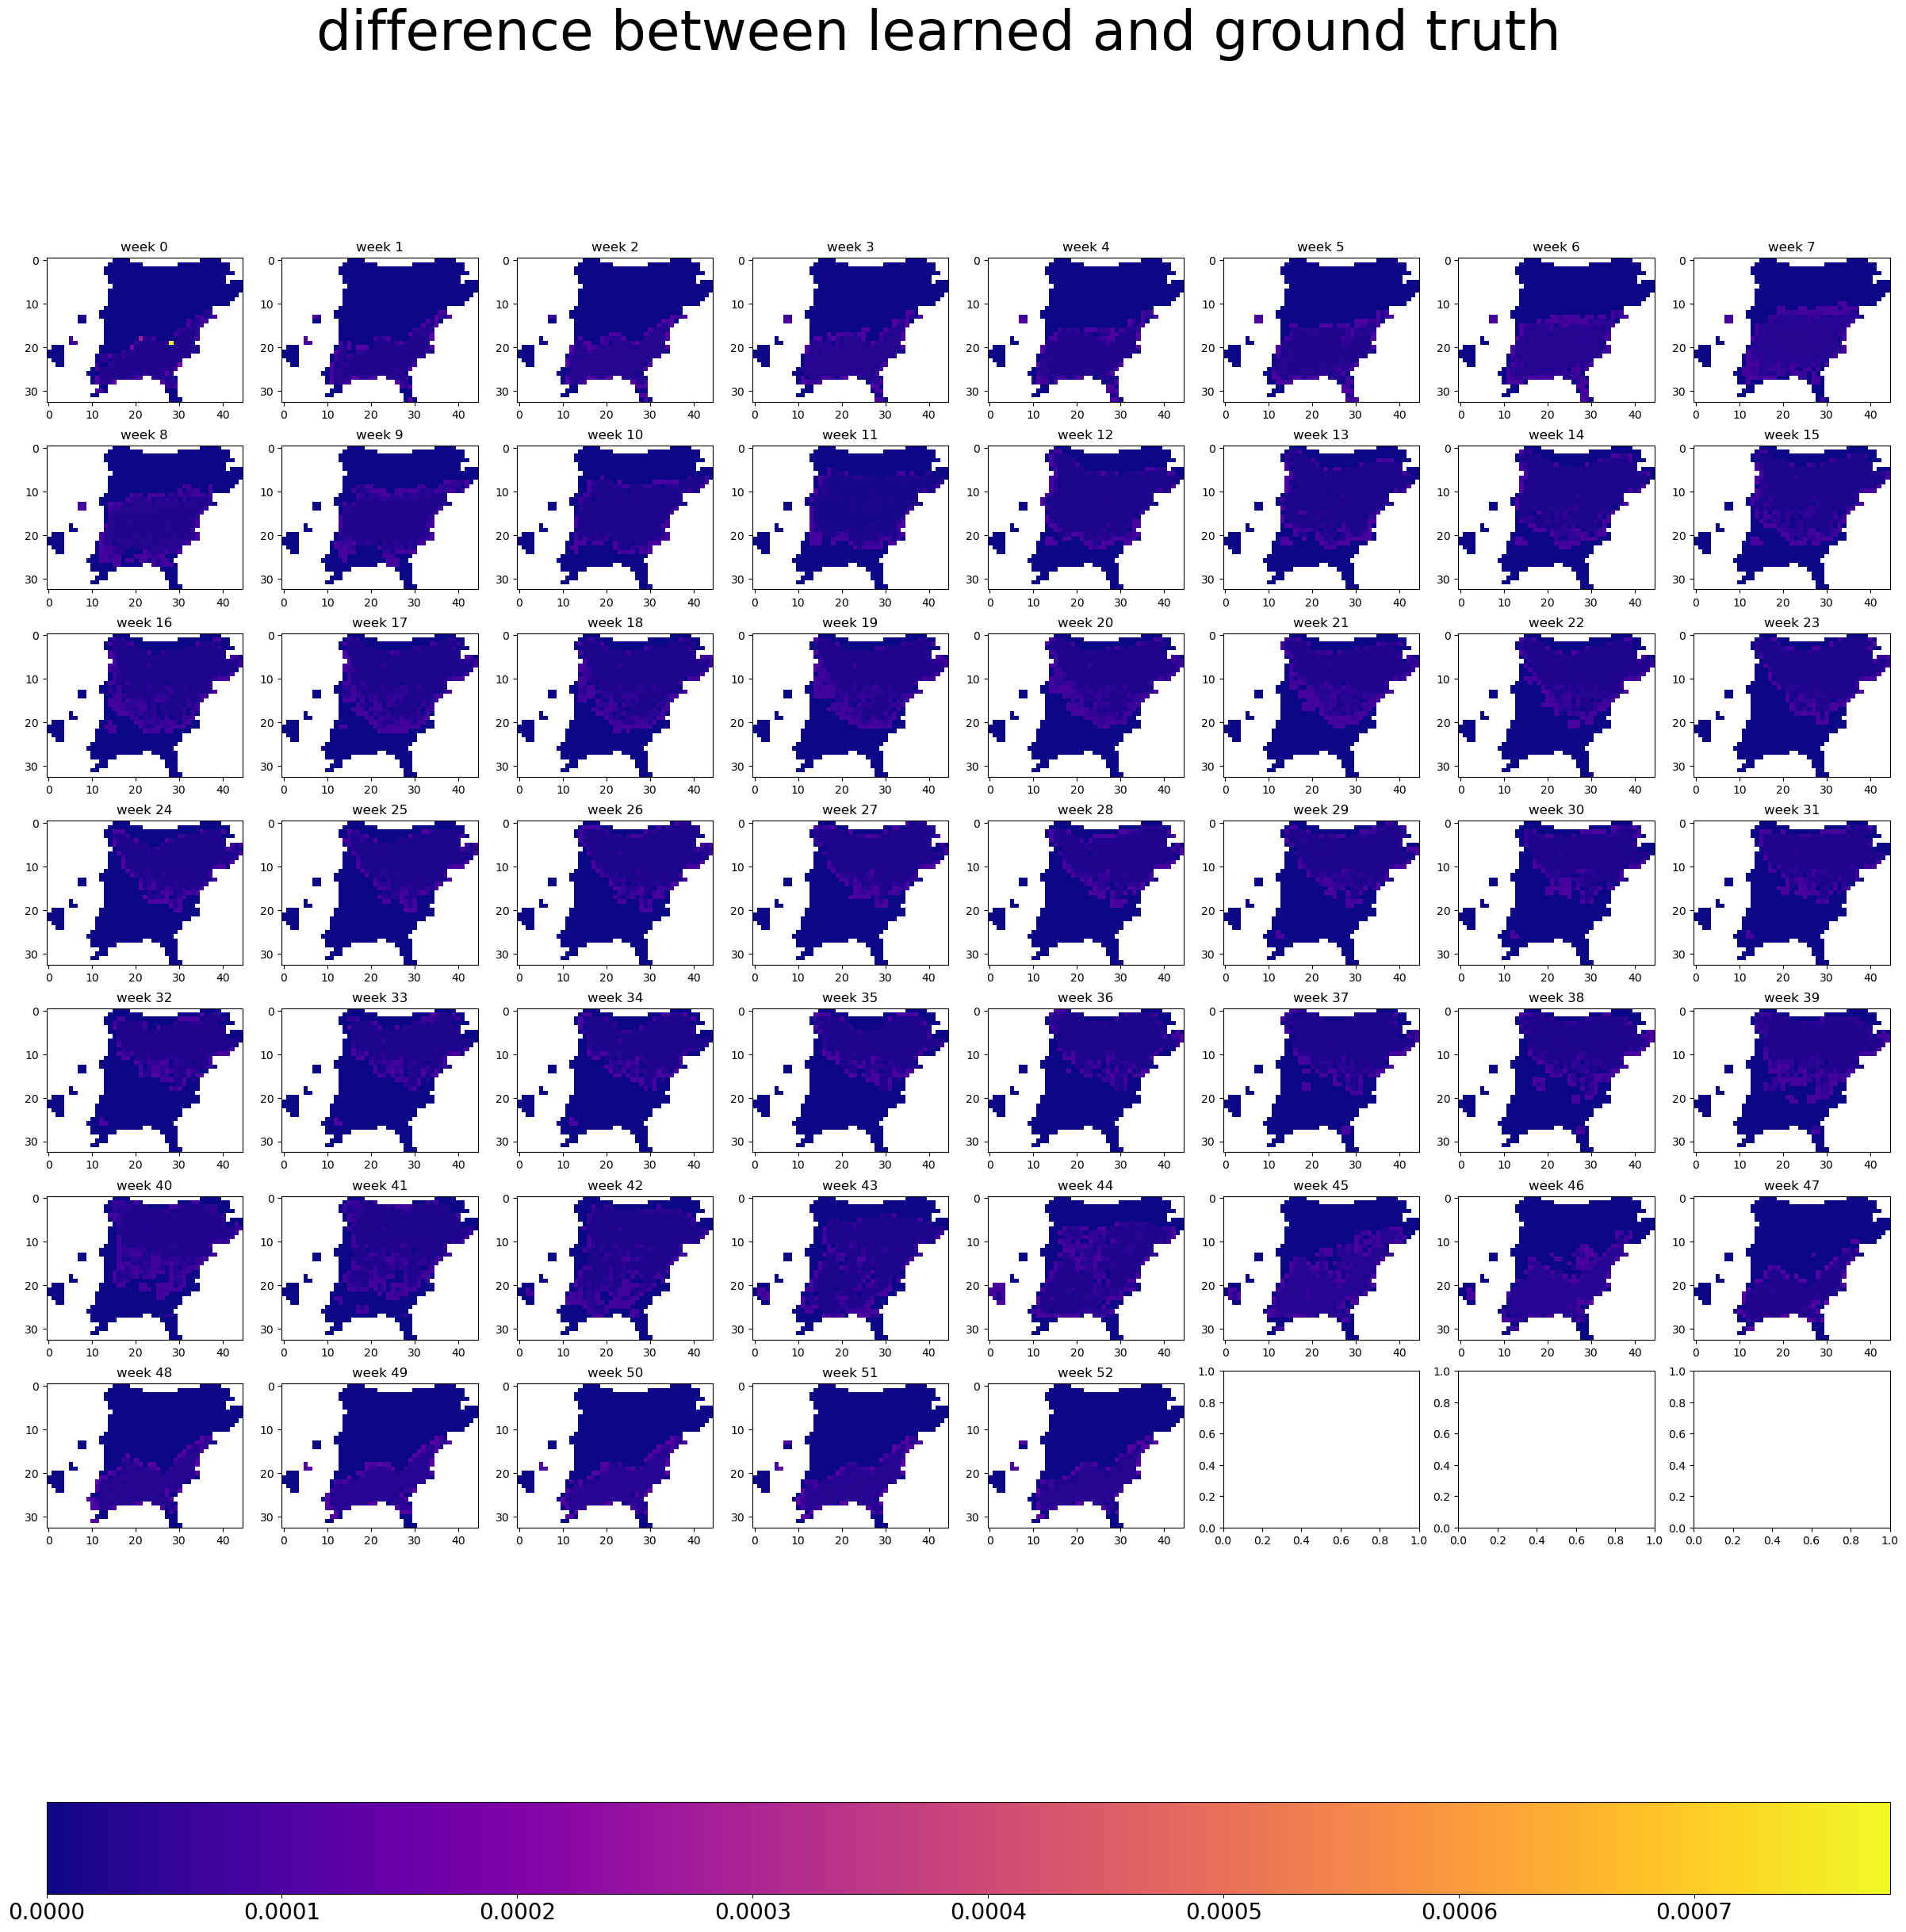

In [ ]:
# plot difference between learned and ground truth for each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(7, 8, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, masked_densities)])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_learned - grid_true)
    pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=50)

plt.show()

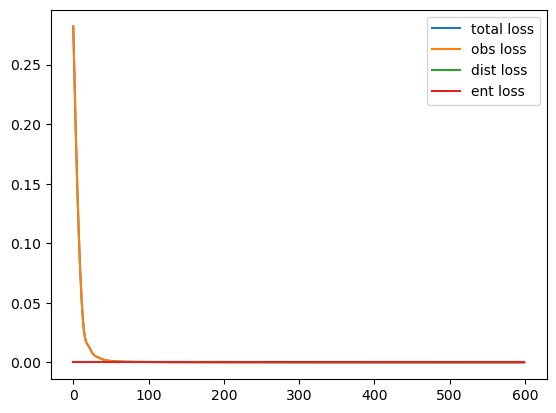

In [ ]:
ent_weight = 0
dist_weight = 0
num_iters = len(loss_dict['total'])
plt.plot(jnp.arange(num_iters), loss_dict['total'], label='total loss')
plt.plot(jnp.arange(num_iters), loss_dict['obs'], label='obs loss')
plt.plot(jnp.arange(num_iters), dist_weight * jnp.array(loss_dict['dist']), label='dist loss')
plt.plot(jnp.arange(num_iters), ent_weight * jnp.array(loss_dict['ent']), label='ent loss')
plt.legend()
plt.show()

### Experiment 3
- Train markov chain, plot w2 loss vals
- Learn only 5 weeks of st data
- epsilons fixed to 2 * eps_default
- ow: 1, dp: 0.4, dw: 0, ew: 0

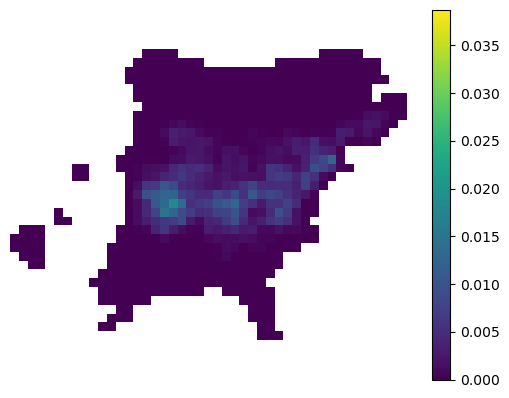

In [182]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'ex3_params_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex3_losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    loss_dict = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex3_w2_losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    w2_loss_dict = pickle.load(f)

hdf_src = '/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'
with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(len(params) - 1):
        z = params[f'Flow_Model/Week_{week + 1}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
week = 10
vmin = 0
vmax = max([marginal.max() for marginal in masked_densities])
fig, ax = plt.subplots()
marginals = get_single_tstep_marginals(params) # get marginals
marginal = masked_densities[week]
grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
pos = ax.imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)

# fig, axes = plt.subplots(3, 3, figsize=(30, 30))
# ax_list = axes.flat
# vmin = 0
# vmax = max([marginal.max() for marginal in marginals])
# for week, marginal in enumerate(marginals):
#     grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
#     pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
#     ax_list[week].set_title(f"week {week}", fontsize=30)

cbar = plt.colorbar(pos)
cbar.ax.tick_params()
ax.axis('off')
# fig.suptitle("learned marginals", fontsize=50)
plt.show()


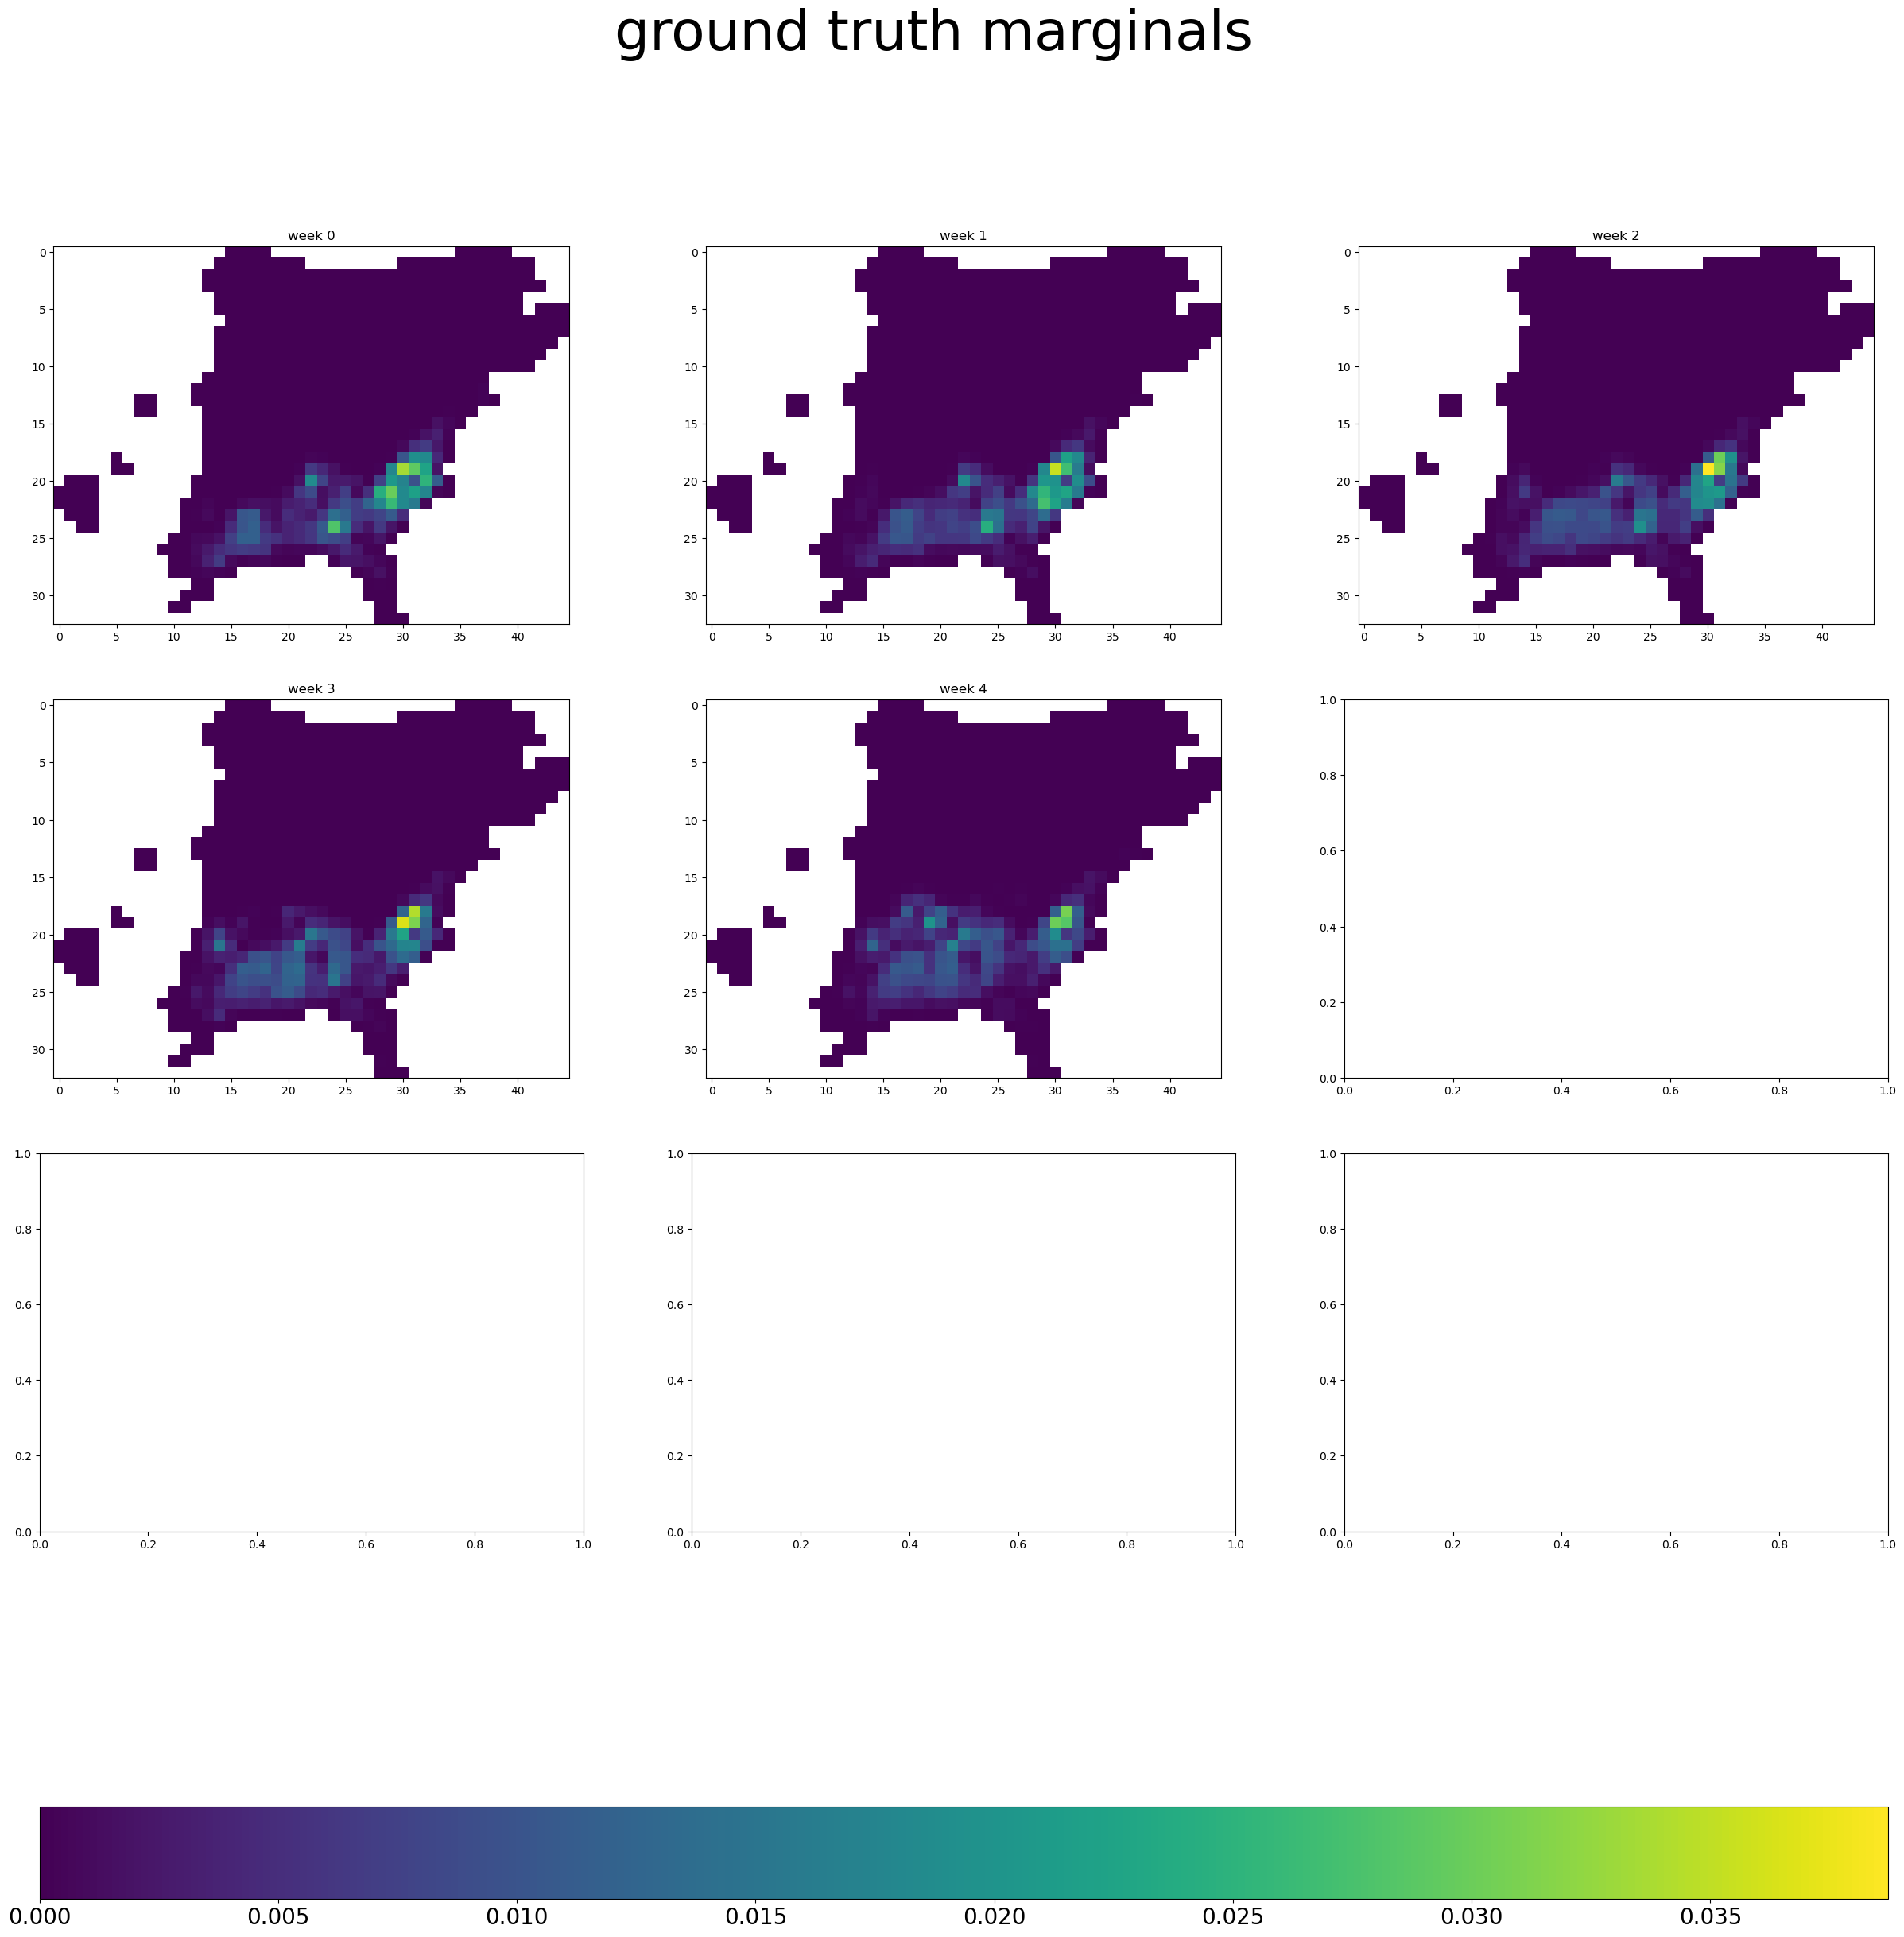

In [161]:
# plot ground truth at each week
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
ax_list = axes.flat
ex3_masked_densities = masked_densities[:len(params)]
vmin = 0
vmax = max([marginal.max() for marginal in ex3_masked_densities])
for week, marginal in enumerate(ex3_masked_densities):
    grid_true = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_true, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}",)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("ground truth marginals", fontsize=50)
plt.show()

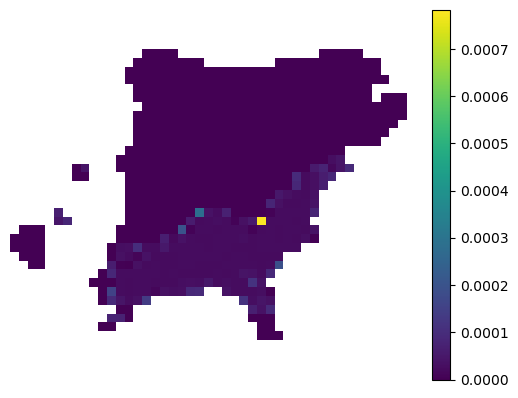

In [165]:
# plot difference between learned and ground truth for each week
fig, ax = plt.subplots()
marginals = get_single_tstep_marginals(params) # get marginals
marginal = marginals[0]
grid_learned = make_grid(marginal, dynamic_masks[0], big_mask, ncol, nrow)
grid_true = make_grid(ex3_masked_densities[0], dynamic_masks[0], big_mask, ncol, nrow)
grid_diff = jnp.abs(grid_learned - grid_true)
pos = ax.imshow(grid_diff)
cbar = fig.colorbar(pos, ax=ax)
ax.axis("off")
plt.show()

# fig, axes = plt.subplots(3, 3, figsize=(30, 30))
# ax_list = axes.flat
# vmin = 0
# vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, ex3_masked_densities)])
# for week, marginal in enumerate(marginals):
#     grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
#     grid_true = make_grid(ex3_masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
#     grid_diff = jnp.abs(grid_learned - grid_true)
#     pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
#     ax_list[week].set_title(f"week {week}")

# cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
# cbar.ax.tick_params(labelsize=20)
# fig.suptitle("difference between learned and ground truth", fontsize=50)

# plt.show()

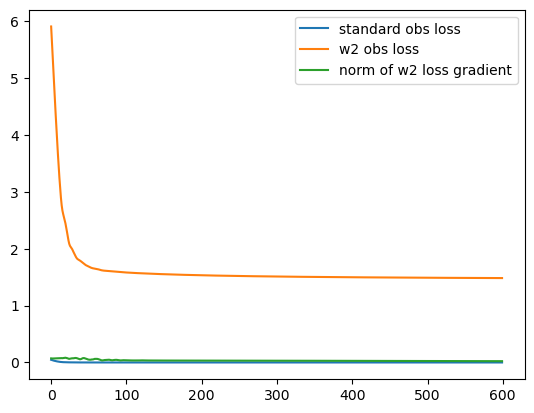

In [ ]:
ent_weight = 0
dist_weight = 0
num_iters = len(loss_dict['total'])
plt.plot(jnp.arange(num_iters), loss_dict['obs'], label='standard obs loss')
plt.plot(jnp.arange(num_iters), w2_loss_dict['obs'], label='w2 obs loss')
plt.legend()
plt.show()

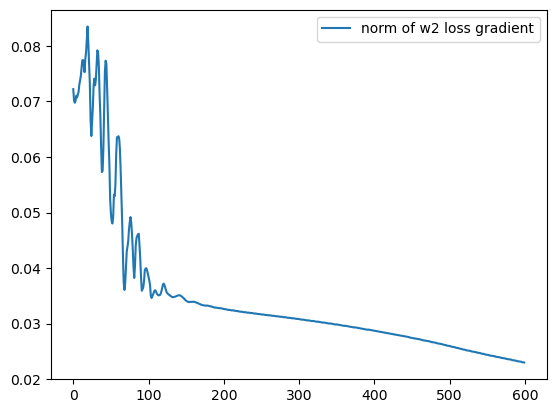

In [ ]:
plt.plot(jnp.arange(num_iters), w2_loss_dict['norm_w2_grad'], label='norm of w2 loss gradient')
plt.legend()
plt.show()

#### Experiment 3.1
- Learn 23 weeks of ebird data
- epsilons fixed to 2 * `eps_default`
- ow: 1, dp: 0.4, dw: 0, ew: 0
- took ~50 mins on the cluster

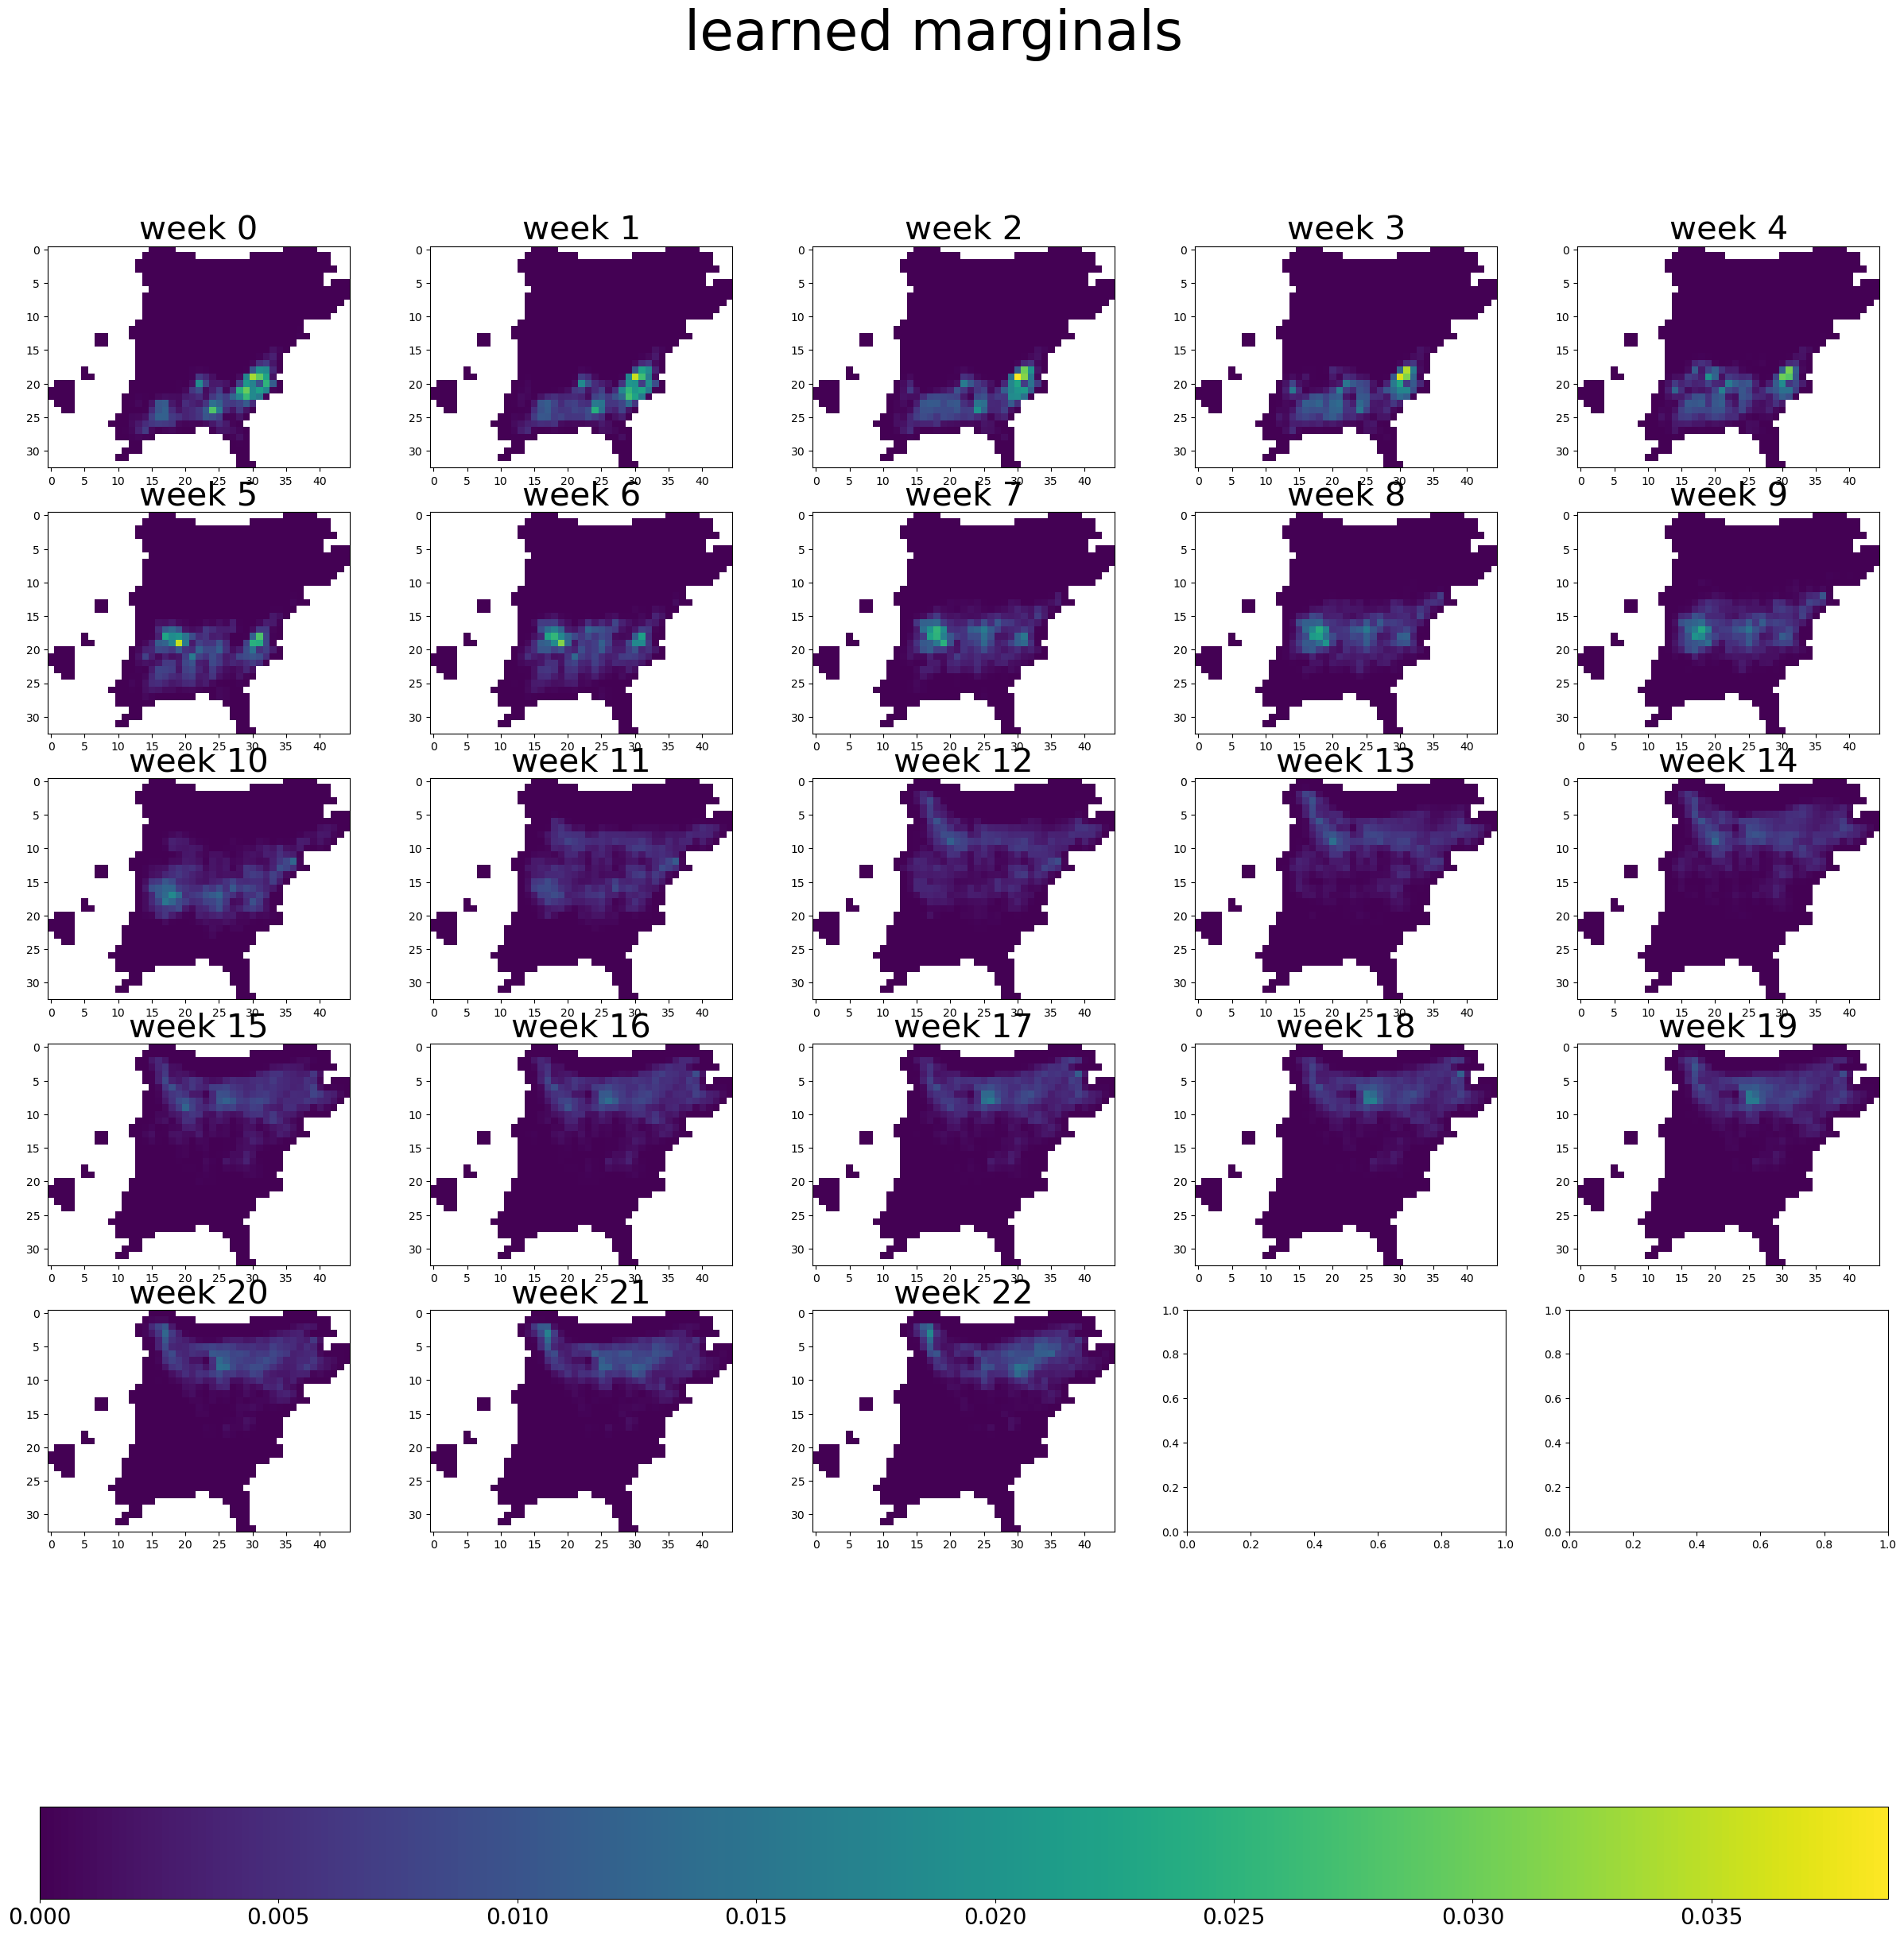

In [ ]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'ex31_params_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex31_losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    loss_dict = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex31_w2_losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    w2_loss_dict = pickle.load(f)

hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(len(params) - 1):
        z = params[f'Flow_Model/Week_{week + 1}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(5, 5, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in marginals])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=30)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()


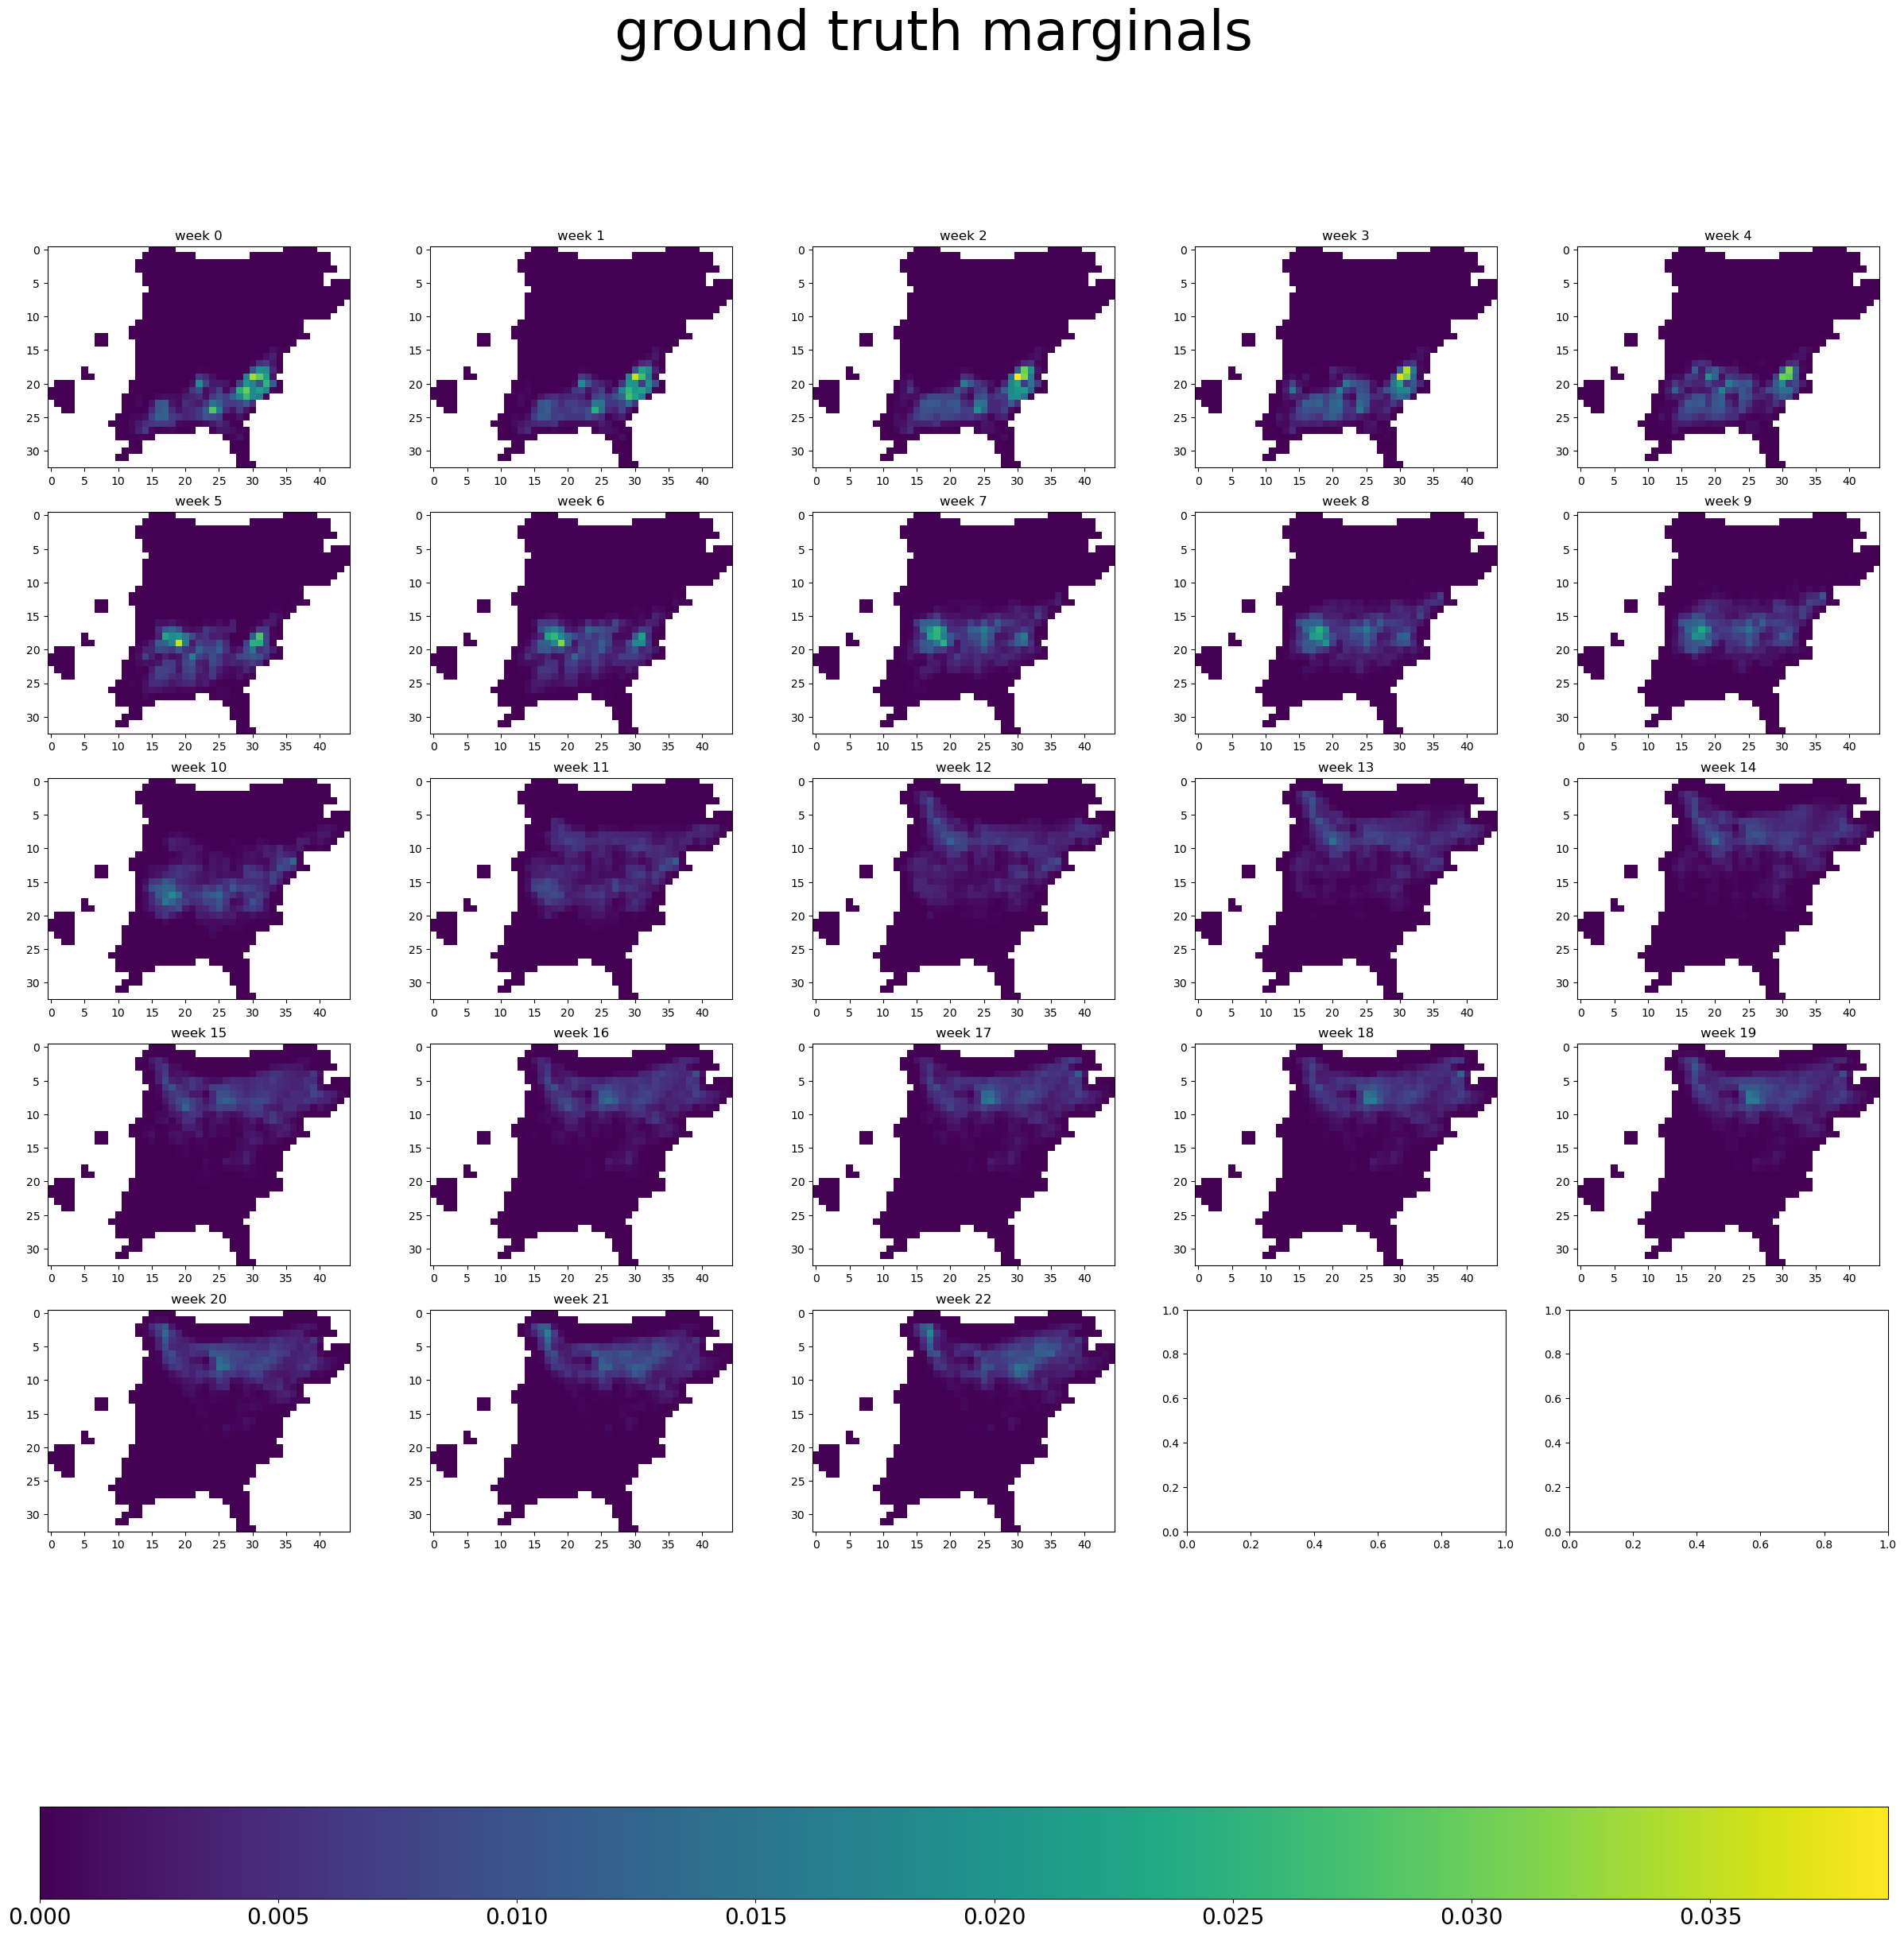

In [ ]:
# plot ground truth at each week
fig, axes = plt.subplots(5, 5, figsize=(30, 30))
ax_list = axes.flat
ex3_masked_densities = masked_densities[:len(params)]
vmin = 0
vmax = max([marginal.max() for marginal in ex3_masked_densities])
for week, marginal in enumerate(ex3_masked_densities):
    grid_true = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_true, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}",)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("ground truth marginals", fontsize=50)
plt.show()

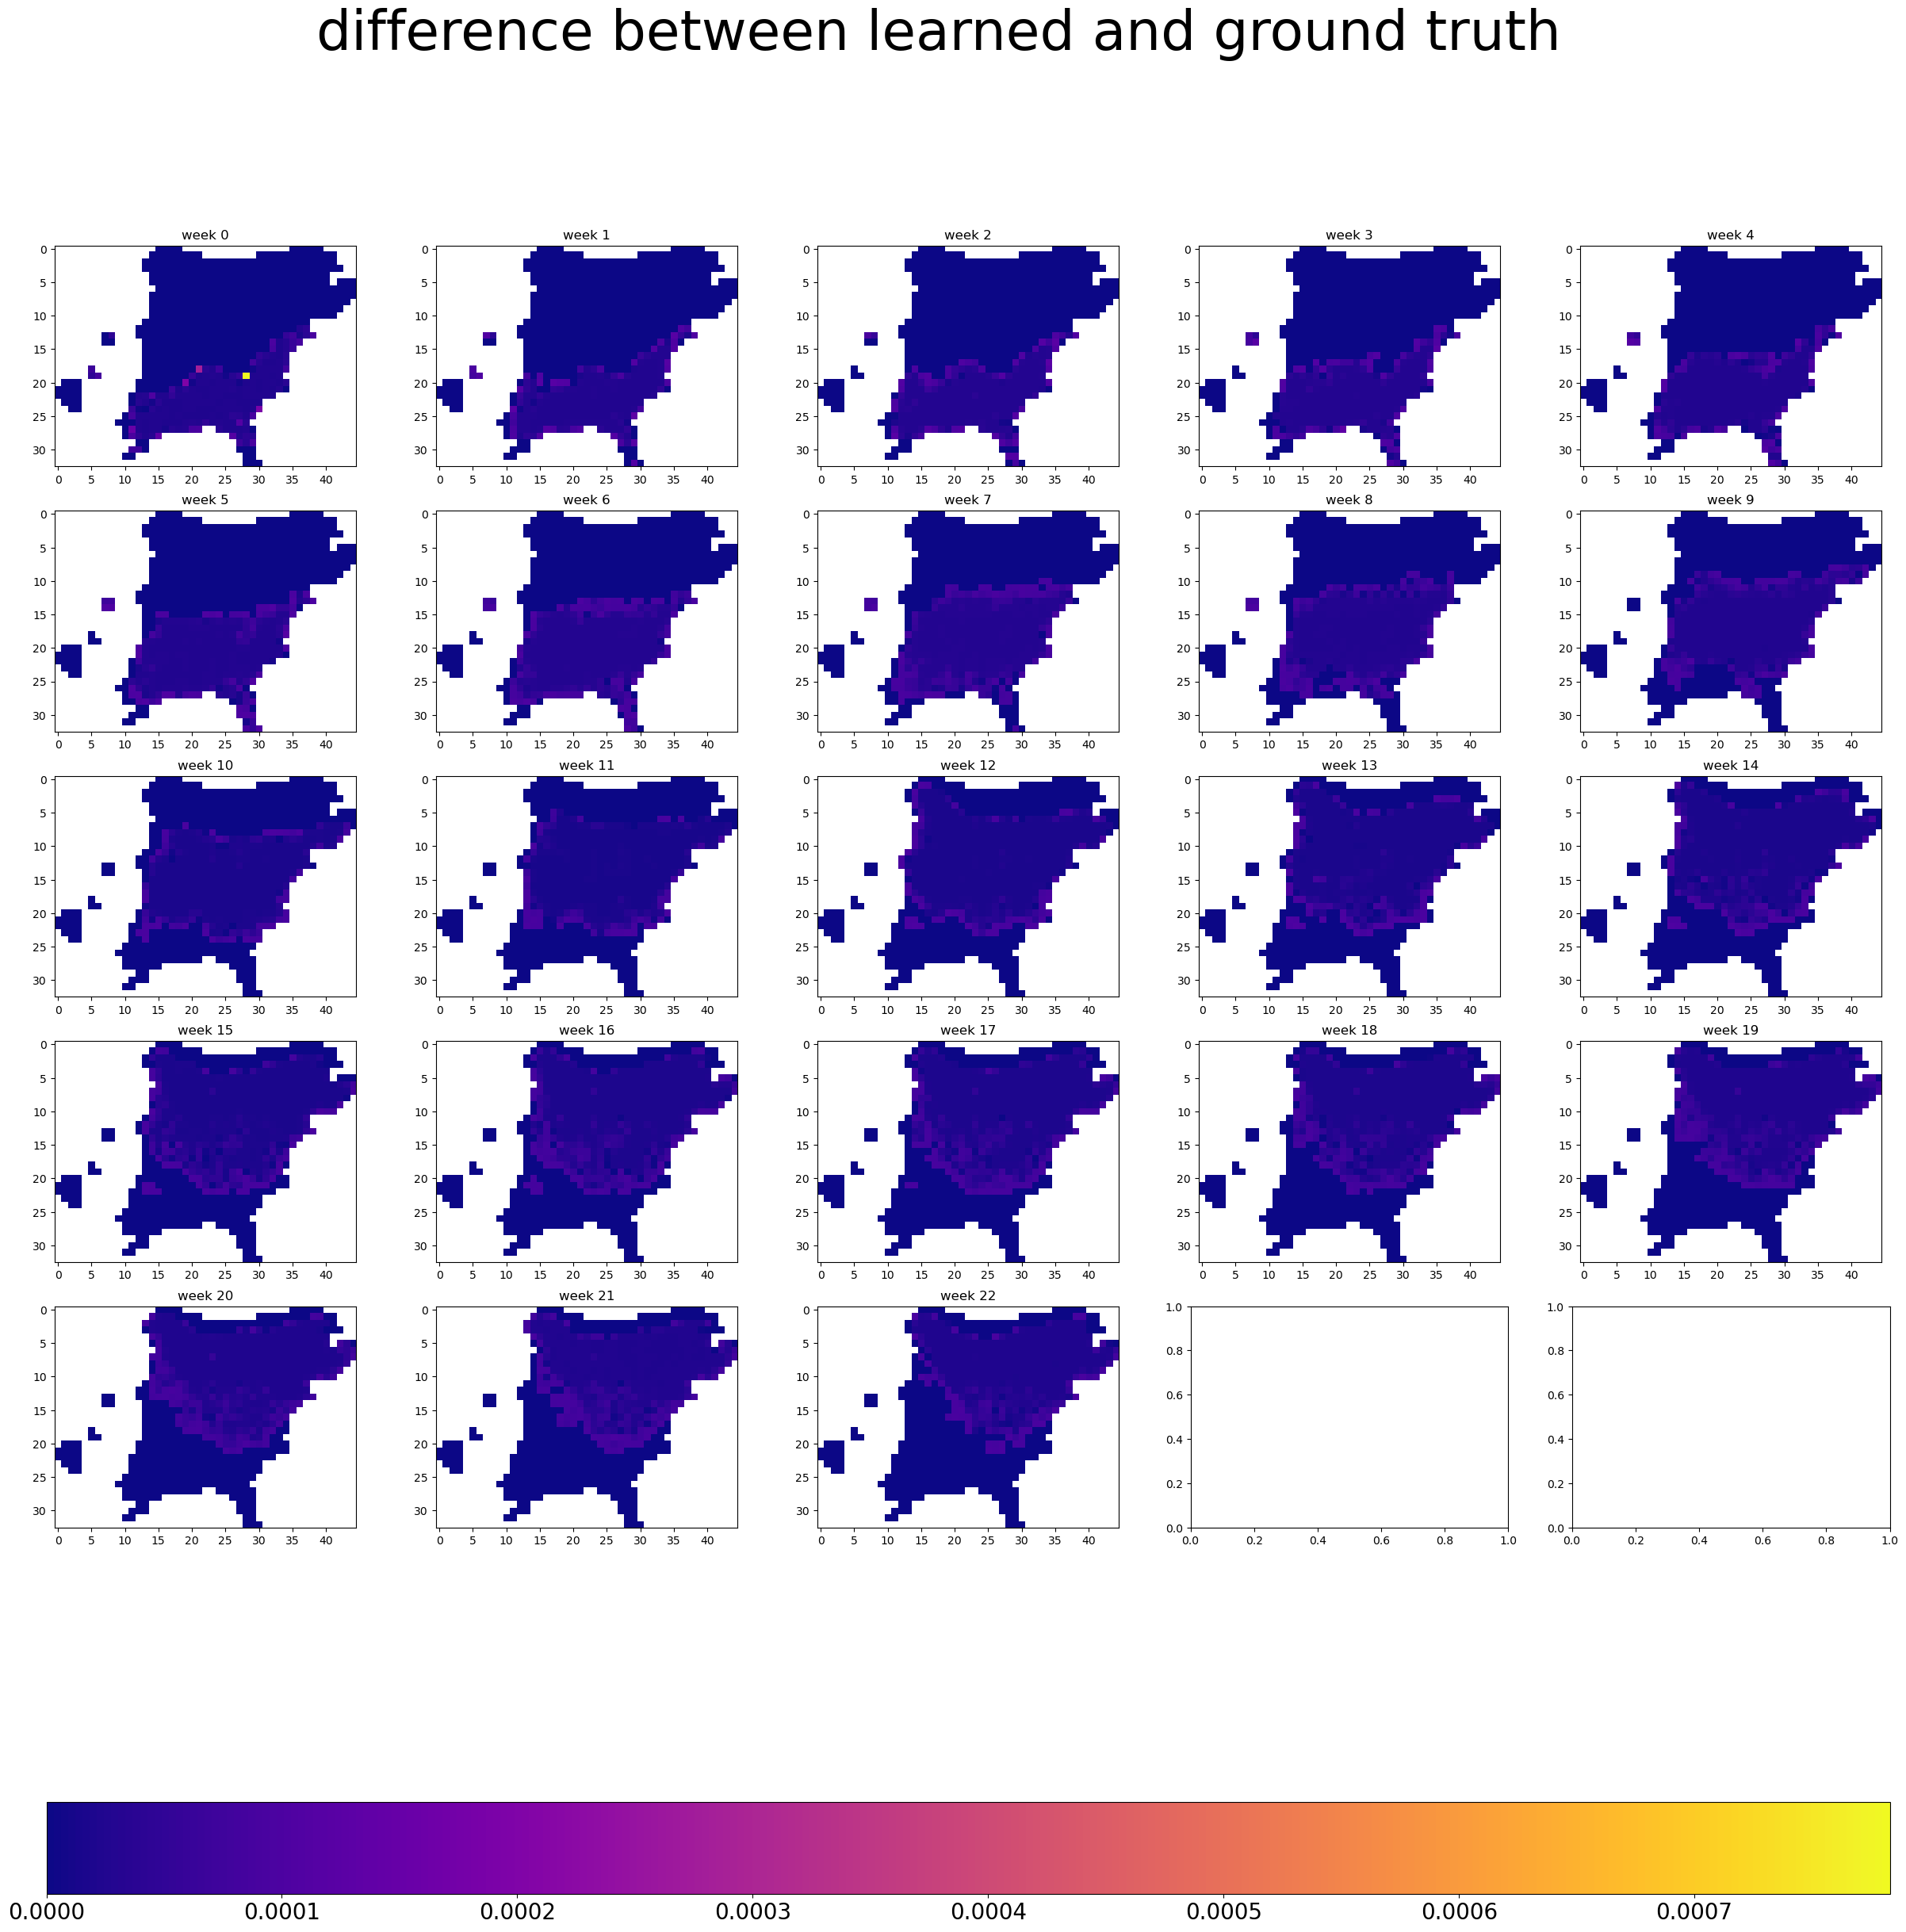

In [ ]:
# plot difference between learned and ground truth for each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(5, 5, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, ex3_masked_densities)])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(ex3_masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_learned - grid_true)
    pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[week].set_title(f"week {week}")

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=50)

plt.show()

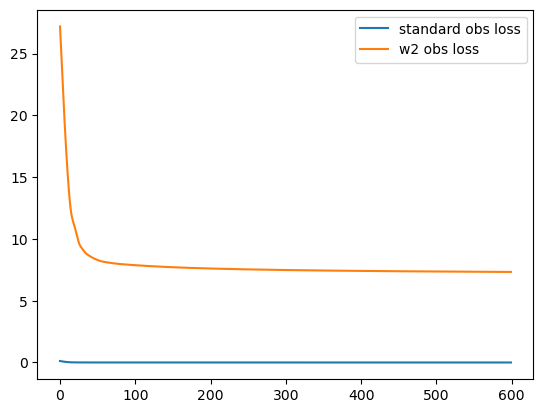

In [ ]:
ent_weight = 0
dist_weight = 0
num_iters = len(loss_dict['total'])
plt.plot(jnp.arange(num_iters), loss_dict['obs'], label='standard obs loss')
plt.plot(jnp.arange(num_iters), w2_loss_dict['obs'], label='w2 obs loss')
plt.legend()
plt.show()

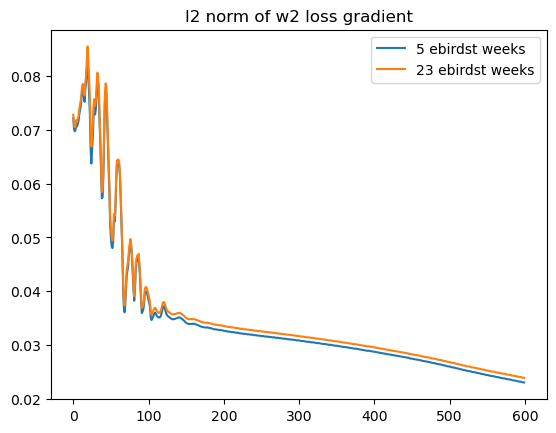

In [ ]:
with open(os.path.join(experiment_dir, 'ex3_w2_losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    ex3_w2_loss_dict = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex31_w2_losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    ex31_w2_loss_dict = pickle.load(f)

plt.plot(jnp.arange(num_iters), ex3_w2_loss_dict['norm_w2_grad'], label='5 ebirdst weeks')
plt.plot(jnp.arange(num_iters), ex31_w2_loss_dict['norm_w2_grad'], label='23 ebirdst weeks')
plt.legend()
plt.title("l2 norm of w2 loss gradient")
plt.show()

### Experiment 4
- Train with w2 observation loss function
- ow: 1, dp: 0.4, dw: 0, ew: 0
- parameter settings for linear epsilon decay
    - end: 0.01, start: 2, decay_after: 500, decay_iters: 100
- Learn 5 weeks of ebird st data
- Random initialization!

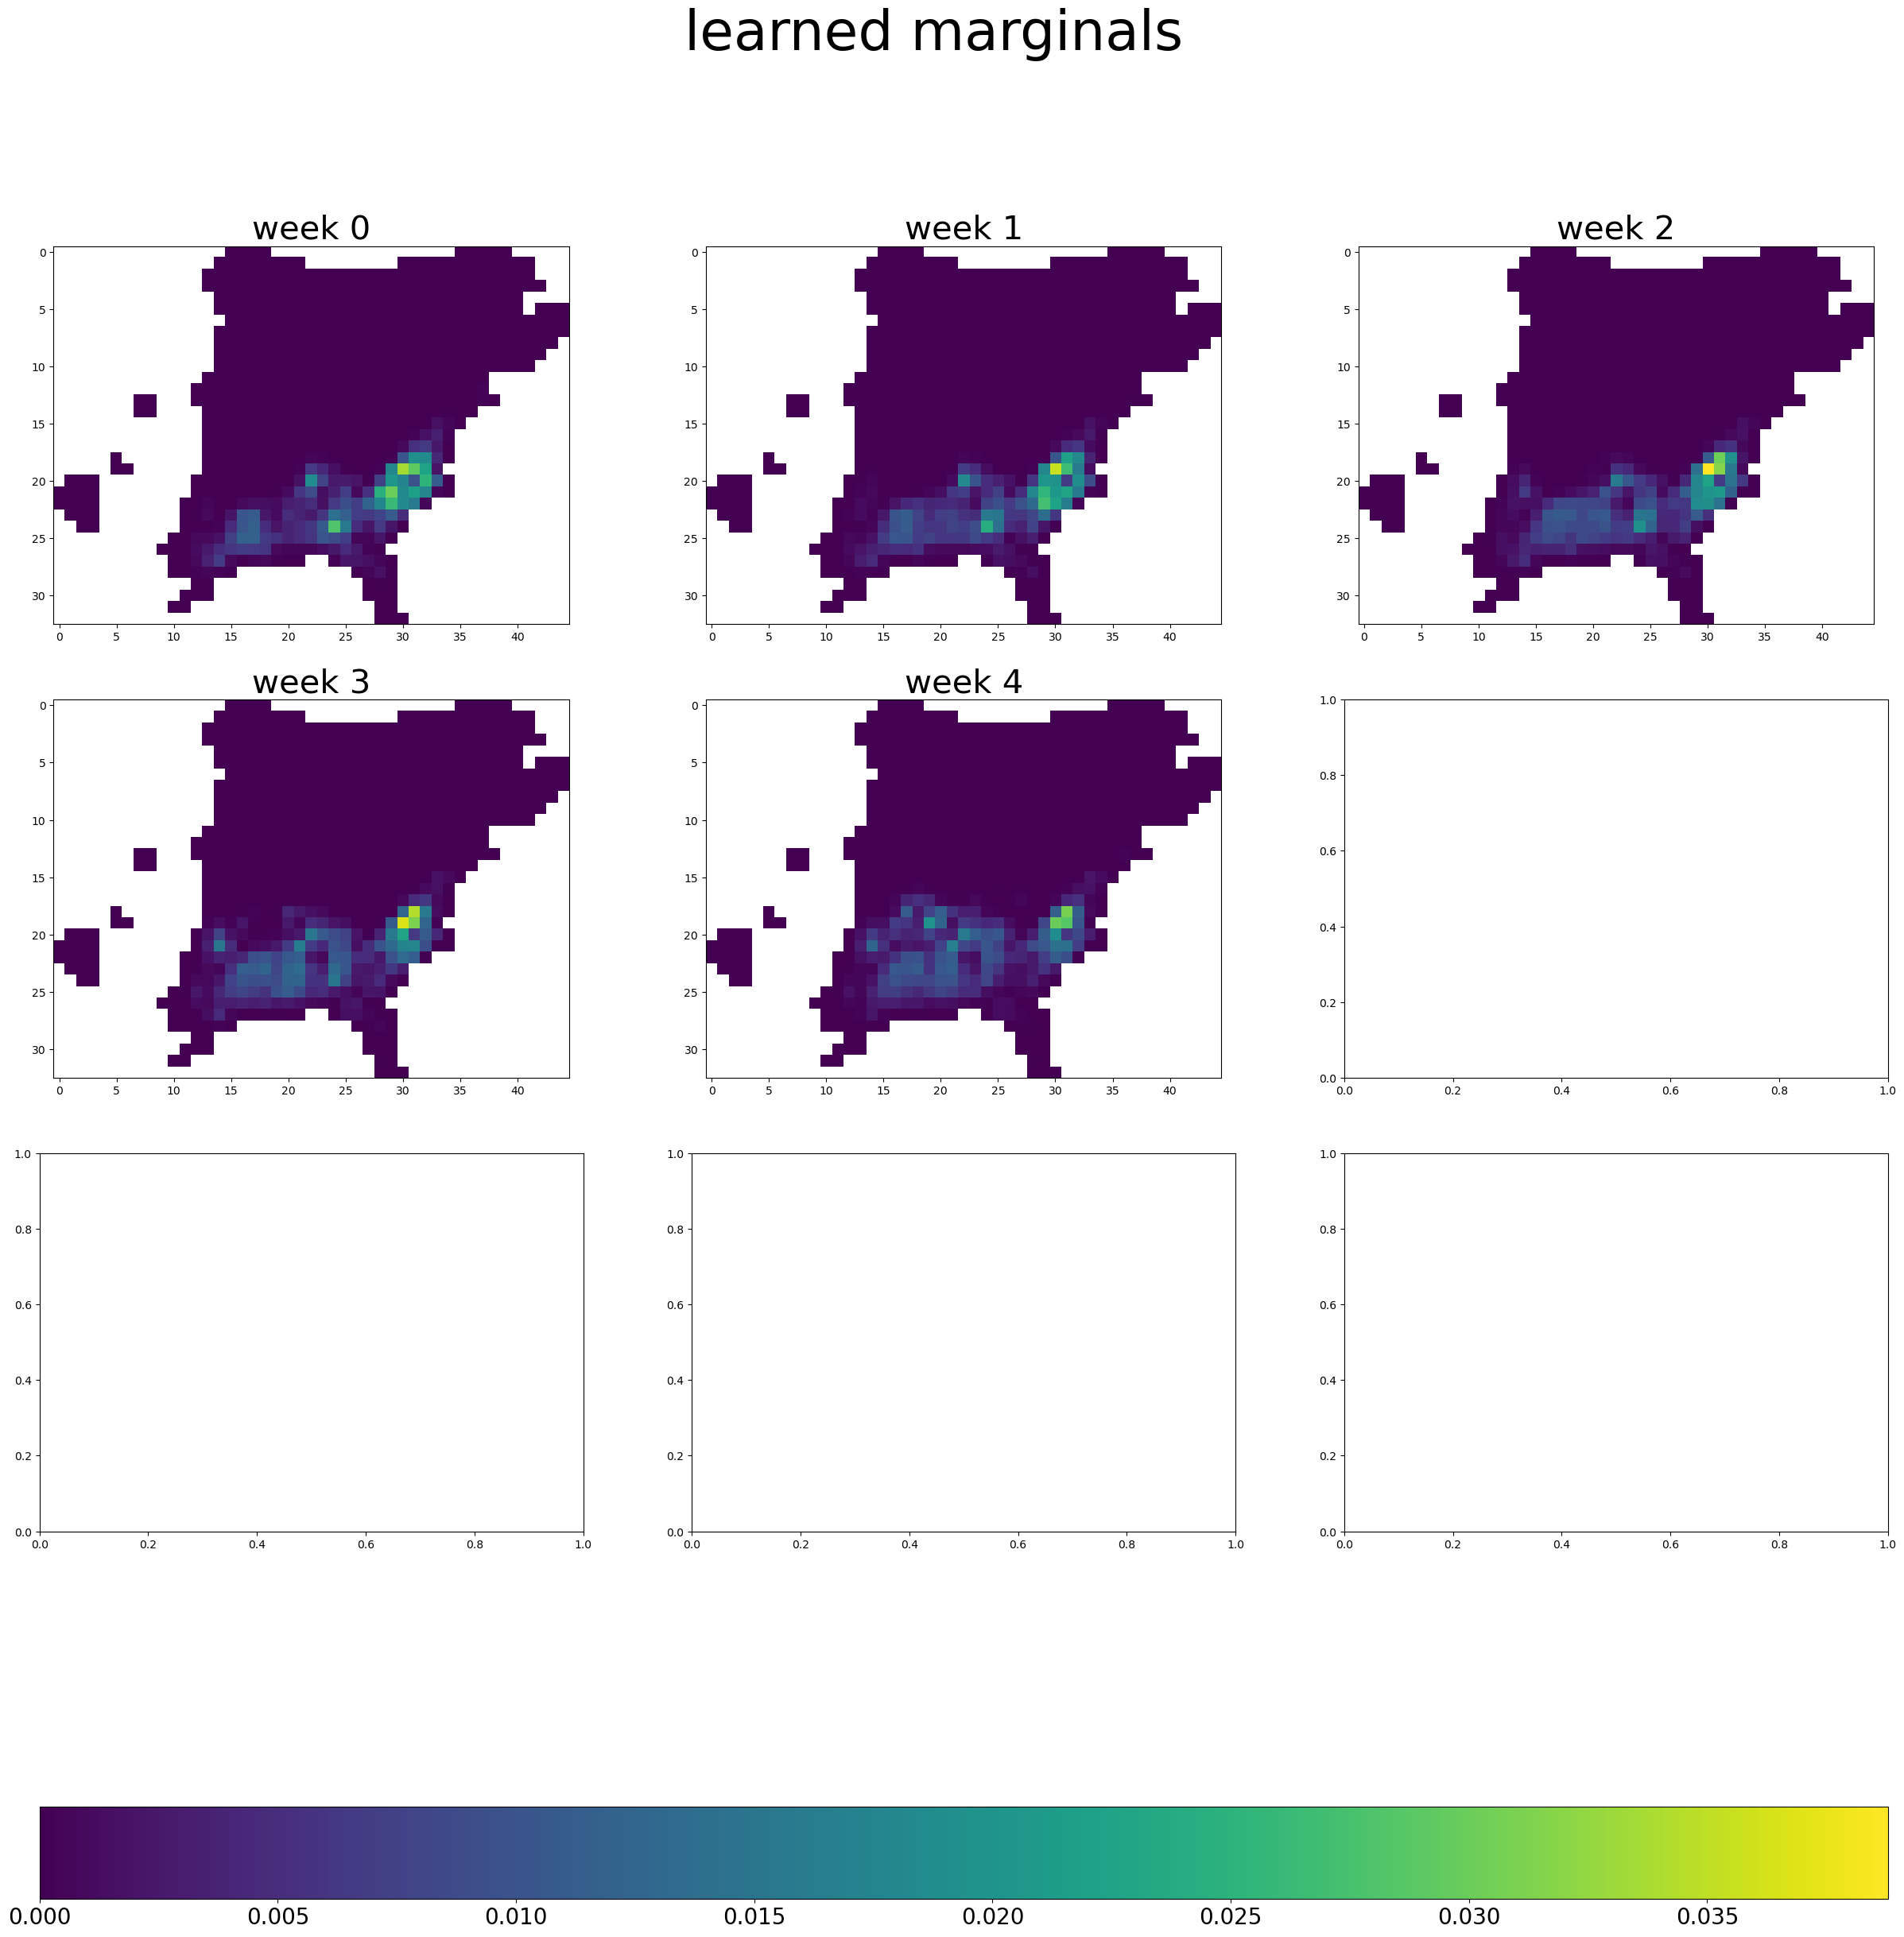

In [ ]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'ex4_w2_params_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex4_w2_losses_amewoo_2021_100km_obs1.0_ent0_dist0_pow0.4.pkl'),
          'rb') as f:
    loss_dict = pickle.load(f)

hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(len(params) - 1):
        z = params[f'Flow_Model/Week_{week + 1}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in marginals])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=30)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()


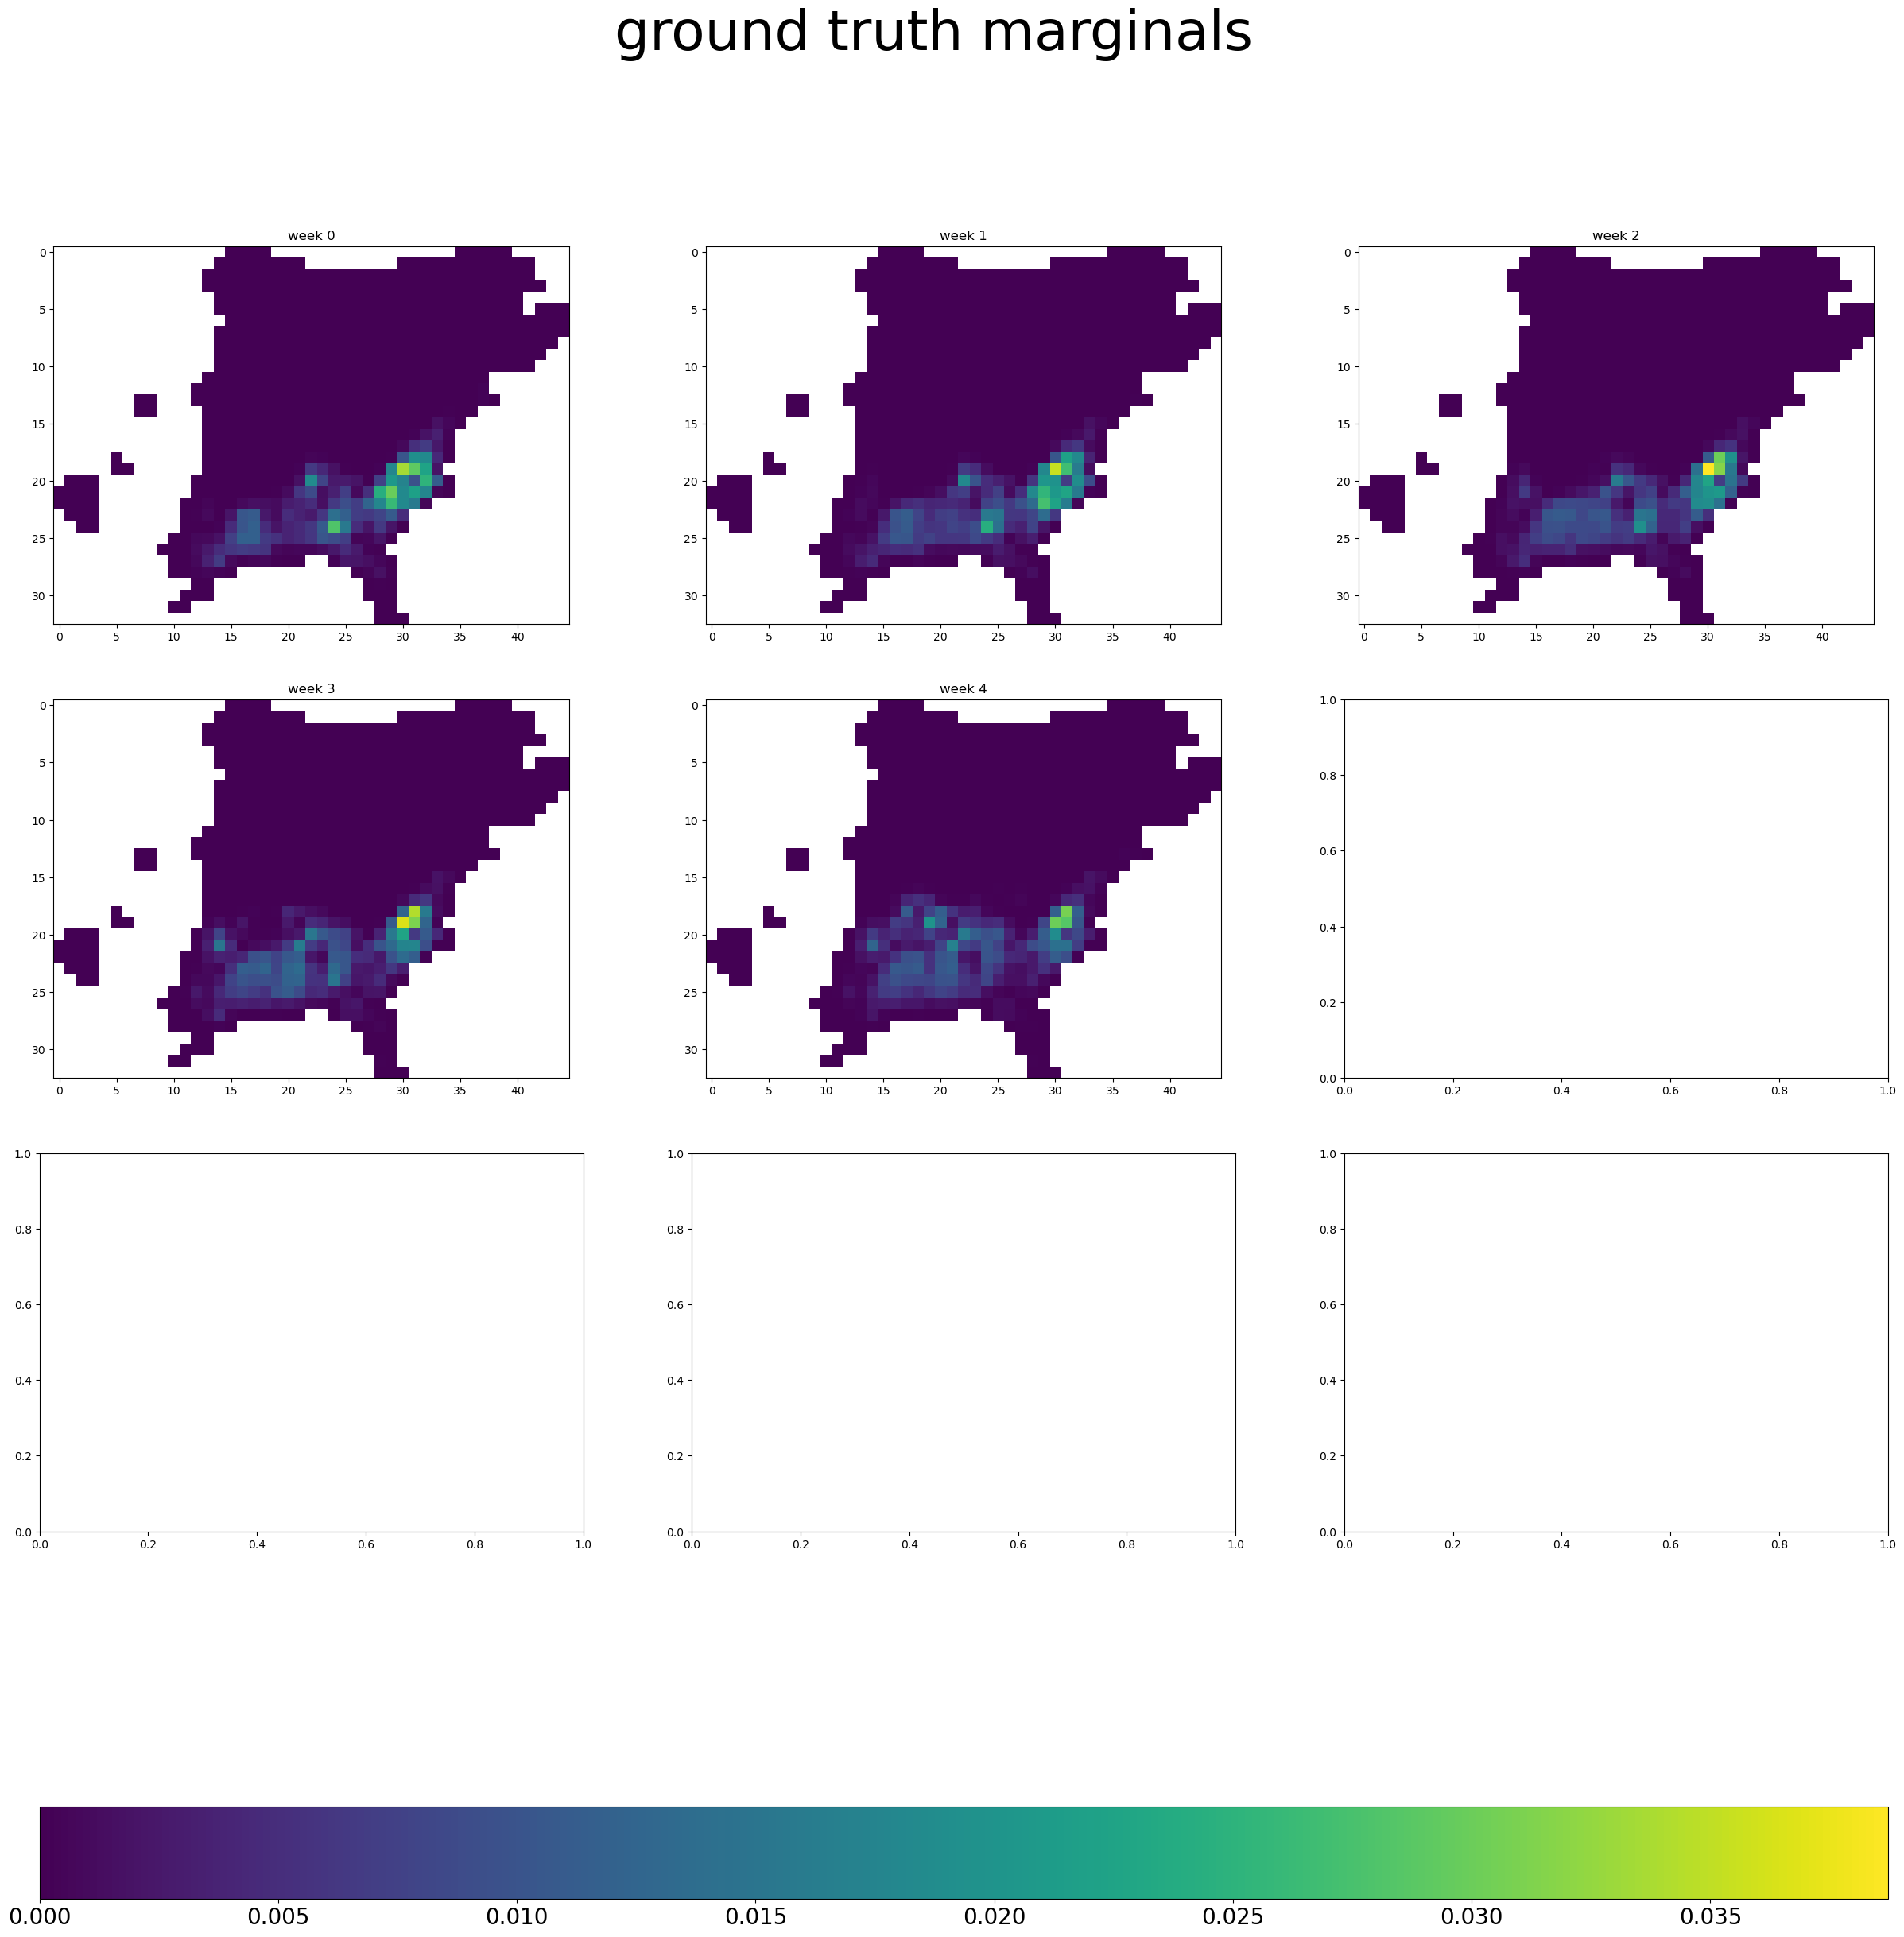

In [ ]:
# plot ground truth at each week
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
ax_list = axes.flat
trimmed_masked_densities = masked_densities[:len(params)]
vmin = 0
vmax = max([marginal.max() for marginal in trimmed_masked_densities])
for week, marginal in enumerate(trimmed_masked_densities):
    grid_true = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_true, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}",)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("ground truth marginals", fontsize=50)
plt.show()

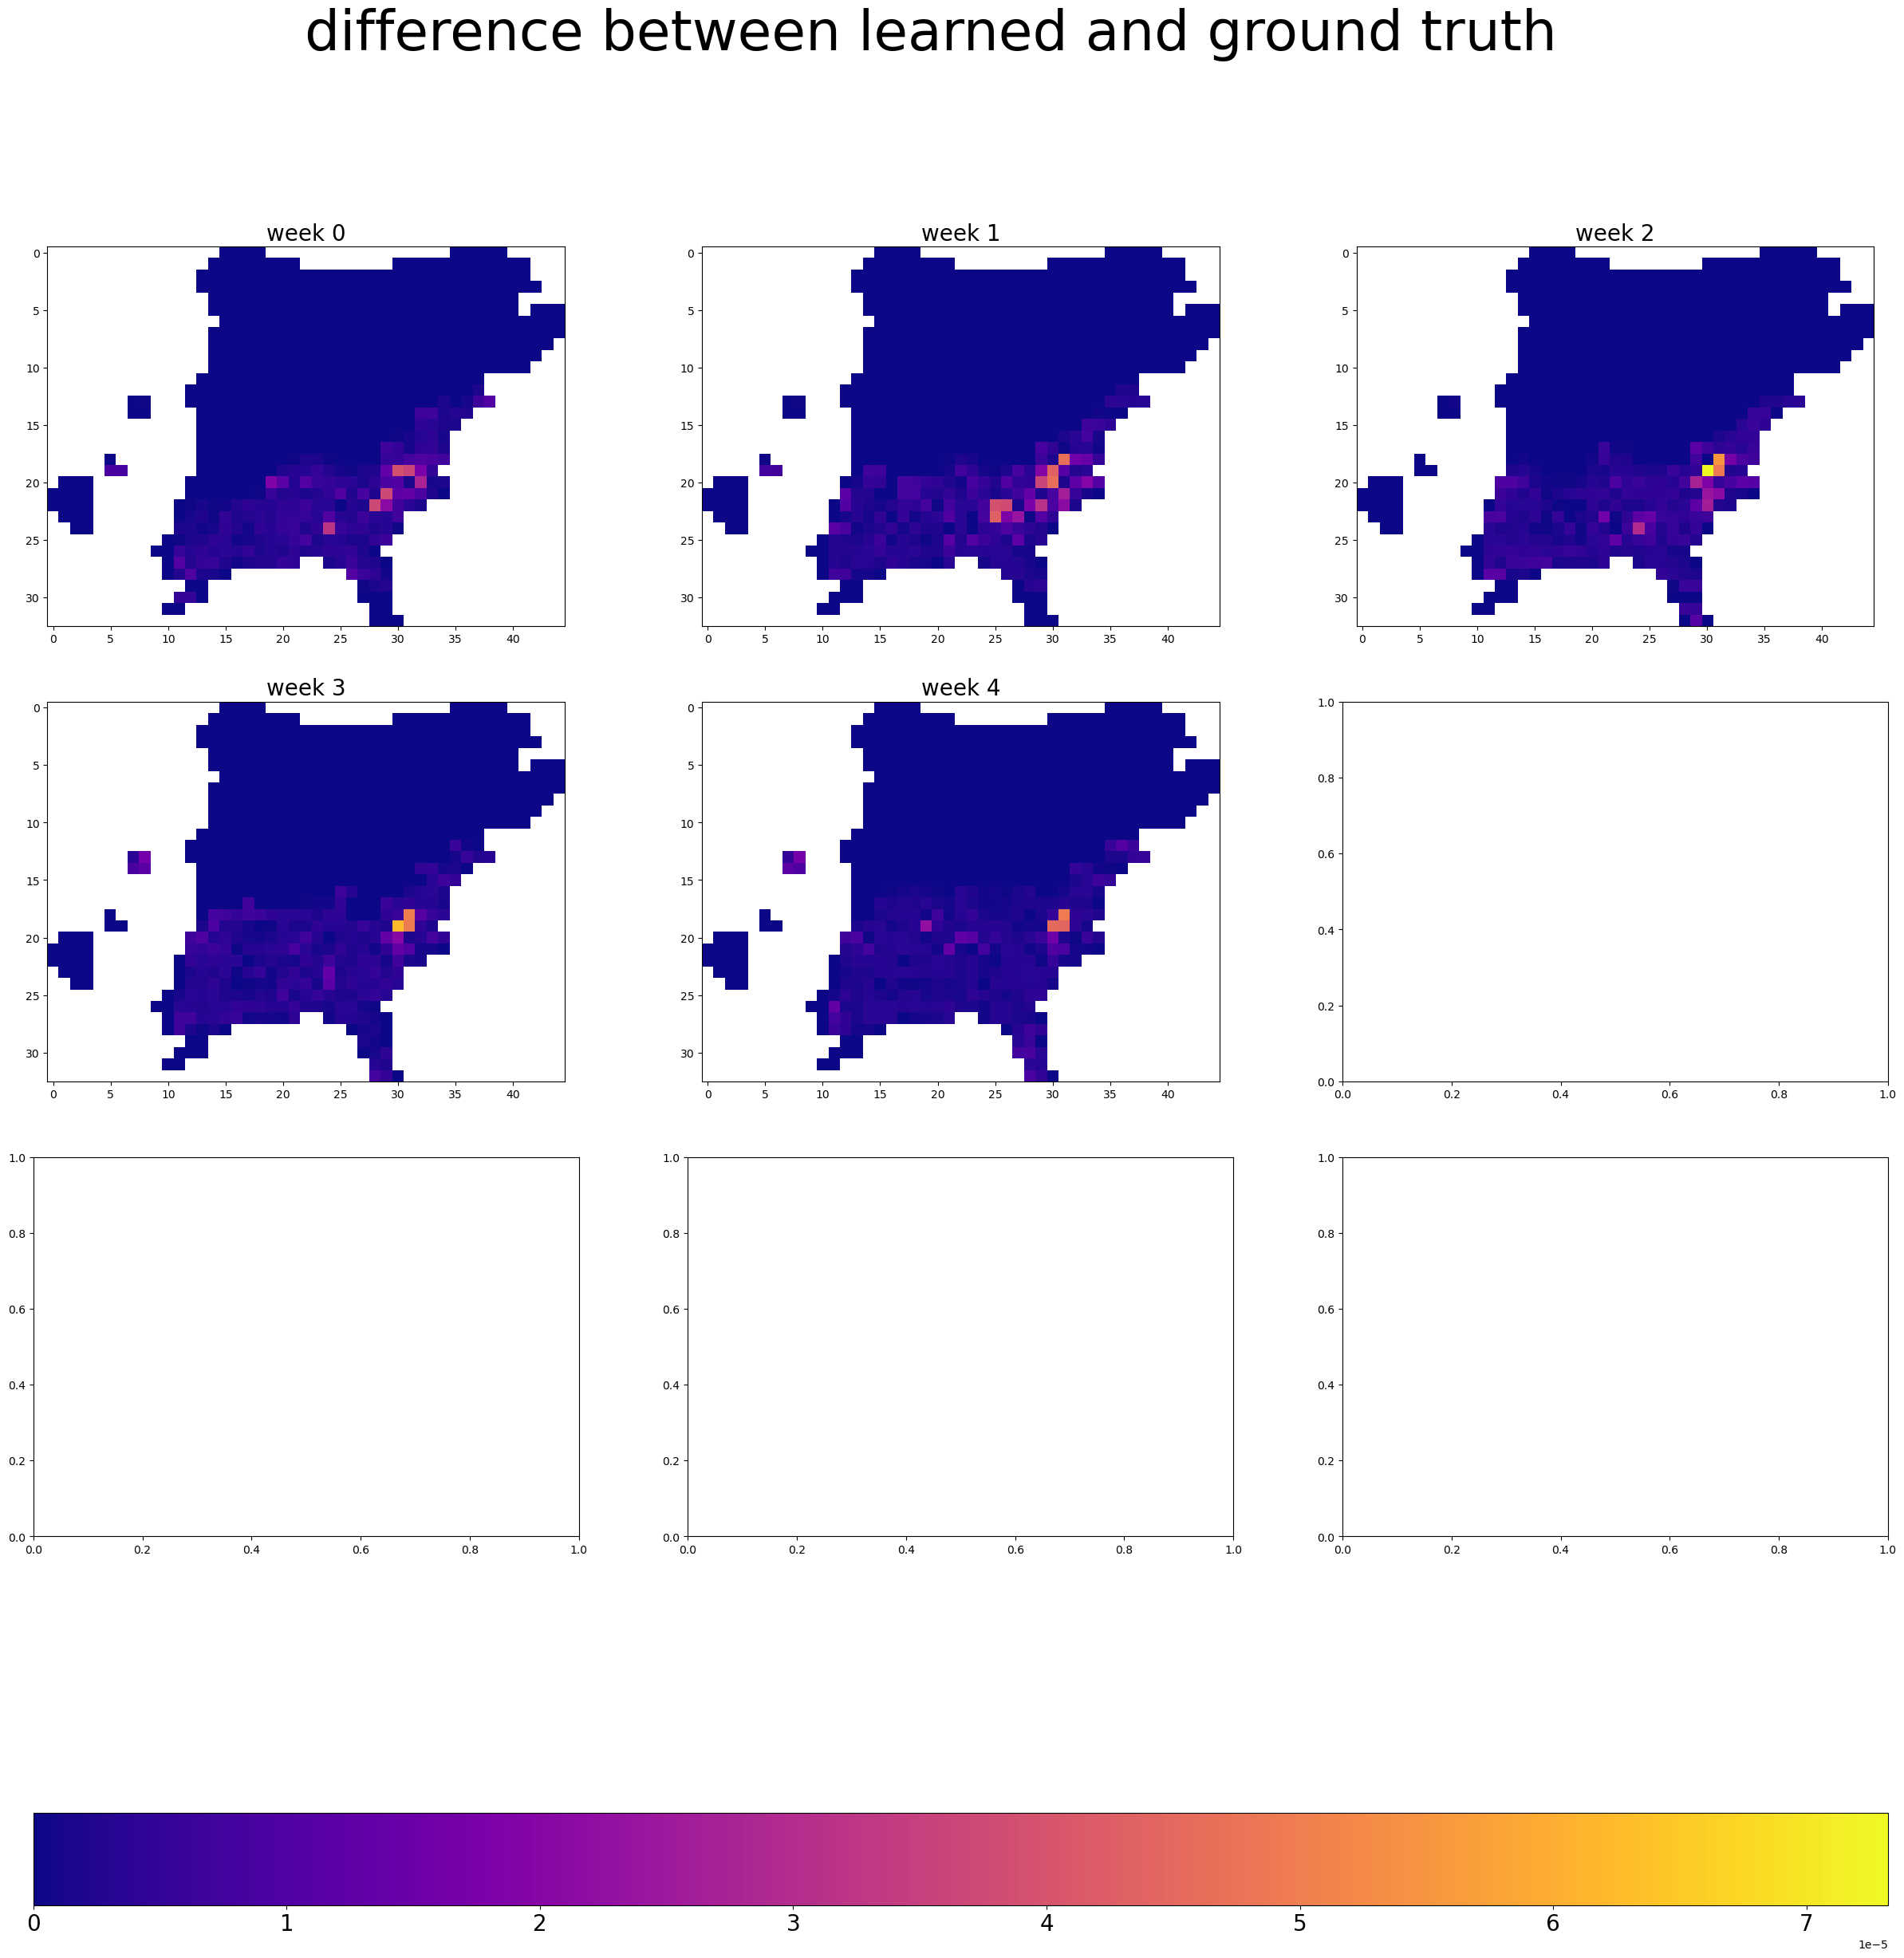

In [ ]:
# plot difference between learned and ground truth for each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, trimmed_masked_densities)])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(trimmed_masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_learned - grid_true)
    pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=20)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=50)

plt.show()

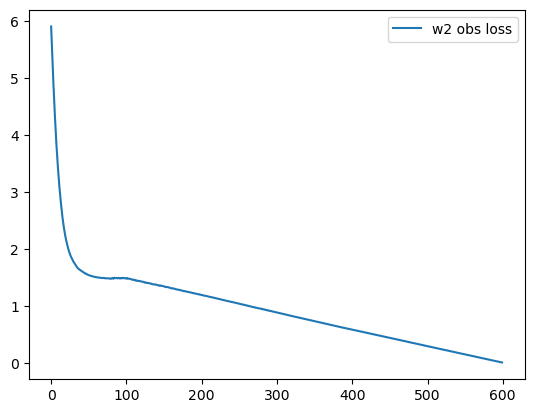

In [ ]:
num_iters = len(loss_dict['total'])
plt.plot(jnp.arange(num_iters), loss_dict['w2_obs'], label='w2 obs loss')
#plt.plot(jnp.arange(num_iters), loss_dict['l2_obs'], label='l2 obs loss')
plt.legend()
plt.show()

### Experiment 4.2
- Train model with w2 obs loss
- 26 weeks of s&t data
- ow: 1, ew: 1e-4, dw: 1e-2, dp: 0.4
- Random initialization
- Training time: 30 mins (~3 sec per iteration)

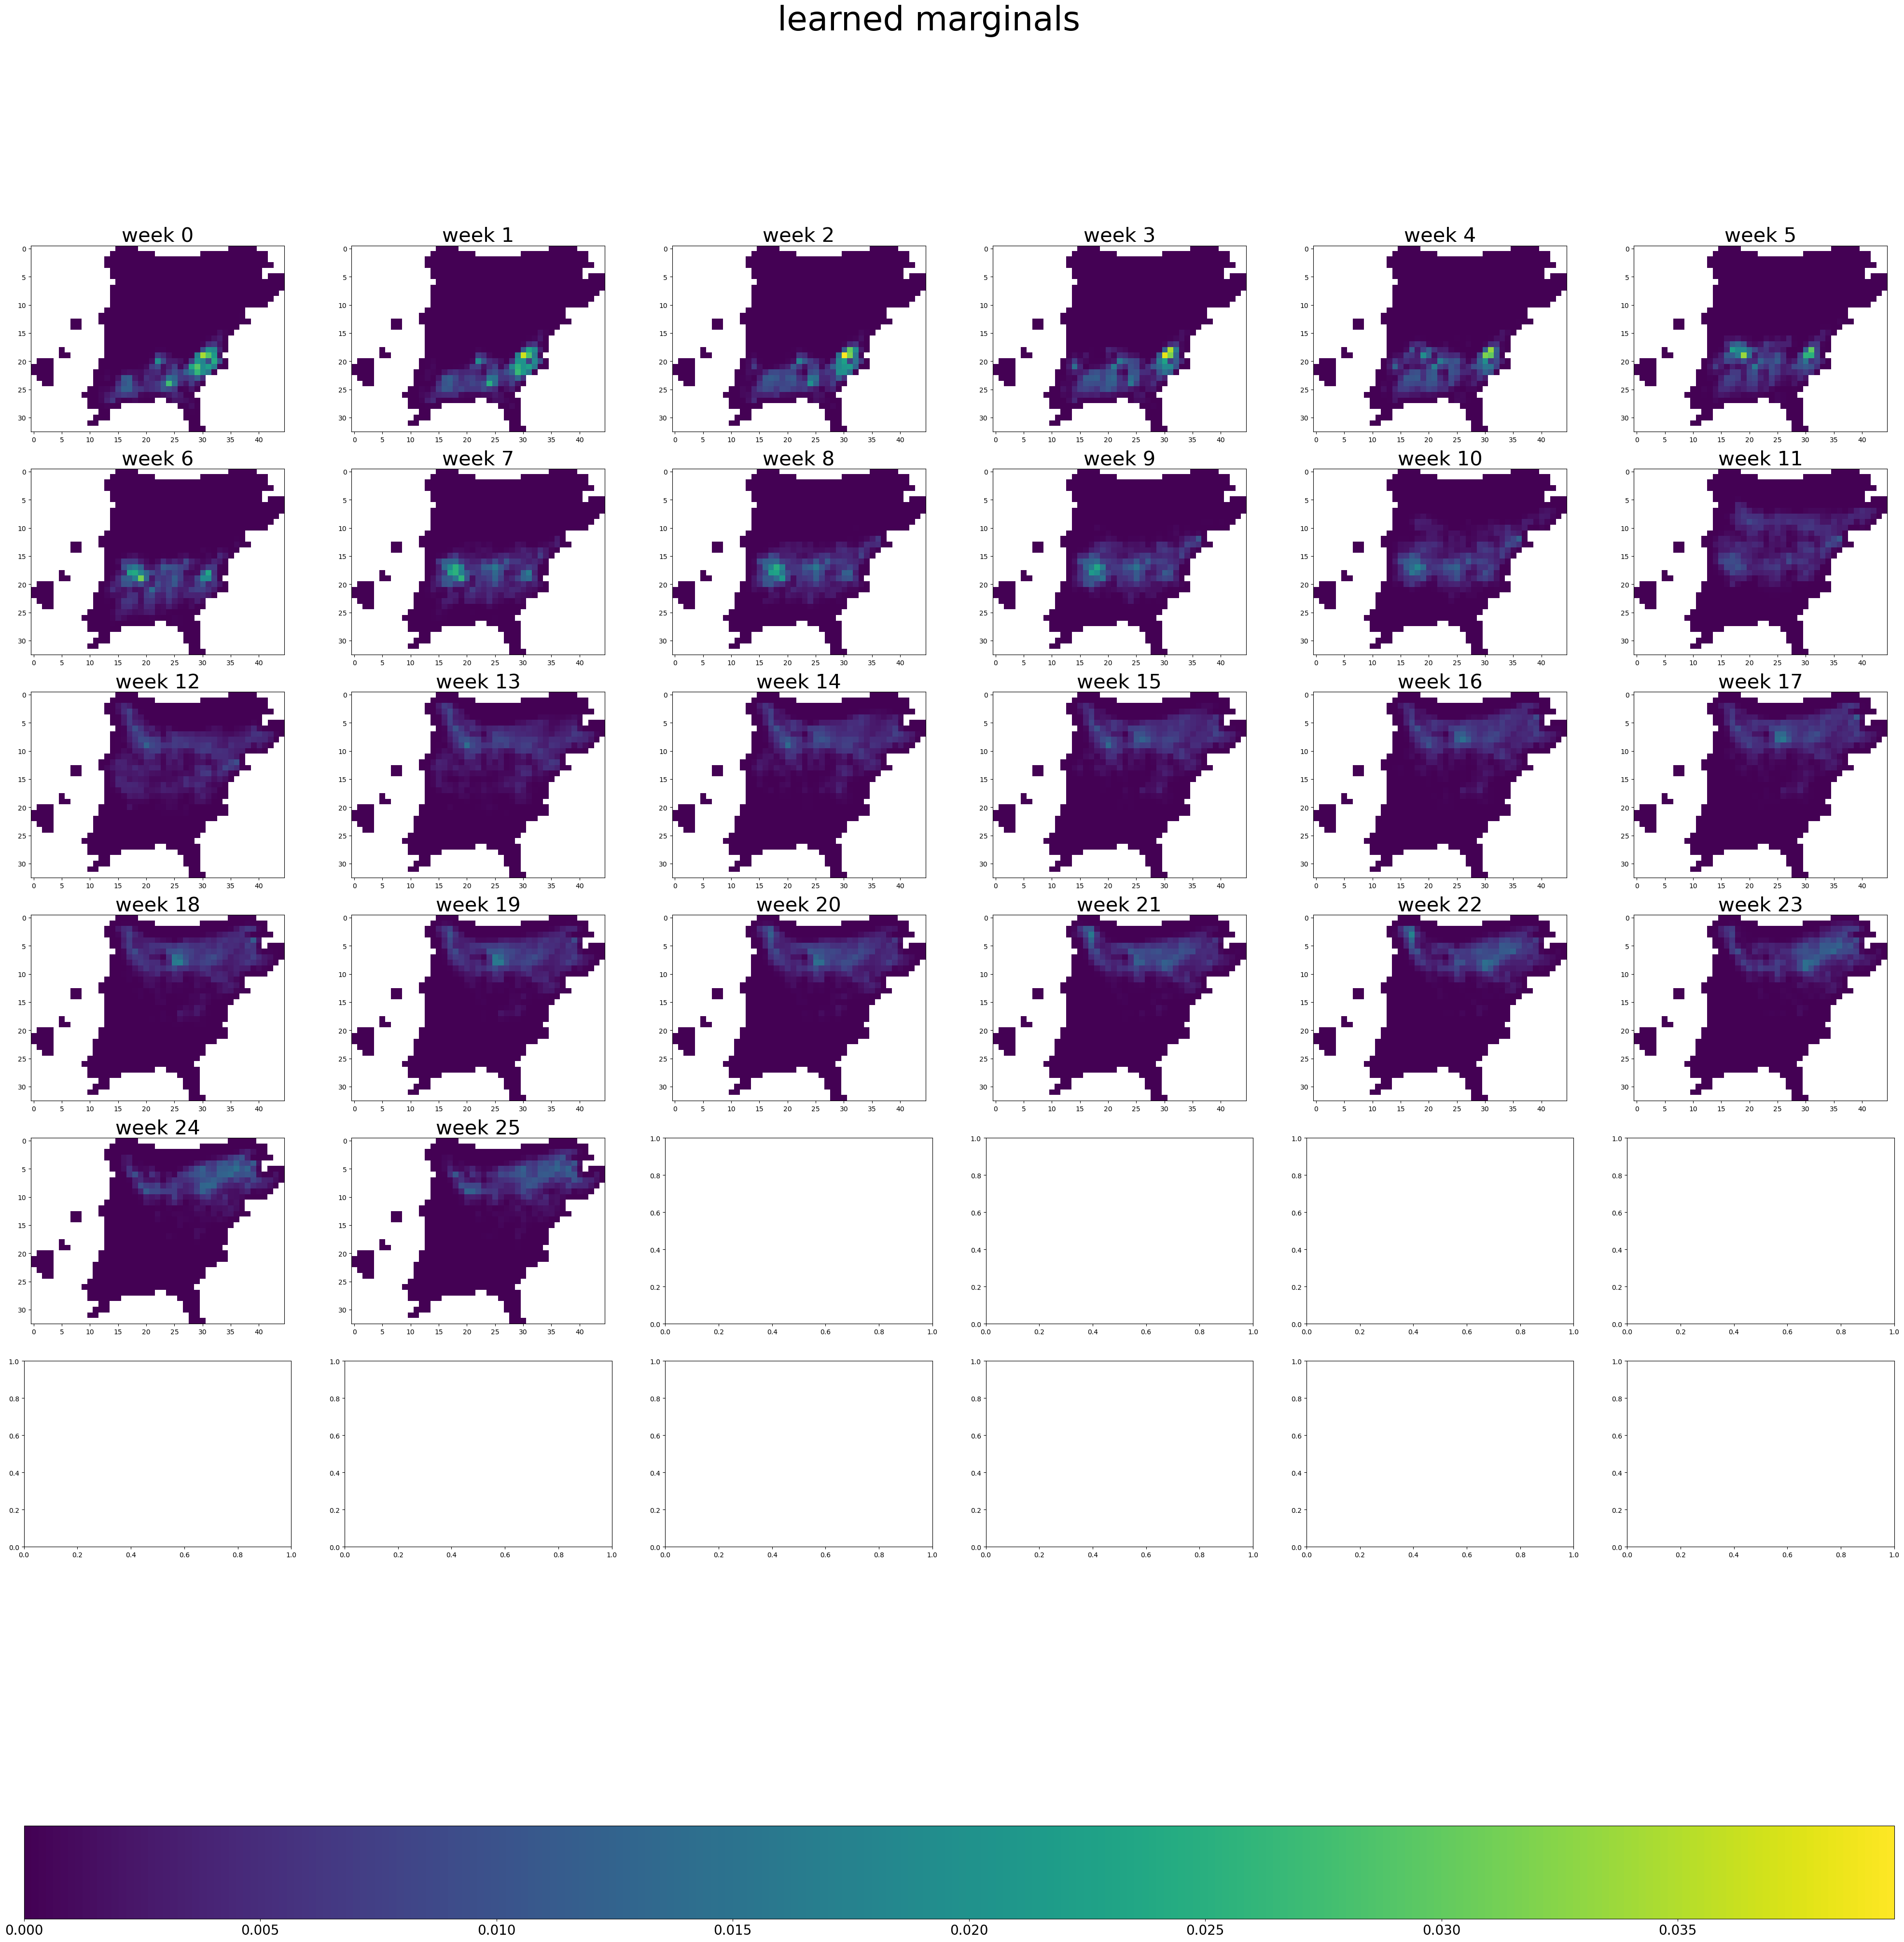

In [ ]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'ex42_w2_params_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex42_w2_losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    loss_dict = pickle.load(f)

hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(len(params) - 1):
        z = params[f'Flow_Model/Week_{week + 1}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(6, 6, figsize=(50, 50))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in marginals])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=30)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()

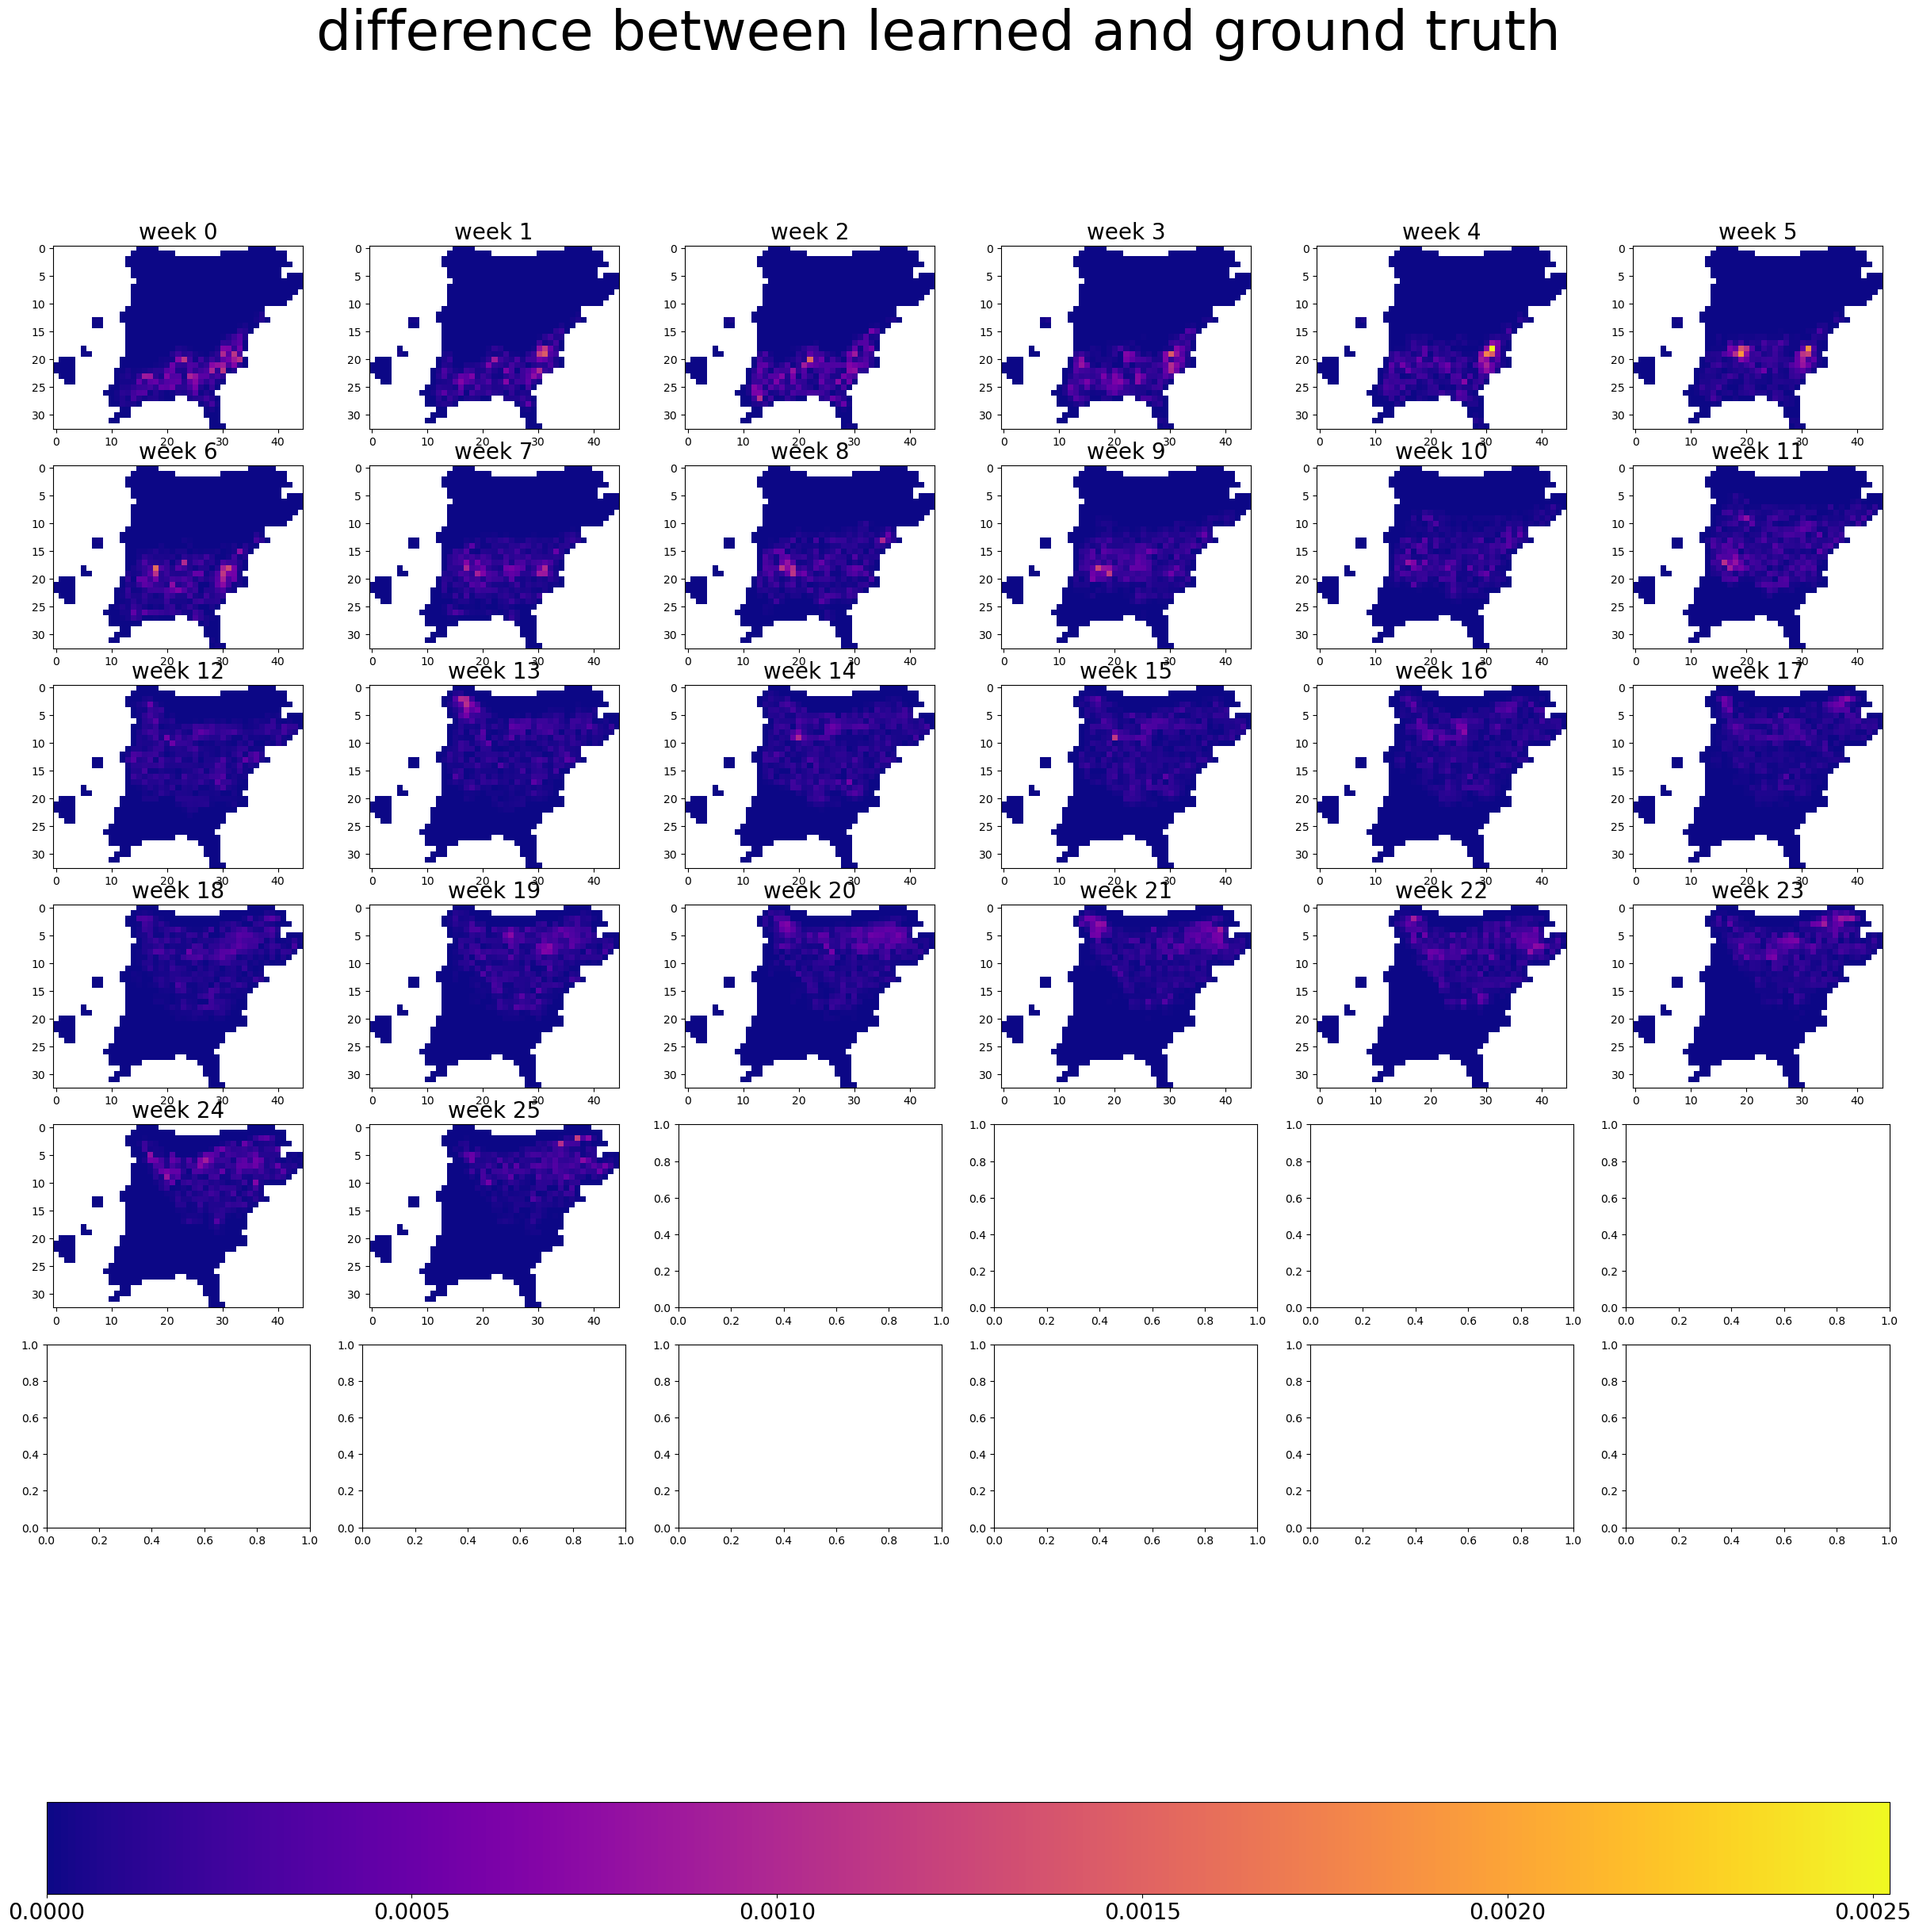

In [ ]:
# plot difference between learned and ground truth for each week
trimmed_masked_densities = masked_densities[:len(params)]
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(6, 6, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, trimmed_masked_densities)])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(trimmed_masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_learned - grid_true)
    pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=20)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=50)

plt.show()

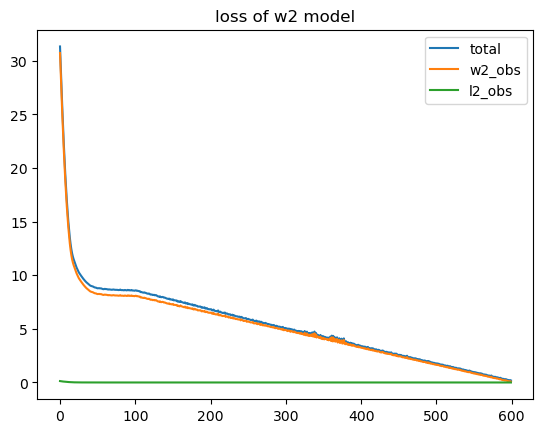

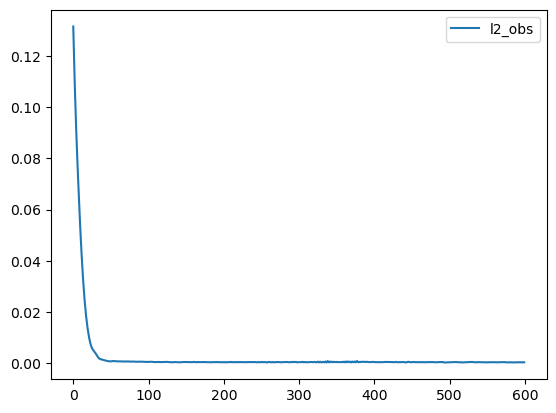

In [ ]:
plt.figure(0)
plt.title("loss of w2 model")
iters = jnp.arange(0, len(loss_dict['total']))
plt.plot(iters, loss_dict['total'], label='total')
plt.plot(iters, loss_dict['w2_obs'], label='w2_obs')
plt.plot(iters, loss_dict['l2_obs'], label='l2_obs')
plt.legend()
plt.figure(1)
plt.plot(iters, loss_dict['l2_obs'], label='l2_obs')
plt.legend()
plt.show()

### Experiment 4.3
- Train model with w2 obs loss
- 2100 iterations
- 26 weeks of s&t data
- ow: 1, ew: 1e-4, dw: 1e-2, dp: 0.4
- Random initialization
- Training time: 2h (~3 sec per iteration)

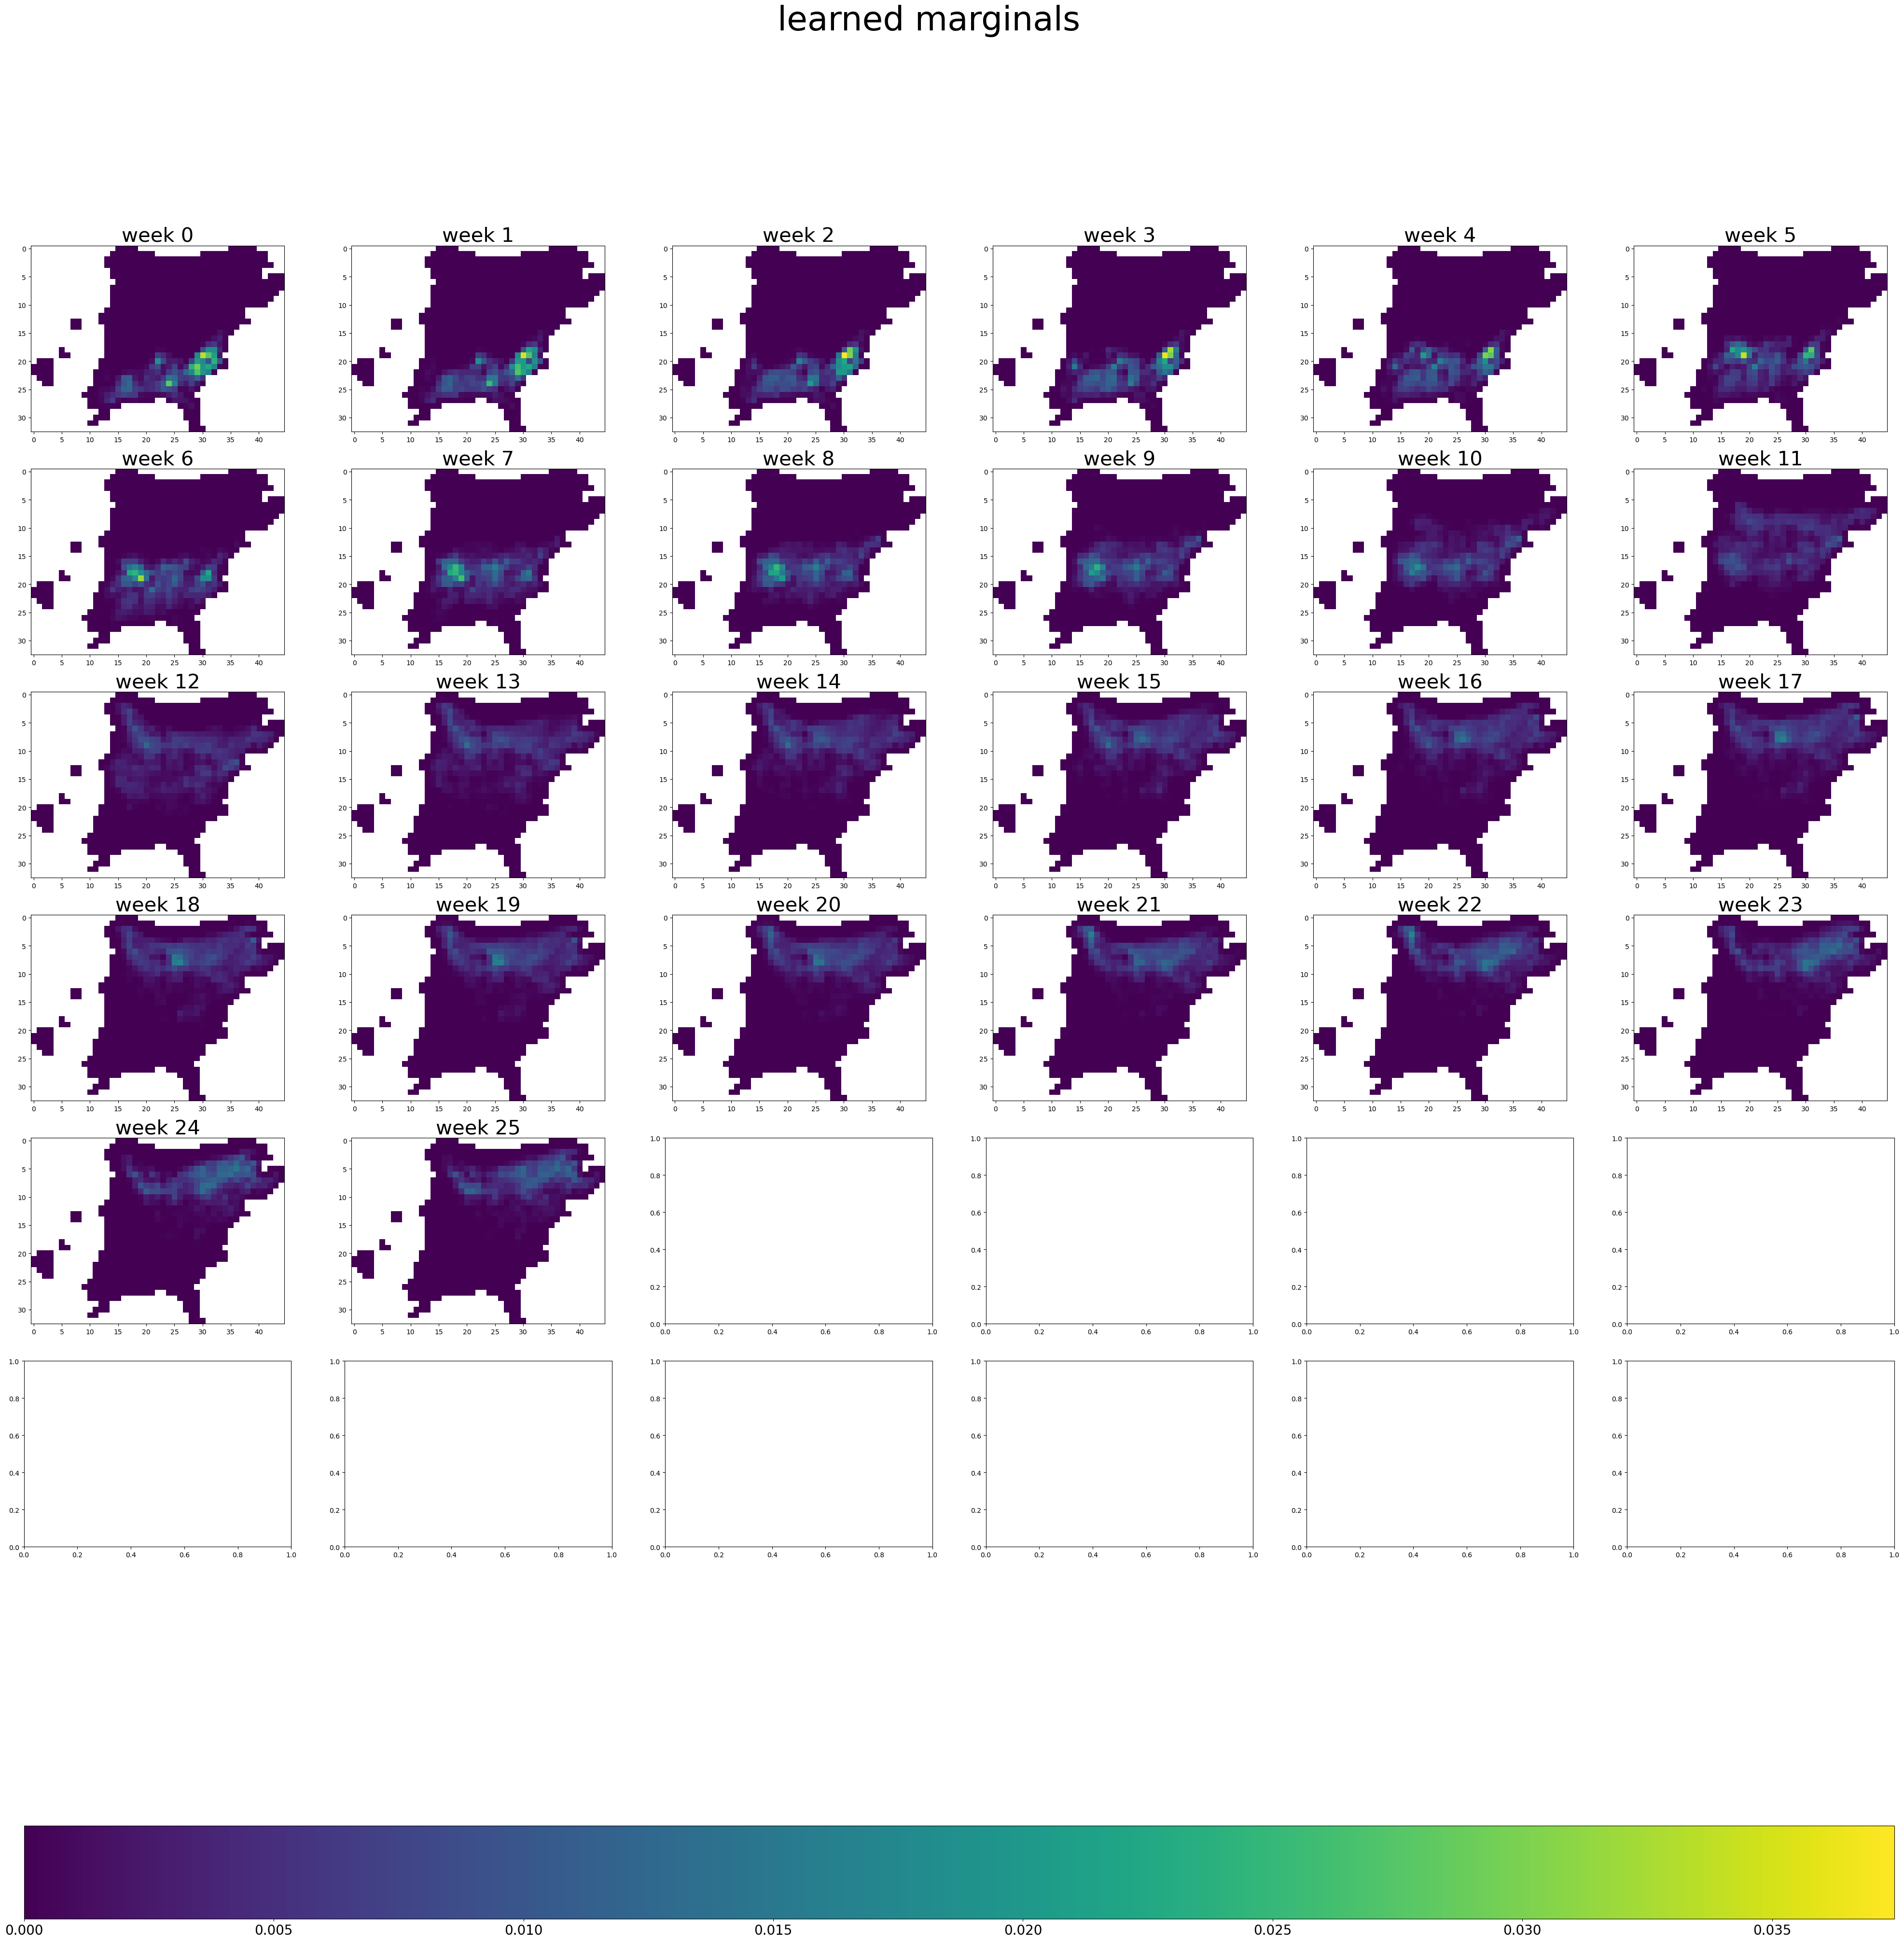

In [ ]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'ex43_w2_params_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex43_w2_losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    loss_dict = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex42_w2_losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    ex42_loss_dict = pickle.load(f)

hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(len(params) - 1):
        z = params[f'Flow_Model/Week_{week + 1}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(6, 6, figsize=(50, 50))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in marginals])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=30)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()

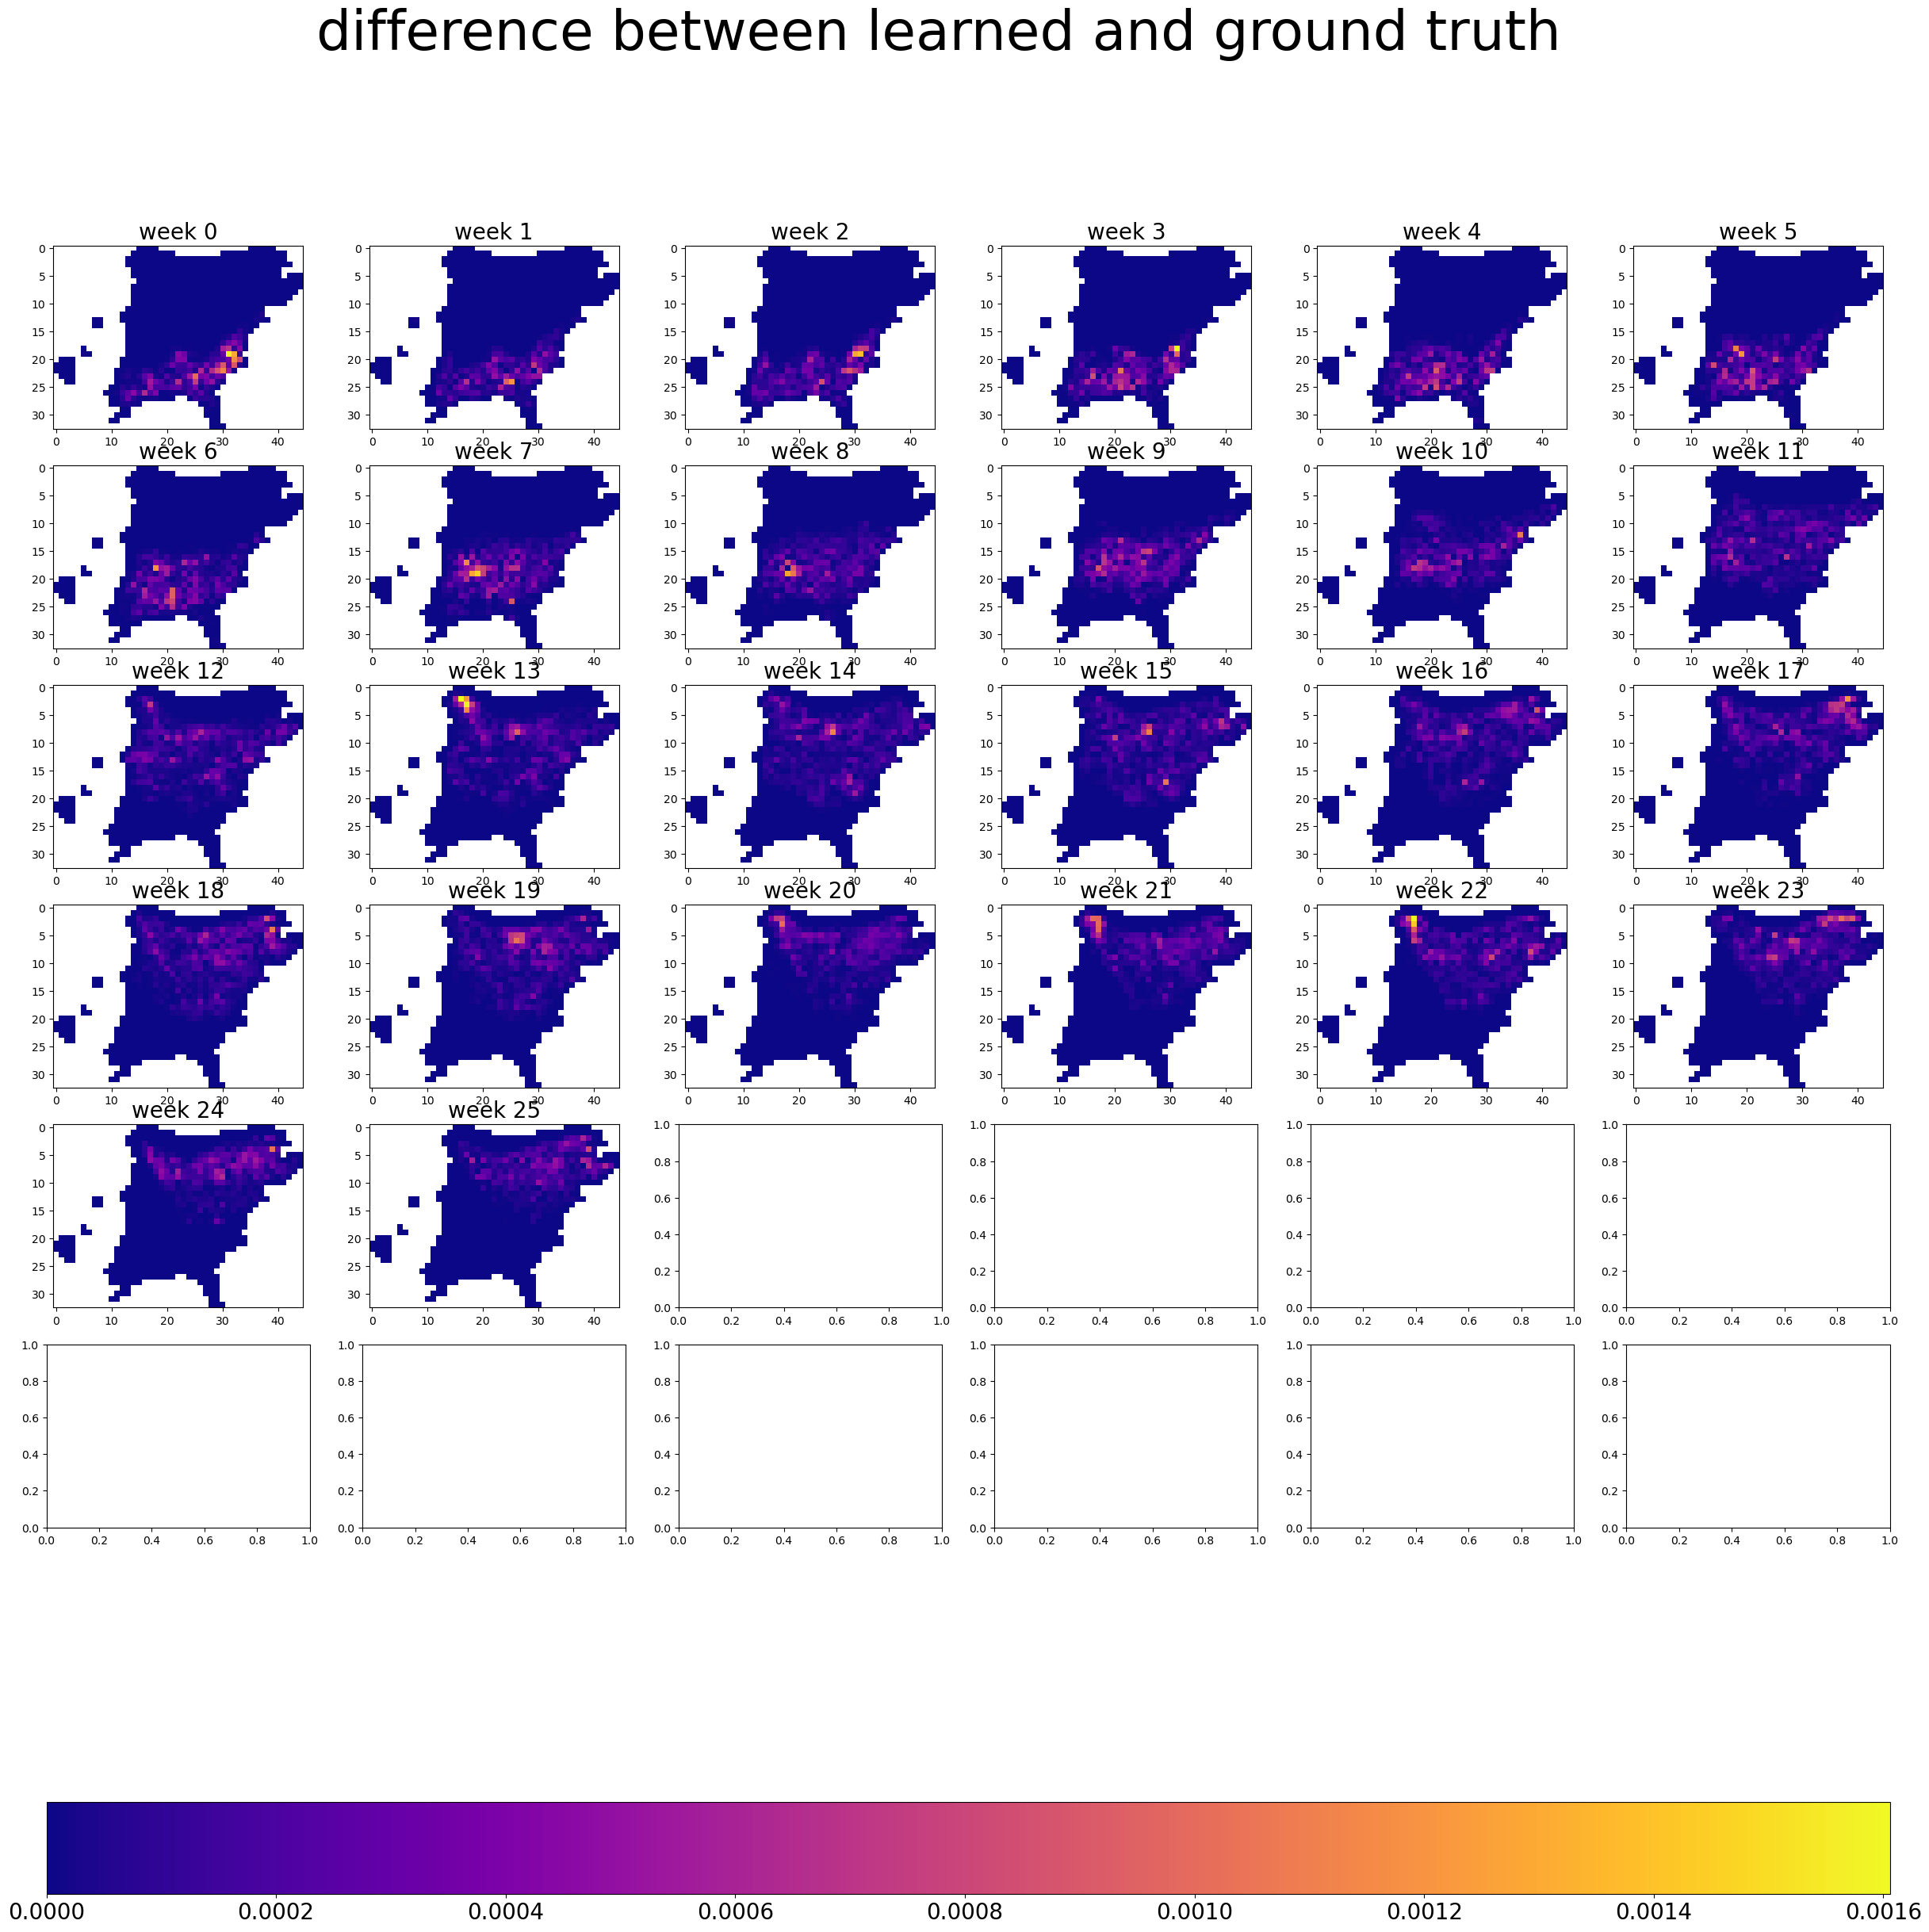

In [ ]:
# plot difference between learned and ground truth for each week
trimmed_masked_densities = masked_densities[:len(params)]
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(6, 6, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, trimmed_masked_densities)])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(trimmed_masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_learned - grid_true)
    pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=20)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=50)

plt.show()

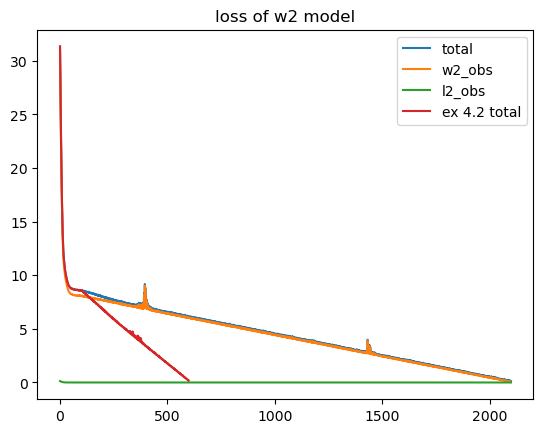

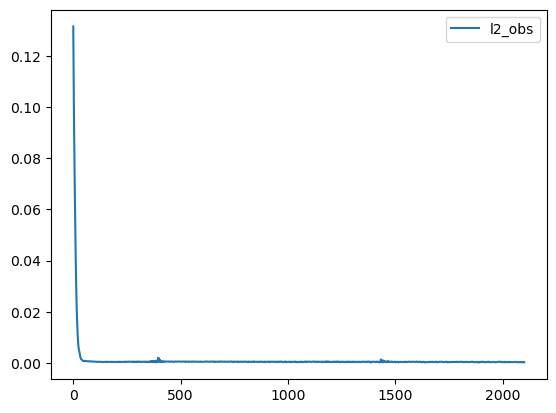

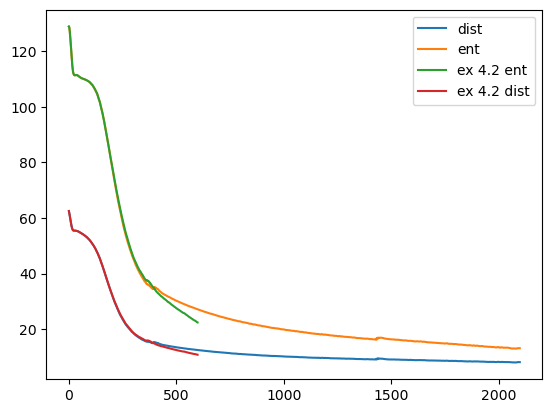

In [ ]:
plt.figure(0)
plt.title("loss of w2 model")
iters = jnp.arange(0, len(loss_dict['total']))
ex_42_iters = jnp.arange(0, len(ex42_loss_dict['total']))
plt.plot(iters, loss_dict['total'], label='total')
plt.plot(iters, loss_dict['w2_obs'], label='w2_obs')
plt.plot(iters, loss_dict['l2_obs'], label='l2_obs')
plt.axvline(x=100, color='r', linestyle='--', linewidth=2)
plt.plot(jnp.arange(0, len(ex42_loss_dict['total'])), ex42_loss_dict['total'], label='ex 4.2 total')
plt.legend()
plt.figure(1)
plt.plot(iters, loss_dict['l2_obs'], label='l2_obs')
plt.legend()
plt.figure(2)
plt.plot(iters, loss_dict['dist'], label='dist')
plt.plot(iters, loss_dict['ent'], label='ent')
plt.plot(ex_42_iters, ex42_loss_dict['ent'], label='ex 4.2 ent')
plt.plot(ex_42_iters, ex42_loss_dict['dist'], label='ex 4.2 dist')
plt.legend()
plt.show()

### Experiment 4.4
- 5000 iterations
- 26 weeks of s&t data
- ow: 1, ew: 1e-4, dw: 1e-2, dp: 0.4
- Random initialization
- Training time: 4h (~3 sec per iteration)

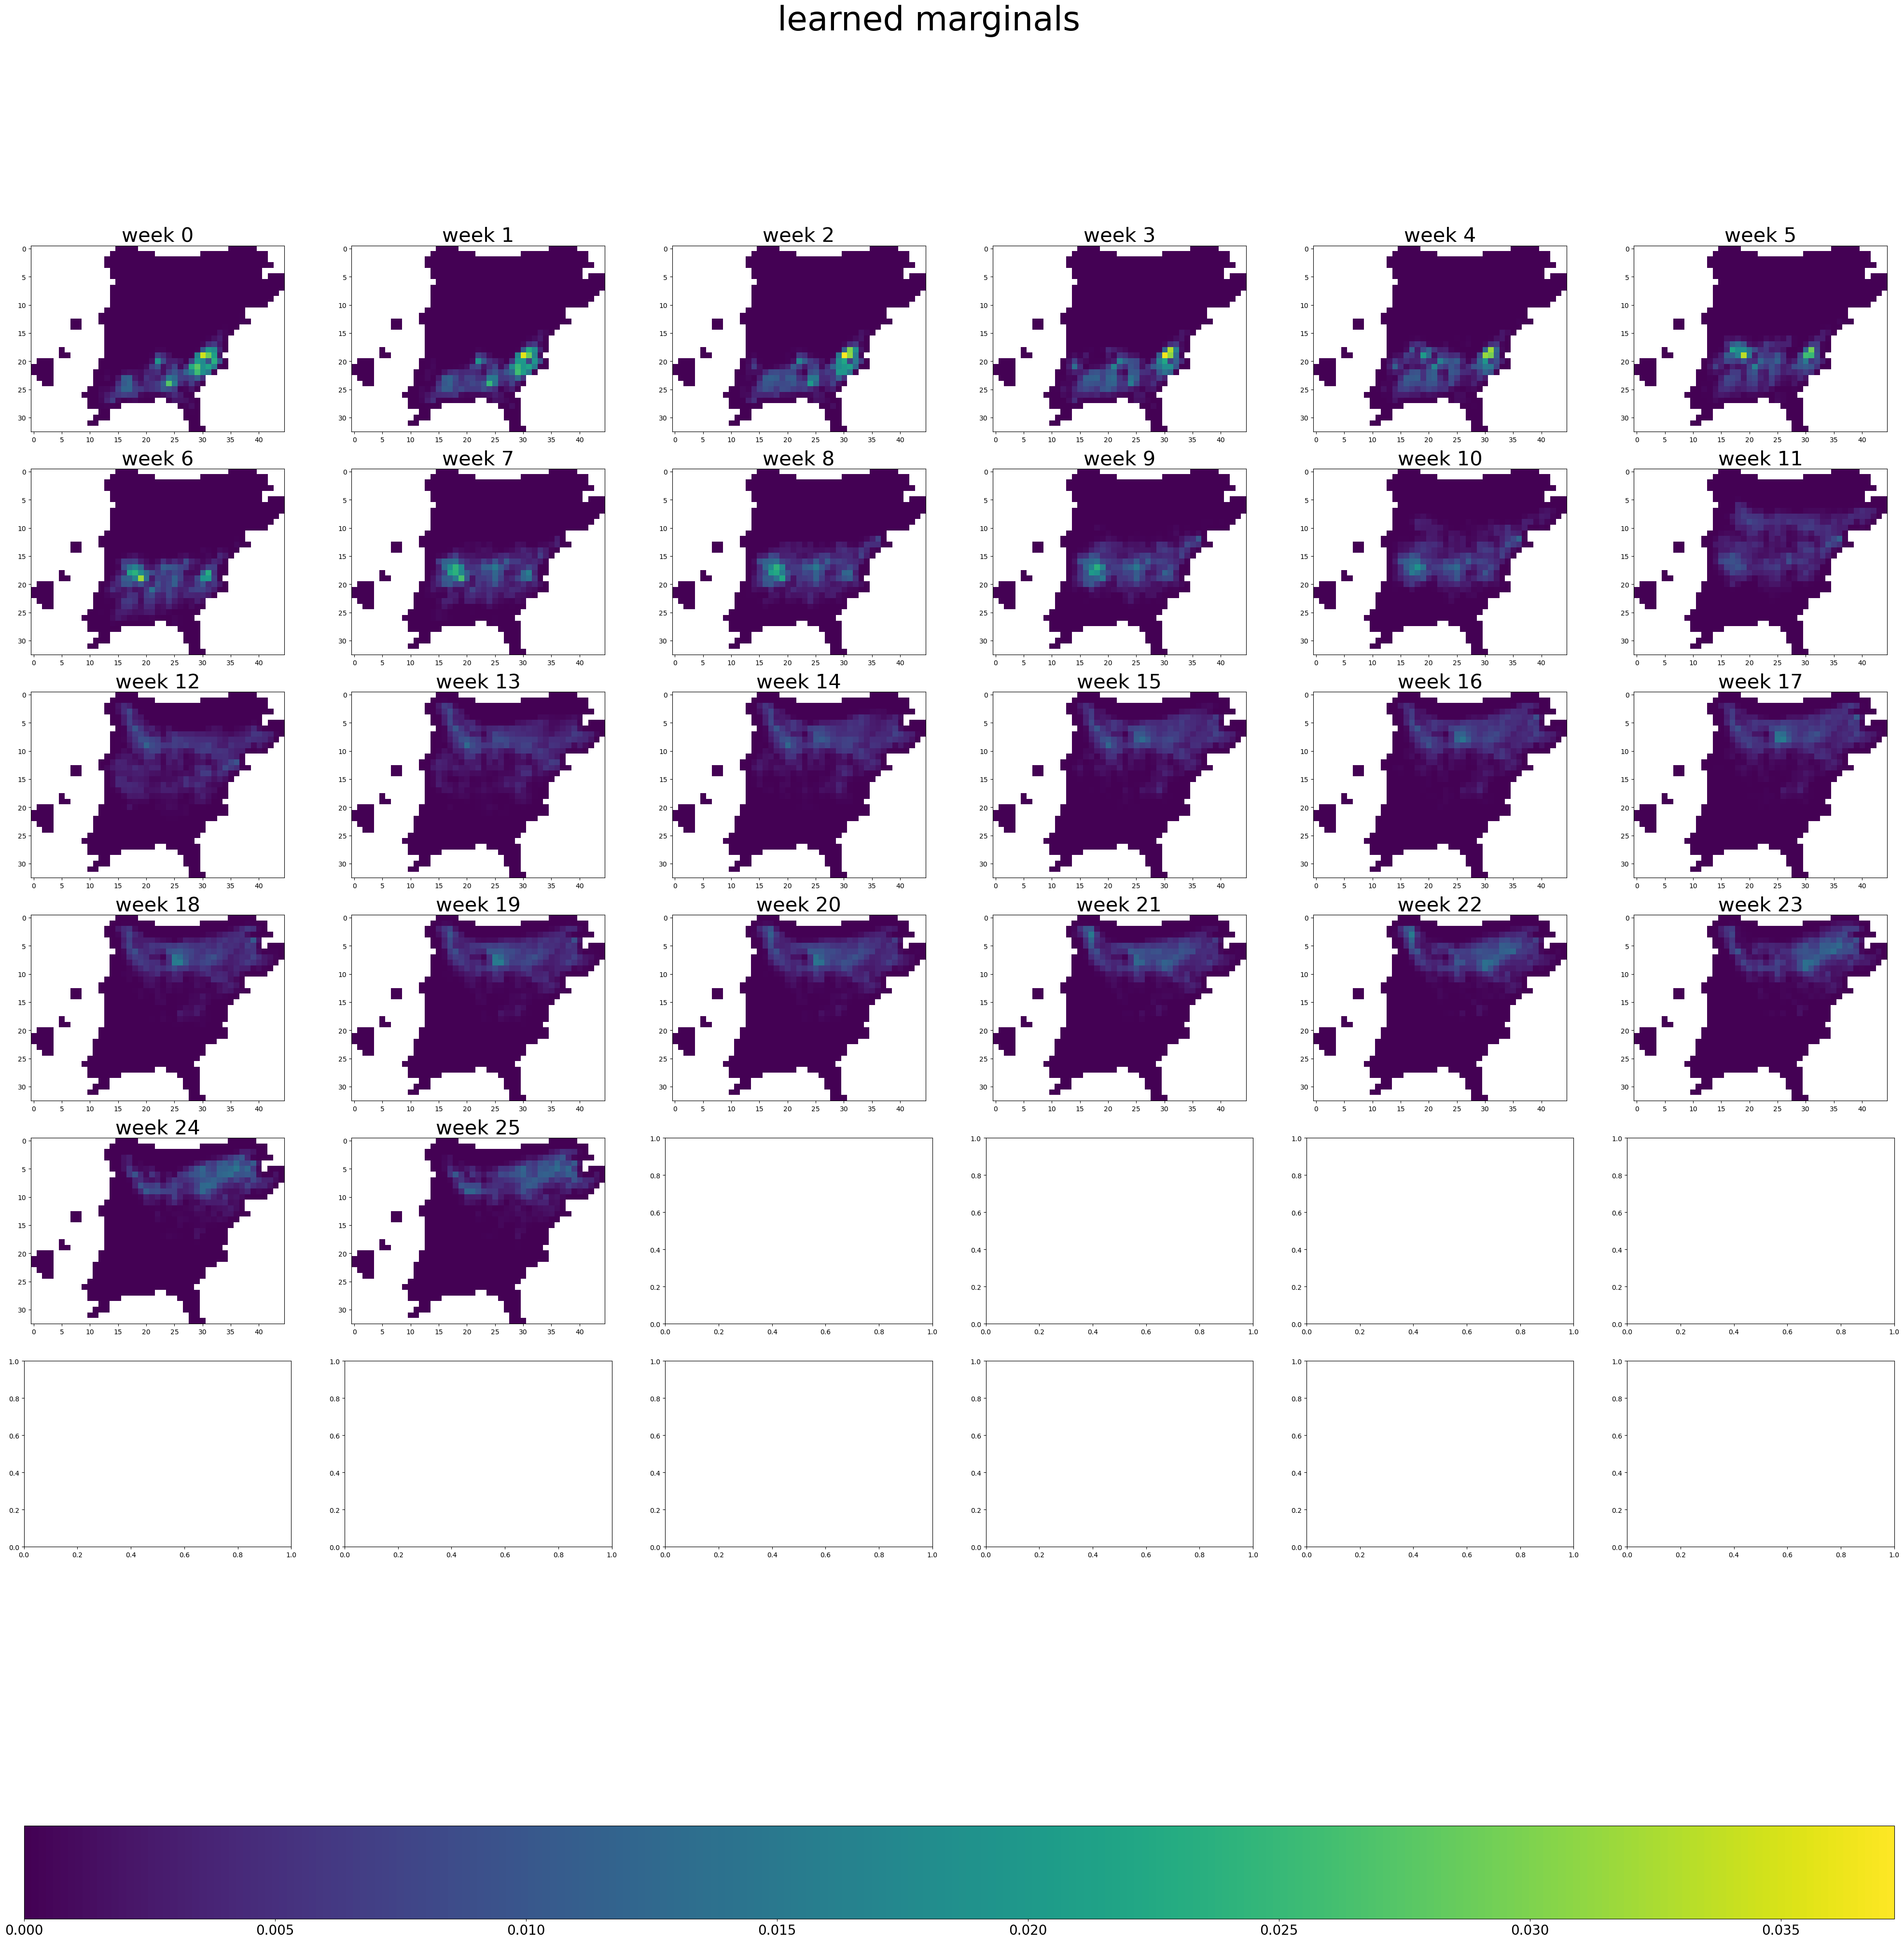

In [ ]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'ex44_w2_params_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex44_w2_losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    loss_dict = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex43_w2_losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    ex43_loss_dict = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex42_rerun_w2_losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    ex42_rerun_loss_dict = pickle.load(f)
    
with open(os.path.join(experiment_dir, 'ex42_w2_losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    ex42_loss_dict = pickle.load(f)

hdf_src = 'birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(len(params) - 1):
        z = params[f'Flow_Model/Week_{week + 1}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(6, 6, figsize=(50, 50))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in marginals])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=30)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()

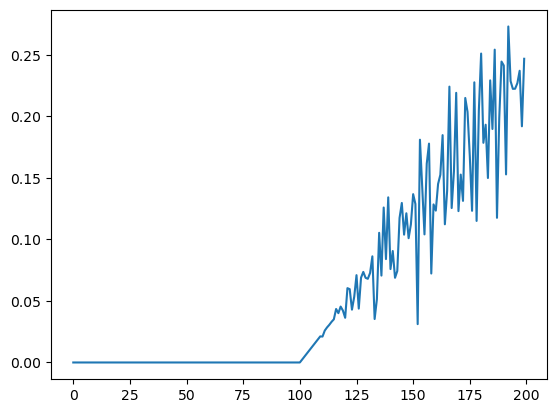

In [ ]:
loss_diffs = jnp.array(loss_dict['total'][:200]) - jnp.array(ex43_loss_dict['total'][:200])
#print(loss_diffs)
plt.plot(jnp.arange(0, 200), loss_diffs)

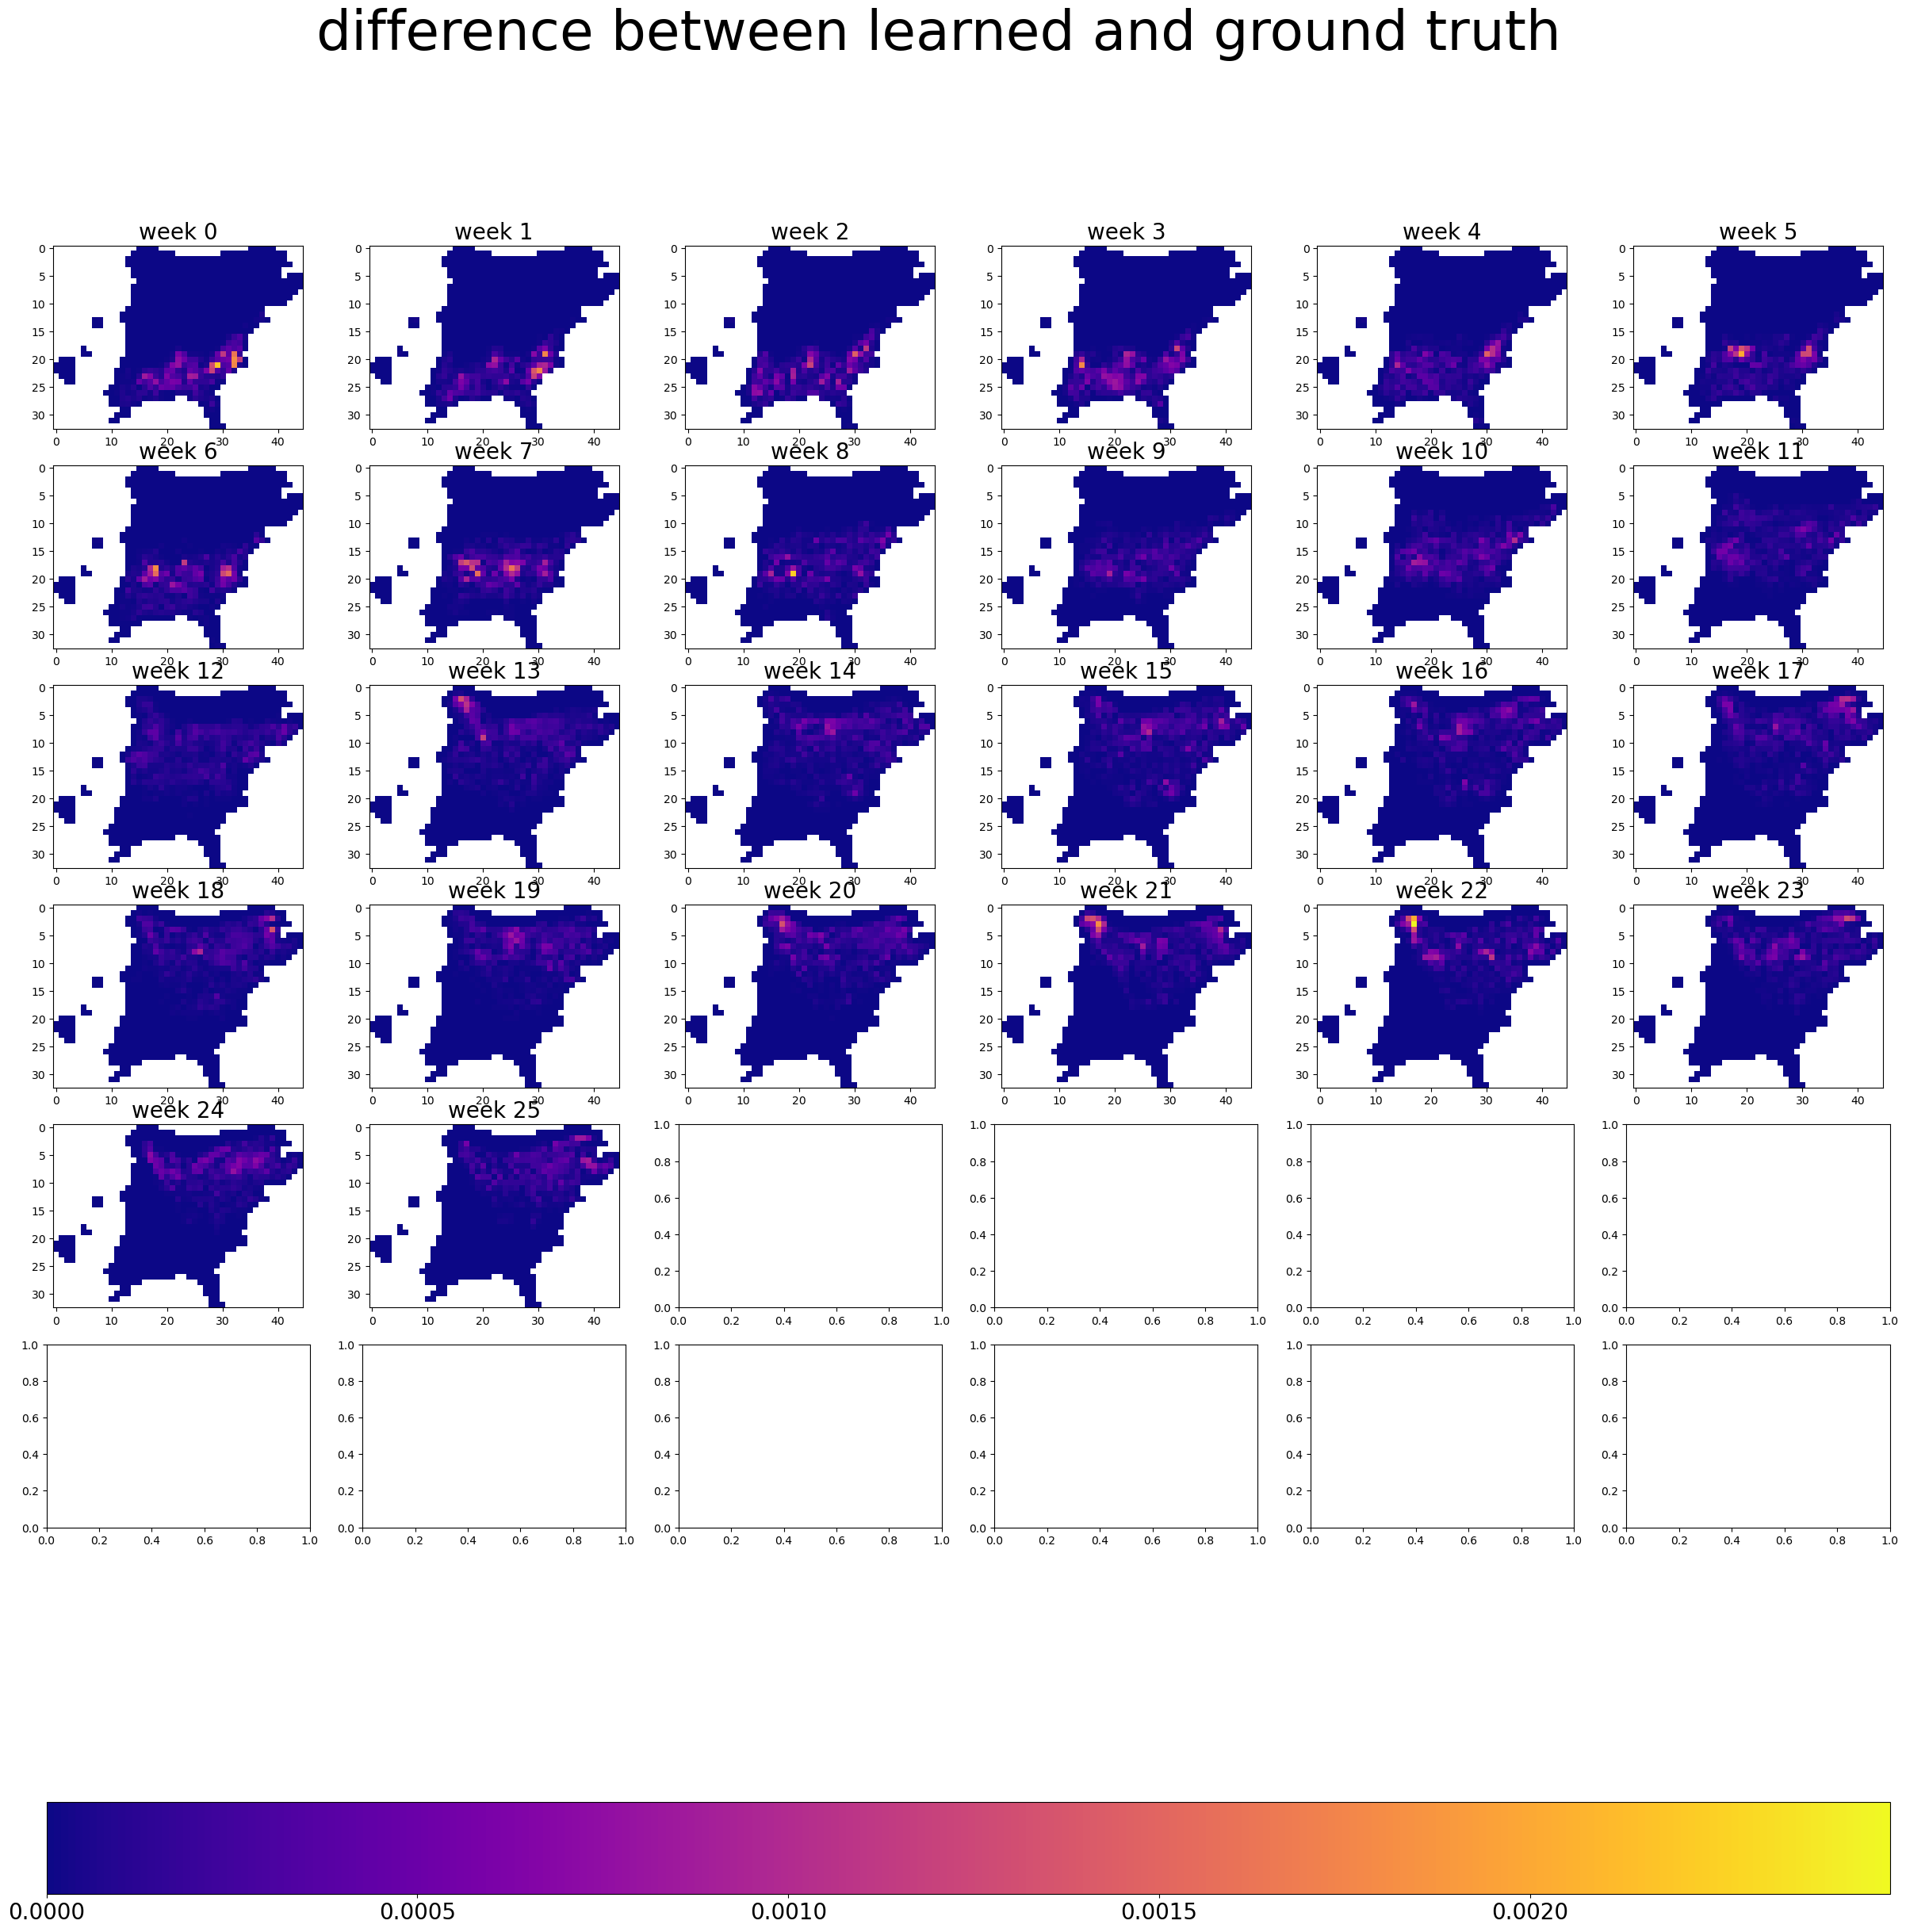

In [ ]:
# plot difference between learned and ground truth for each week
trimmed_masked_densities = masked_densities[:len(params)]
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(6, 6, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, trimmed_masked_densities)])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(trimmed_masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_learned - grid_true)
    pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=20)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=50)

plt.show()

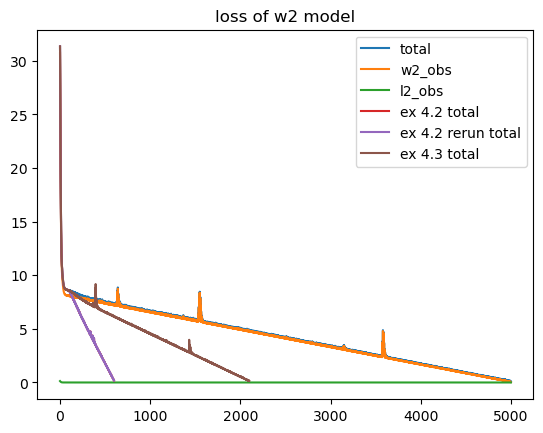

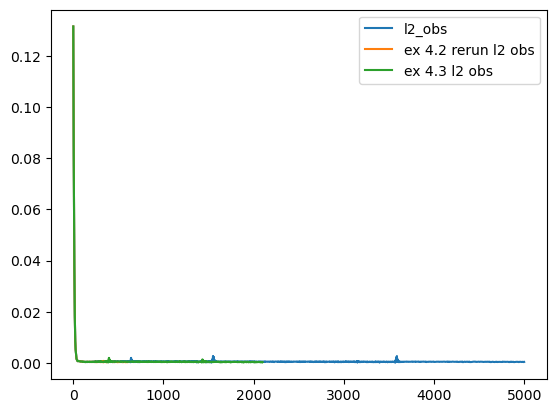

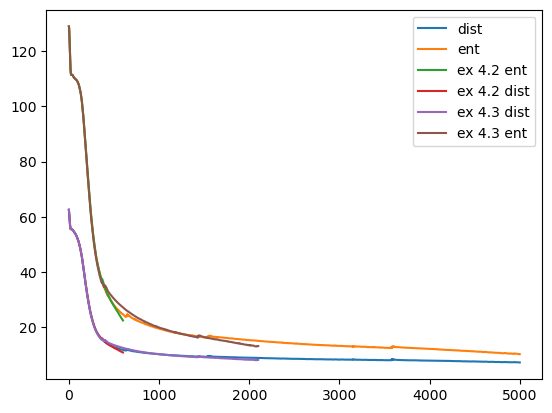

In [ ]:
plt.figure(0)
plt.title("loss of w2 model")
iters = jnp.arange(0, len(loss_dict['total']))
ex_42_iters = jnp.arange(0, len(ex42_loss_dict['total']))
ex_43_iters = jnp.arange(0, len(ex43_loss_dict['total']))
plt.plot(iters, loss_dict['total'], label='total')
plt.plot(iters, loss_dict['w2_obs'], label='w2_obs')
plt.plot(iters, loss_dict['l2_obs'], label='l2_obs')
plt.plot(ex_42_iters, ex42_loss_dict['total'], label='ex 4.2 total')
plt.plot(ex_42_iters, ex42_rerun_loss_dict['total'], label='ex 4.2 rerun total')
plt.plot(ex_43_iters, ex43_loss_dict['total'], label='ex 4.3 total')
plt.legend()
plt.figure(1)
plt.plot(iters, loss_dict['l2_obs'], label='l2_obs')
plt.plot(ex_42_iters, ex42_rerun_loss_dict['l2_obs'], label='ex 4.2 rerun l2 obs')
plt.plot(ex_43_iters, ex43_loss_dict['l2_obs'], label='ex 4.3 l2 obs')
plt.legend()
plt.figure(2)
plt.plot(iters, loss_dict['dist'], label='dist')
plt.plot(iters, loss_dict['ent'], label='ent')
plt.plot(ex_42_iters, ex42_loss_dict['ent'], label='ex 4.2 ent')
plt.plot(ex_42_iters, ex42_loss_dict['dist'], label='ex 4.2 dist')
plt.plot(ex_43_iters, ex43_loss_dict['dist'], label='ex 4.3 dist')
plt.plot(ex_43_iters, ex43_loss_dict['ent'], label="ex 4.3 ent")
plt.legend()
plt.show()

### Experiment 4.5
- Using 2x the default epsilons for each week, epsilon decay to 0.01x the default epsilons 100 iterations before final iteration
- 26 weeks of s&t data
- ow: 1, ew: 1e-4, dw: 1e-2, dp: 0.4
- Random initialization
- 1000, 2500, 5000 training steps

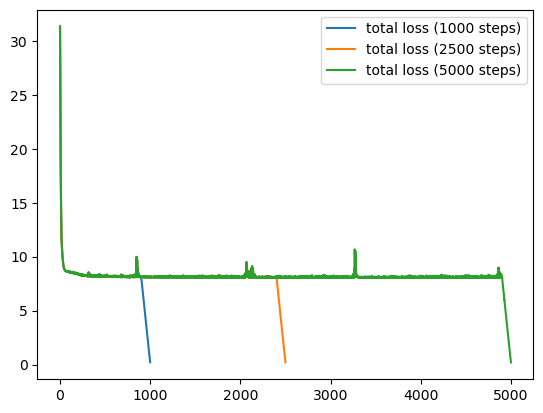

In [ ]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'ex45_steps1000_w2_losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    loss_dict1000 = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex45_steps2500_w2_losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    loss_dict2500 = pickle.load(f)

with open(os.path.join(experiment_dir, 'ex45_steps5000_w2_losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    loss_dict5000 = pickle.load(f)

plt.plot(jnp.arange(1000), loss_dict1000['total'], label='total loss (1000 steps)')
plt.plot(jnp.arange(2500), loss_dict2500['total'], label='total loss (2500 steps)')
plt.plot(jnp.arange(5000), loss_dict5000['total'], label='total loss (5000 steps)')
plt.legend()
plt.show()


### Experiment 4.6
- Train model with w2 obs loss
- Improved epsilon scheduler (2 * `EPS_DEFAULT` for first 200 steps, decay to 0.01 * `EPS_DEFAULT` over next 100 training steps, remain at 0.01 * `EPS_DEFAULT` for last 1000 steps)
- 26 weeks of s&t data
- w2 obs weight: 1, ent weight: 1e-4, dist weight: 1e-2, dp: 0.4
- Random initialization
- 1000 training steps
- Training time: 1hr

[0.01000003]


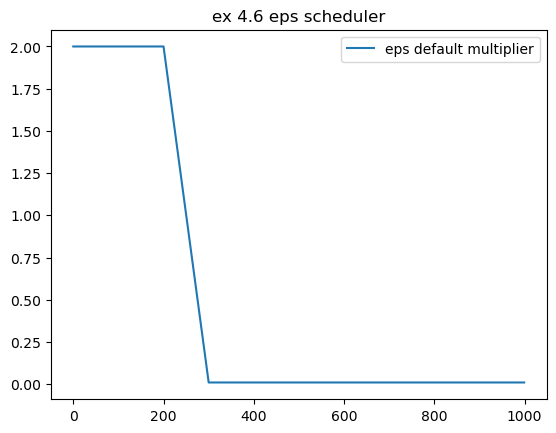

In [168]:
from flow_model_training import Scheduler

# the epsilon scheduler
eps_default = 1.0
ex46_scheduler = Scheduler(eps_default, 2, 0.01, 100, 200)
get_epsilons = jax.vmap(jax.jit(ex46_scheduler.get_epsilon))
print(get_epsilons(jnp.array([300])))
iters_arr = jnp.arange(1000)
plt.plot(iters_arr, get_epsilons(iters_arr), label=f'eps default multiplier')
plt.title("ex 4.6 eps scheduler")
plt.legend()
plt.show()

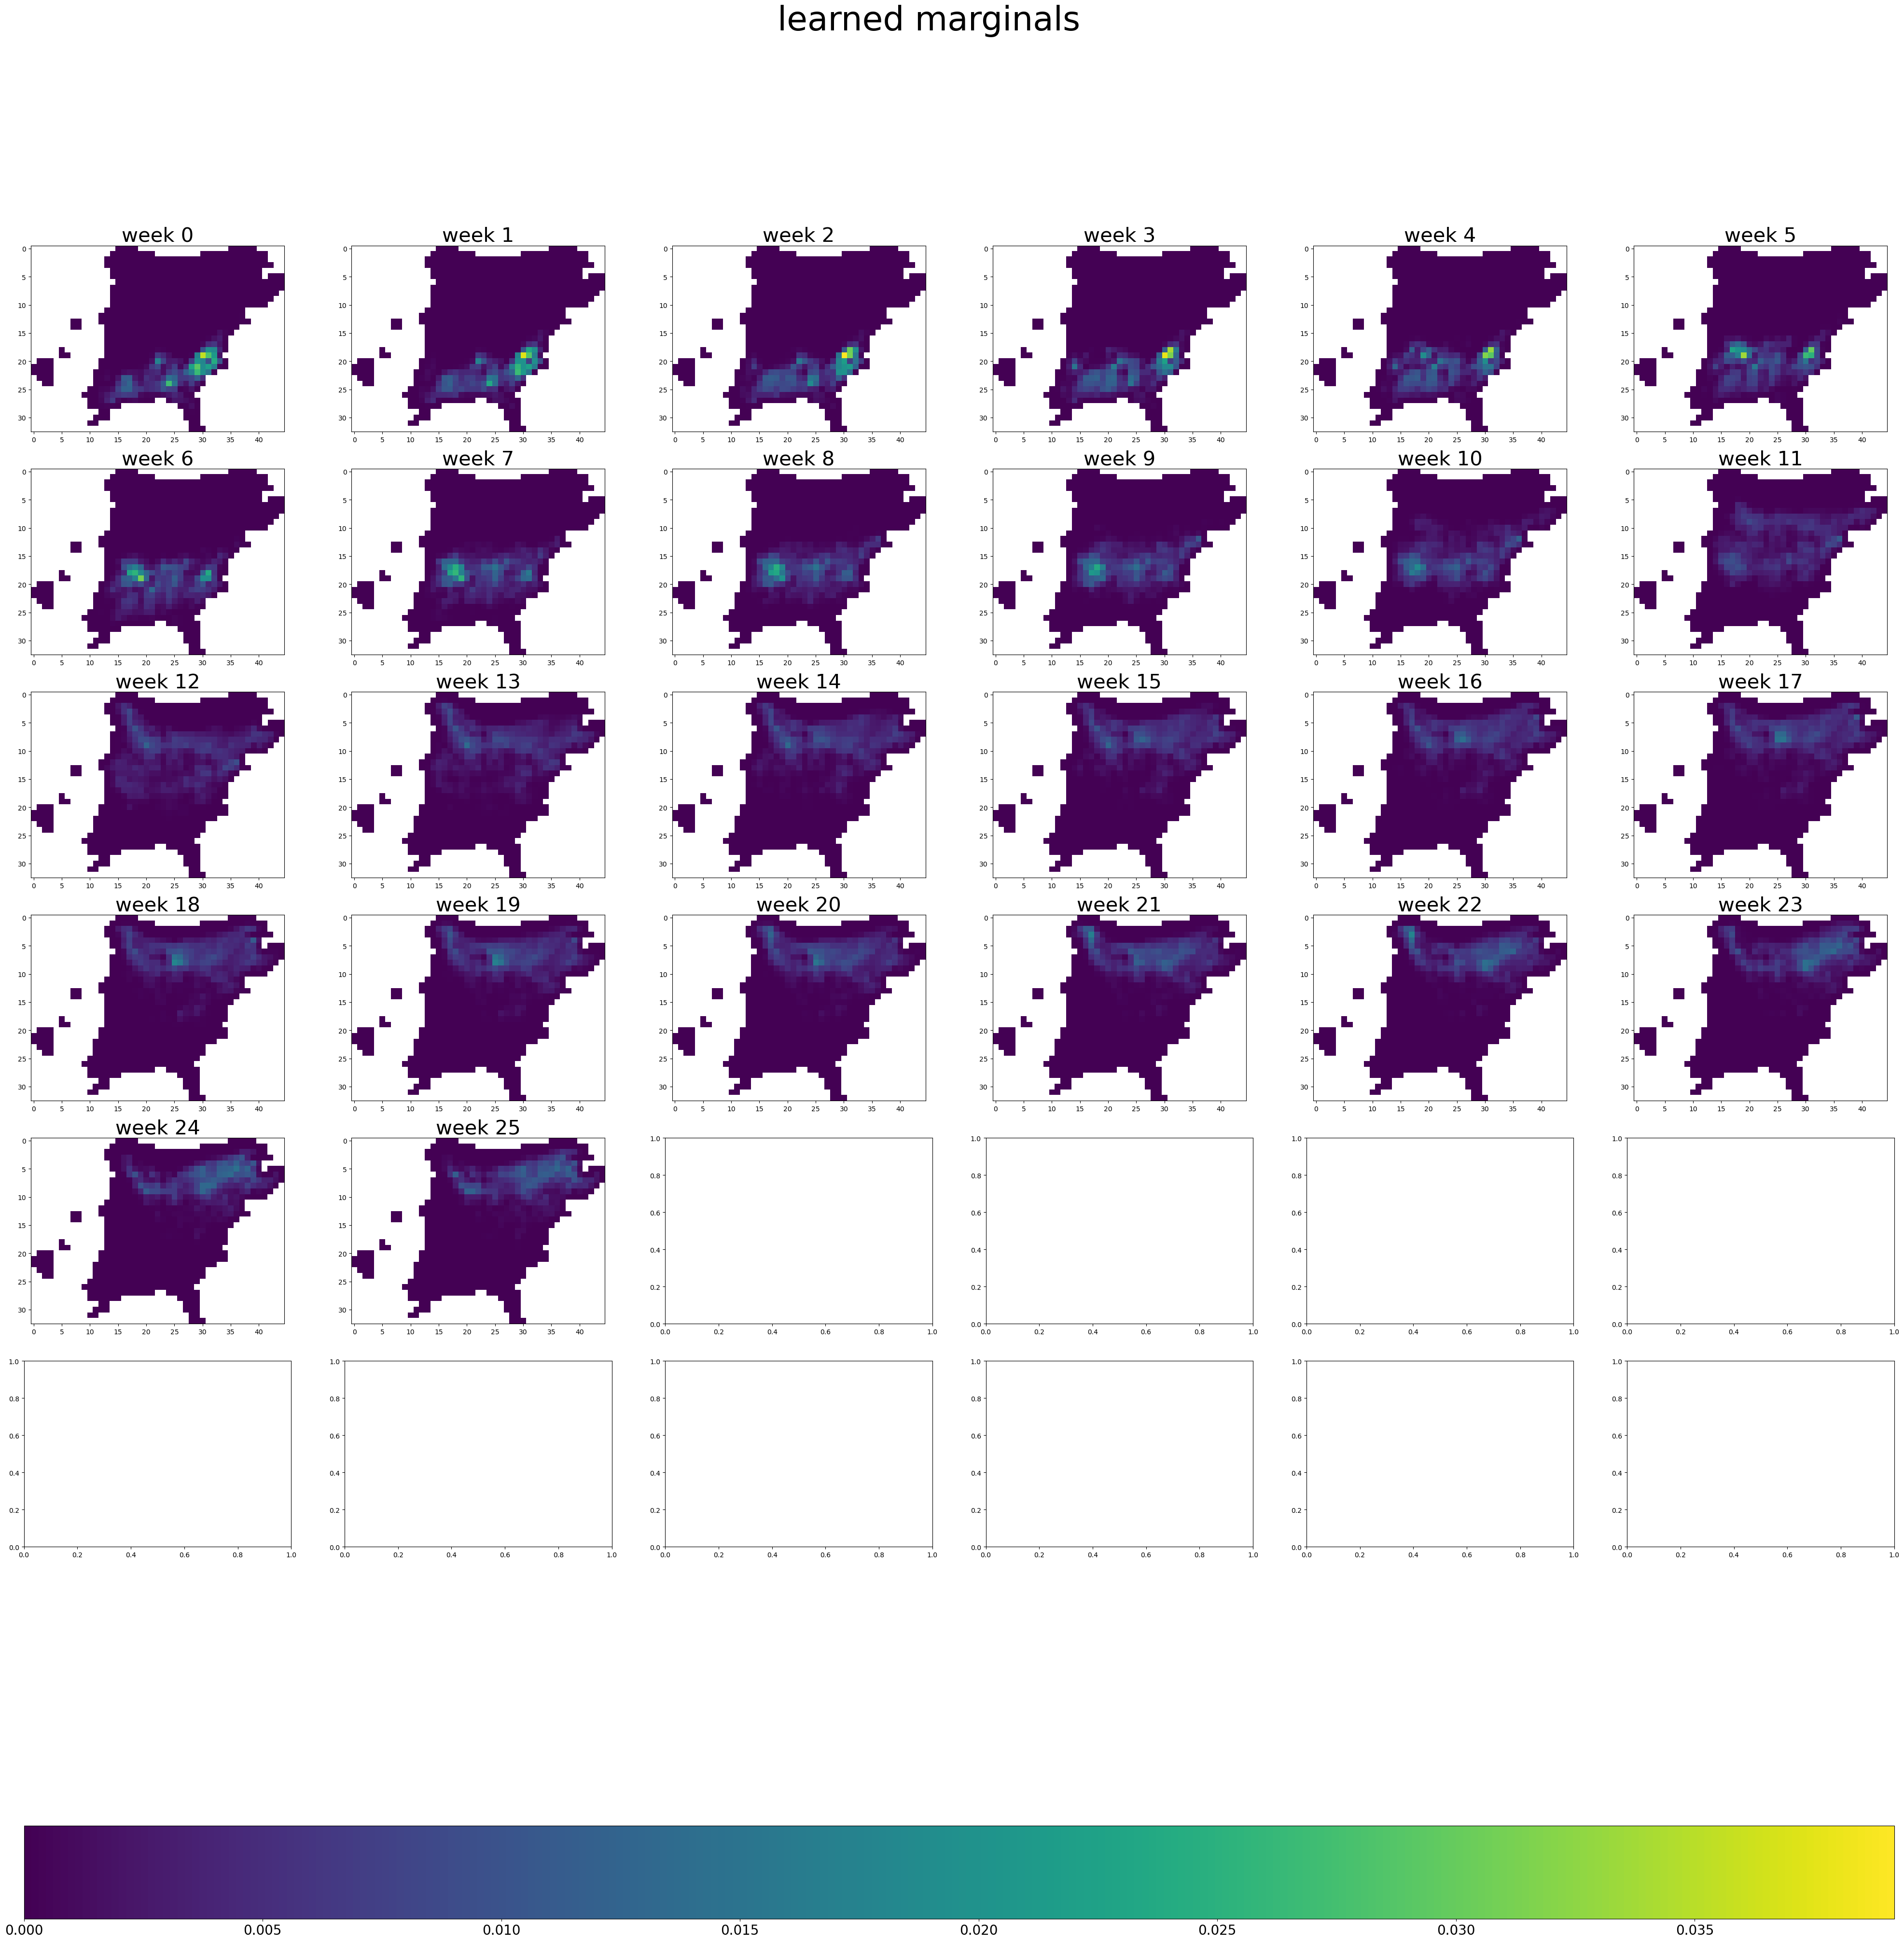

In [186]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'ex46_w2_params_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

hdf_src = '/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(len(params) - 1):
        z = params[f'Flow_Model/Week_{week + 1}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(6, 6, figsize=(50, 50))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in marginals])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=30)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()

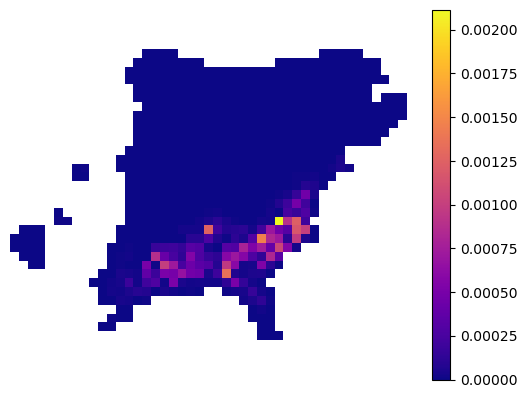

In [172]:
# plot difference between learned and ground truth for each week
trimmed_masked_densities = masked_densities[:len(params)]
marginals = get_single_tstep_marginals(params) # get marginals

marginals = get_single_tstep_marginals(params) # get marginals
marginal = marginals[0]
grid_learned = make_grid(marginal, dynamic_masks[0], big_mask, ncol, nrow)
grid_true = make_grid(ex3_masked_densities[0], dynamic_masks[0], big_mask, ncol, nrow)
grid_diff = jnp.abs(grid_learned - grid_true)
fig, ax = plt.subplots()
pos = ax.imshow(grid_diff, cmap="plasma")
cbar = fig.colorbar(pos, ax=ax)
ax.axis("off")
plt.show()

# fig, axes = plt.subplots(6, 6, figsize=(30, 30))
# ax_list = axes.flat
# vmin = 0
# vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, trimmed_masked_densities)])
# for week, marginal in enumerate(marginals):
#     grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
#     grid_true = make_grid(trimmed_masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
#     grid_diff = jnp.abs(grid_learned - grid_true)
#     pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
#     ax_list[week].set_title(f"week {week}", fontsize=20)

# cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
# cbar.ax.tick_params(labelsize=20)
# fig.suptitle("difference between learned and ground truth", fontsize=50)

# plt.show()

<class 'jaxlib.xla_extension.ArrayImpl'>


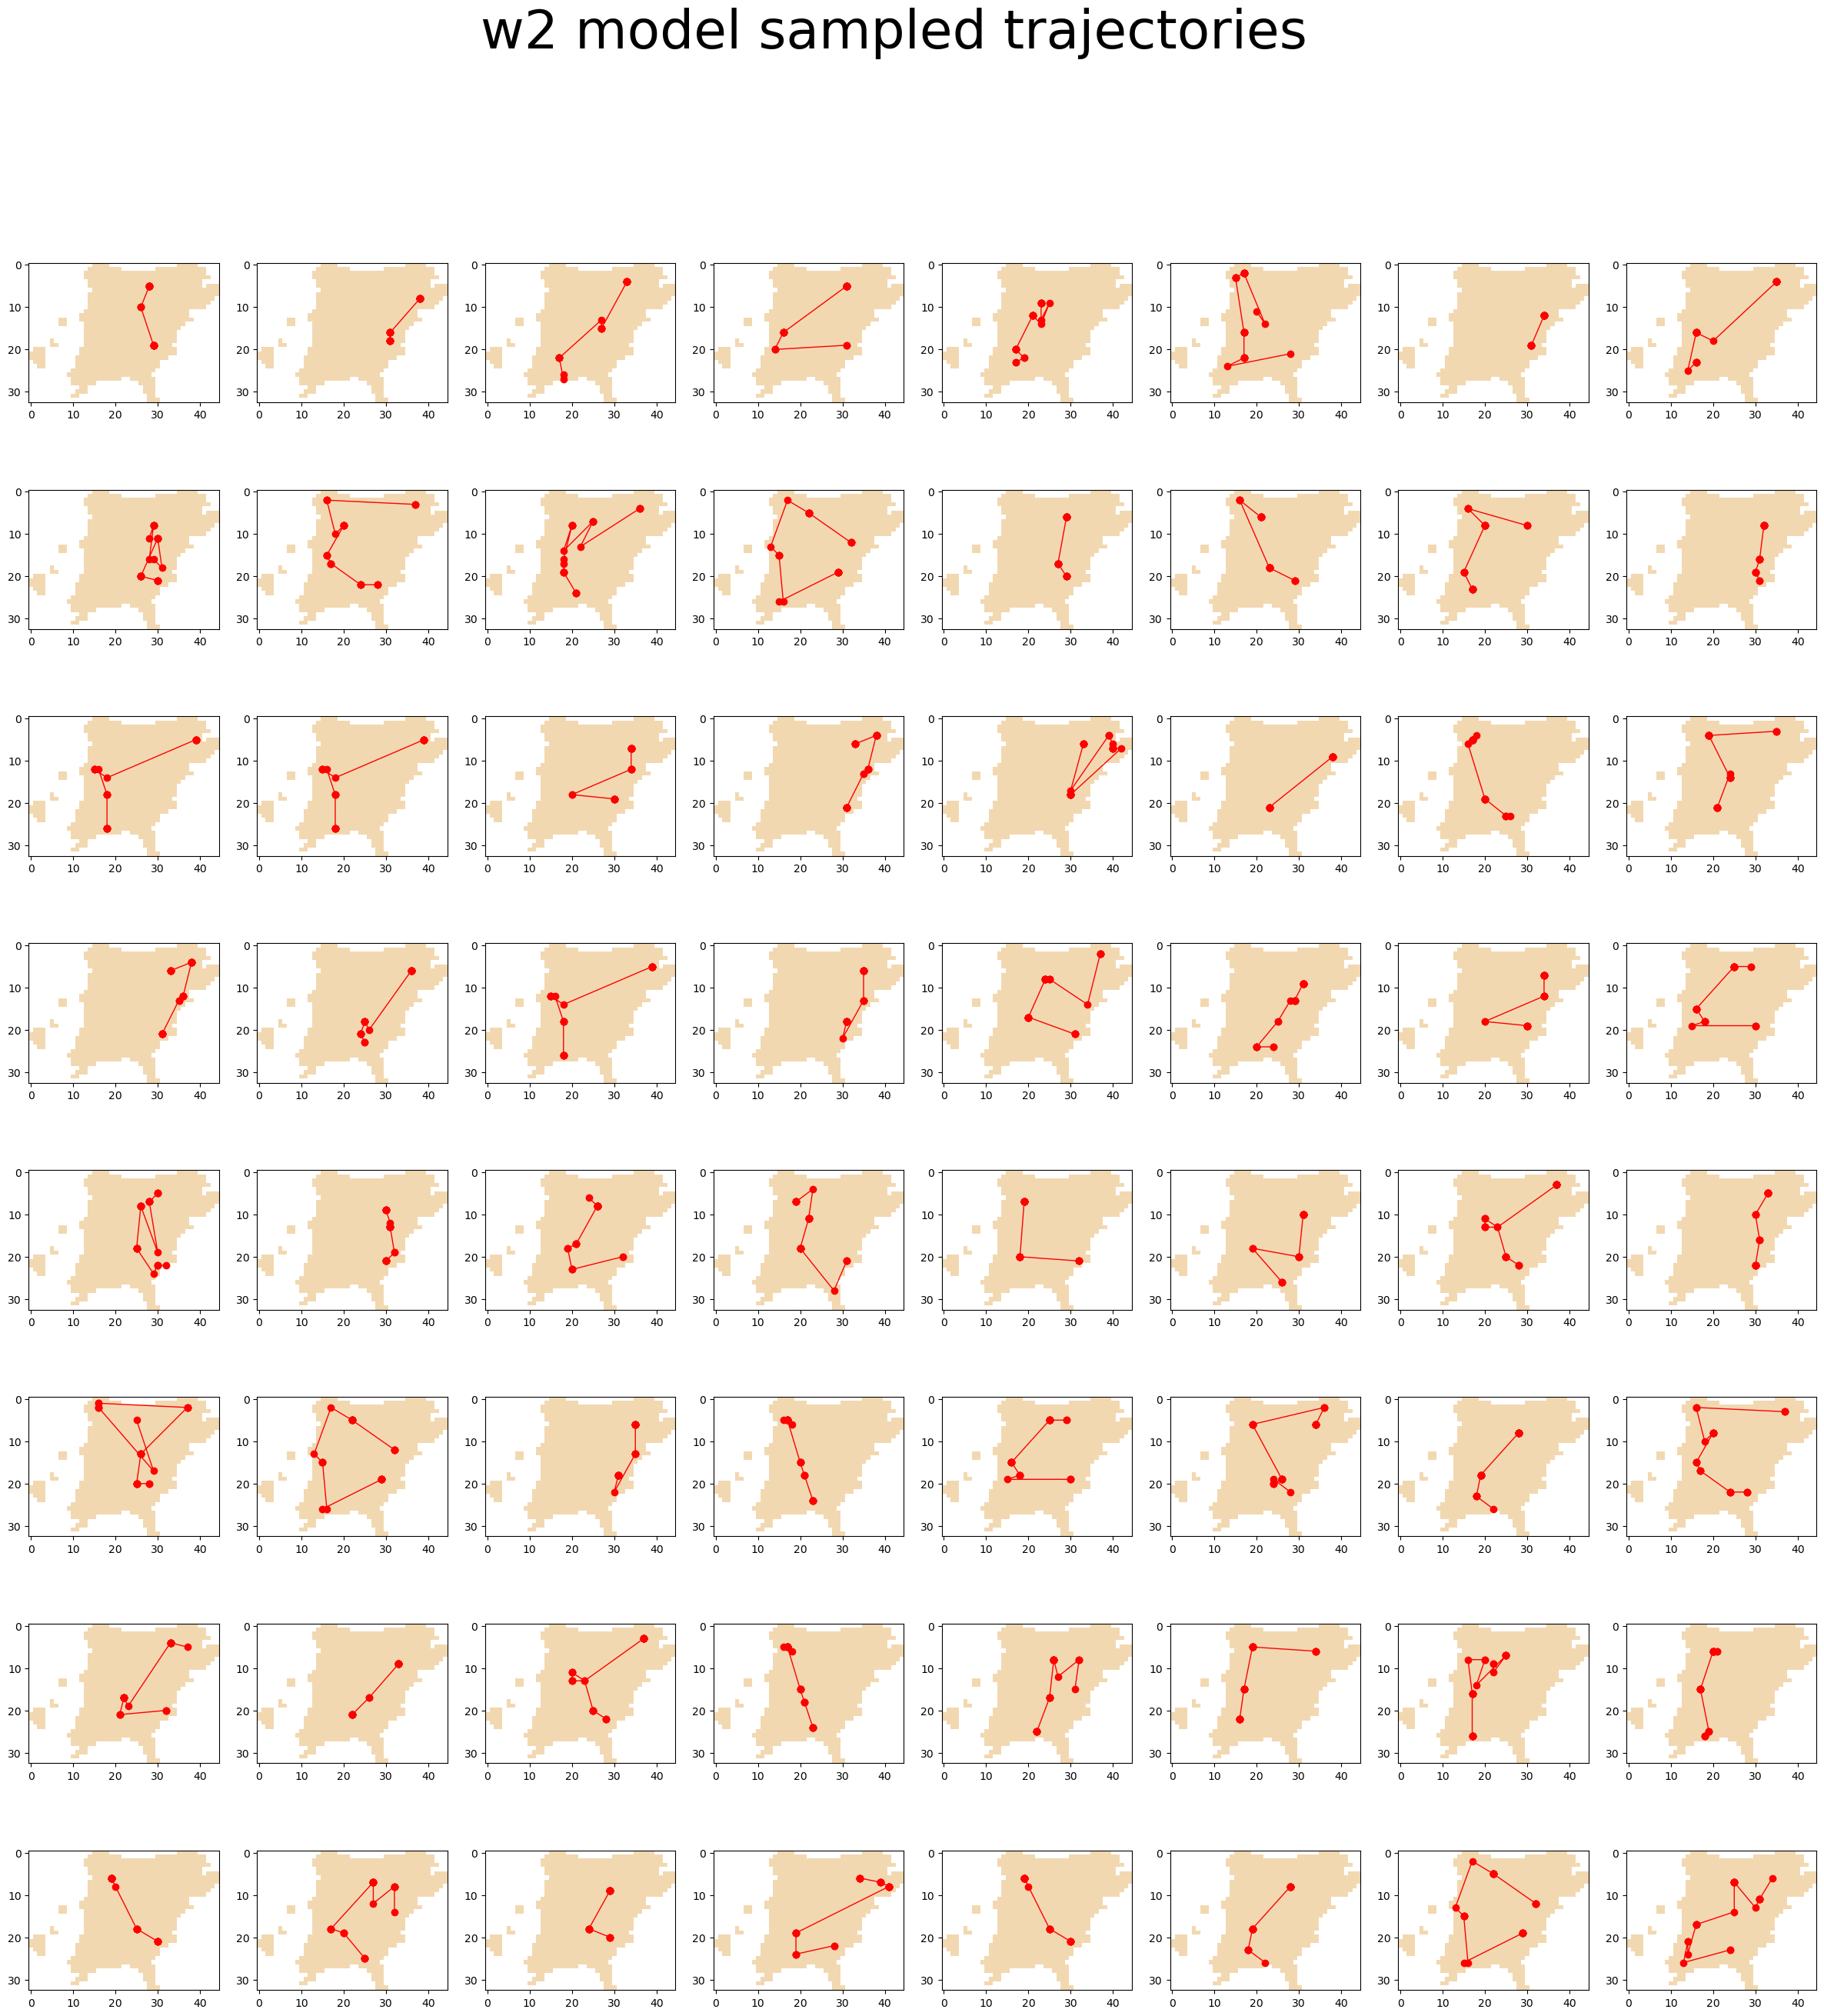

In [107]:
from flow_model import sample_trajectory
import matplotlib.colors as mcolors
import random

# plot sampled routes from the model
# rng sequence
def rng_sequence(seed):
    key = jax.random.PRNGKey(seed)
    while True:
        key, subkey = jax.random.split(key)
        yield subkey

trajectory = sample_trajectory(rng_sequence(90), params)

# create big grid for land pixels
big_grid = jnp.zeros(big_mask.shape[0])
big_grid = big_grid.at[big_mask].set(1) # mask for the land pixels
big_grid = big_grid.reshape(nrow, ncol) # reshape into a square

# colormap for plotting land pixels
cmap = mcolors.ListedColormap(['white', '#f2d8b1'])  # 0 = water, 1 = land
bounds = [0, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# convert trajectory to get indices in the big grid
dynamic_masks_for_traj = dynamic_masks[:len(trajectory)]

print(type(dynamic_masks_for_traj[0]))

def index_of_nth_occurrence(arr, value, n):
    """
    Returns index of nth occurence of value in arr
    """
    indices = jnp.where(arr == value)[0]
    if n - 1 >= len(indices) or n - 1 < 0:
        raise ValueError(f"{n}th occurrence of value {value} not found in array.")
    return indices[n-1]

def convert_trajectory(traj, dynamic_masks_for_traj, big_mask, nrow, ncol):
    # convert trajectory to coordinates in big grid
    traj_big_grid = [] # get points for the trajectory in flattened big grid
    for x, mask in zip(traj, dynamic_masks_for_traj):
        x_in_medium_grid = index_of_nth_occurrence(mask, True, x + 1) # use x + 1 since x is an index, not a count
        x_in_flattened_big_grid = index_of_nth_occurrence(big_mask, True, x_in_medium_grid + 1) # use x_in_medium_grid + 1 since x is an index, not a count
        x_in_big_grid = jnp.unravel_index(x_in_flattened_big_grid, (nrow, ncol))
        traj_big_grid.append(x_in_big_grid)
        # print(f"converted {x} to {x_in_medium_grid} to {x_in_flattened_big_grid} to {x_in_big_grid}")
    
    traj_big_grid = jnp.array(traj_big_grid)
    traj_coords_in_big_grid = traj_big_grid[:, [1, 0]] # swap columns to get plot coordinates

    return traj_coords_in_big_grid

def convert_to_coordinates_in_mask(cells, dynamic_mask, big_mask, nrow, ncol):
    cells_in_big_grid = [] # get points for the trajectory in flattened big grid
    for x in cells:
        x_in_medium_grid = index_of_nth_occurrence(dynamic_mask, True, x + 1) # use x + 1 since x is an index, not a count
        x_in_flattened_big_grid = index_of_nth_occurrence(big_mask, True, x_in_medium_grid + 1) # use x_in_medium_grid + 1 since x is an index, not a count
        x_in_big_grid = jnp.unravel_index(x_in_flattened_big_grid, (nrow, ncol))
        cells_in_big_grid.append(x_in_big_grid)
    
    # postprocess
    cells_in_big_grid = jnp.array(cells_in_big_grid)
    coords_in_big_grid = cells_in_big_grid[:, [1, 0]] # swap columns to get plot coordinates
    
    return coords_in_big_grid

# plot test marginal
# coords = convert_to_coordinates_in_mask(jnp.arange(337), dynamic_masks[25], big_mask, nrow, ncol)
# coords_x = coords[:, 0]
# coords_y = coords[:, 1]

# print(coords)
# print(coords_x)
# print(coords_y)
# plt.scatter(coords_x, coords_y, marker='o', color='red')
# plt.scatter([10], [10])

# plot 100 trajectories
num_trajectories = 64
fig, axes = plt.subplots(8, 8, figsize=(30, 30))
ax_list = axes.flat
for i in range(num_trajectories):
    # plot land pixels
    ax_list[i].imshow(big_grid, cmap=cmap, norm=norm)

    # sample trajectory
    seed = random.randint(0, 100)
    trajectory = sample_trajectory(rng_sequence(seed), params)

    # plot trajectory
    traj_in_big_grid = convert_trajectory(trajectory, dynamic_masks_for_traj, big_mask, nrow, ncol)
    traj_xs = traj_in_big_grid[:, 0]
    traj_ys = traj_in_big_grid[:, 1]
    ax_list[i].plot(traj_xs, traj_ys, marker='o', color='red', linewidth=1)

plt.plot()
plt.suptitle("w2 model sampled trajectories", fontsize=50)
plt.show()

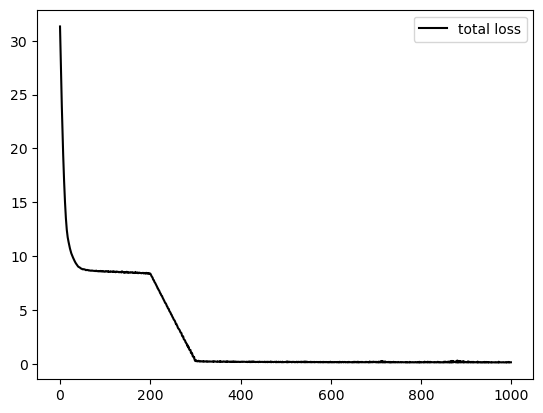

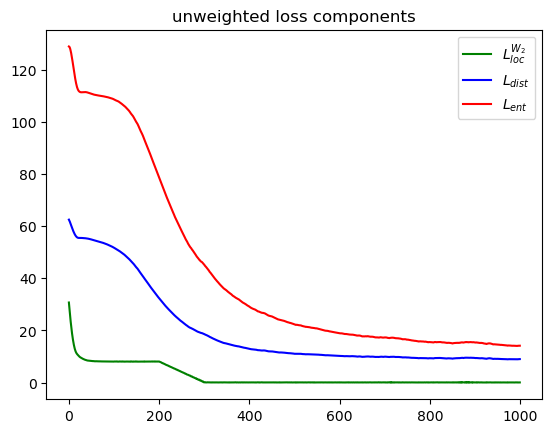

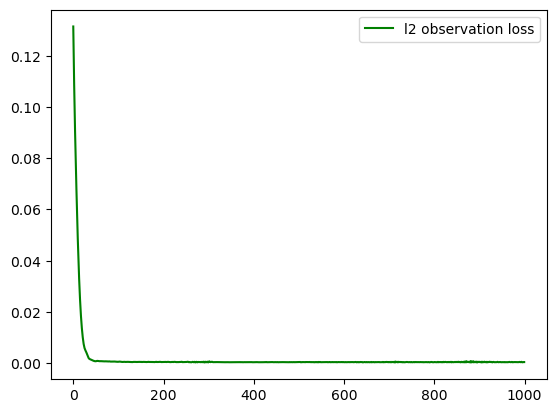

In [185]:
experiment_file = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results/ex46_w2_losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl"
with open(experiment_file, 'rb') as f:
    loss_dict = pickle.load(f)

# hyperparameter weights
dw = 1e-2
ew = 1e-4

plt.figure(0)
plt.plot(jnp.arange(1000), loss_dict['total'], 'black', label='total loss')
plt.legend()

plt.figure(1)
plt.plot(jnp.arange(1000), loss_dict['w2_obs'], 'green', label='$L_{loc}^{W_2}$')
plt.plot(jnp.arange(1000), loss_dict['dist'], 'blue', label='$L_{dist}$')
plt.plot(jnp.arange(1000), jnp.array(loss_dict['ent']), 'red', label='$L_{ent}$')
plt.title("unweighted loss components")
plt.legend()

plt.figure(2)
plt.plot(jnp.arange(1000), loss_dict['l2_obs'], label="l2 observation loss", color='green')
plt.legend()
plt.show()

### Experiment 4.7
- Train model with w2 obs loss
- No epsilon schduler, stay constant at 0.01 * `EPS_DEFAULT`
- 26 weeks of s&t data
- use multiplier $\alpha = 5 \times 10^{-3}$ for $\mathcal{L}_{W2}^{obs}$
- ow: 1, ew: 1e-4, dw: 1e-2, dp: 0.4
- Random initialization
- 1000 training steps

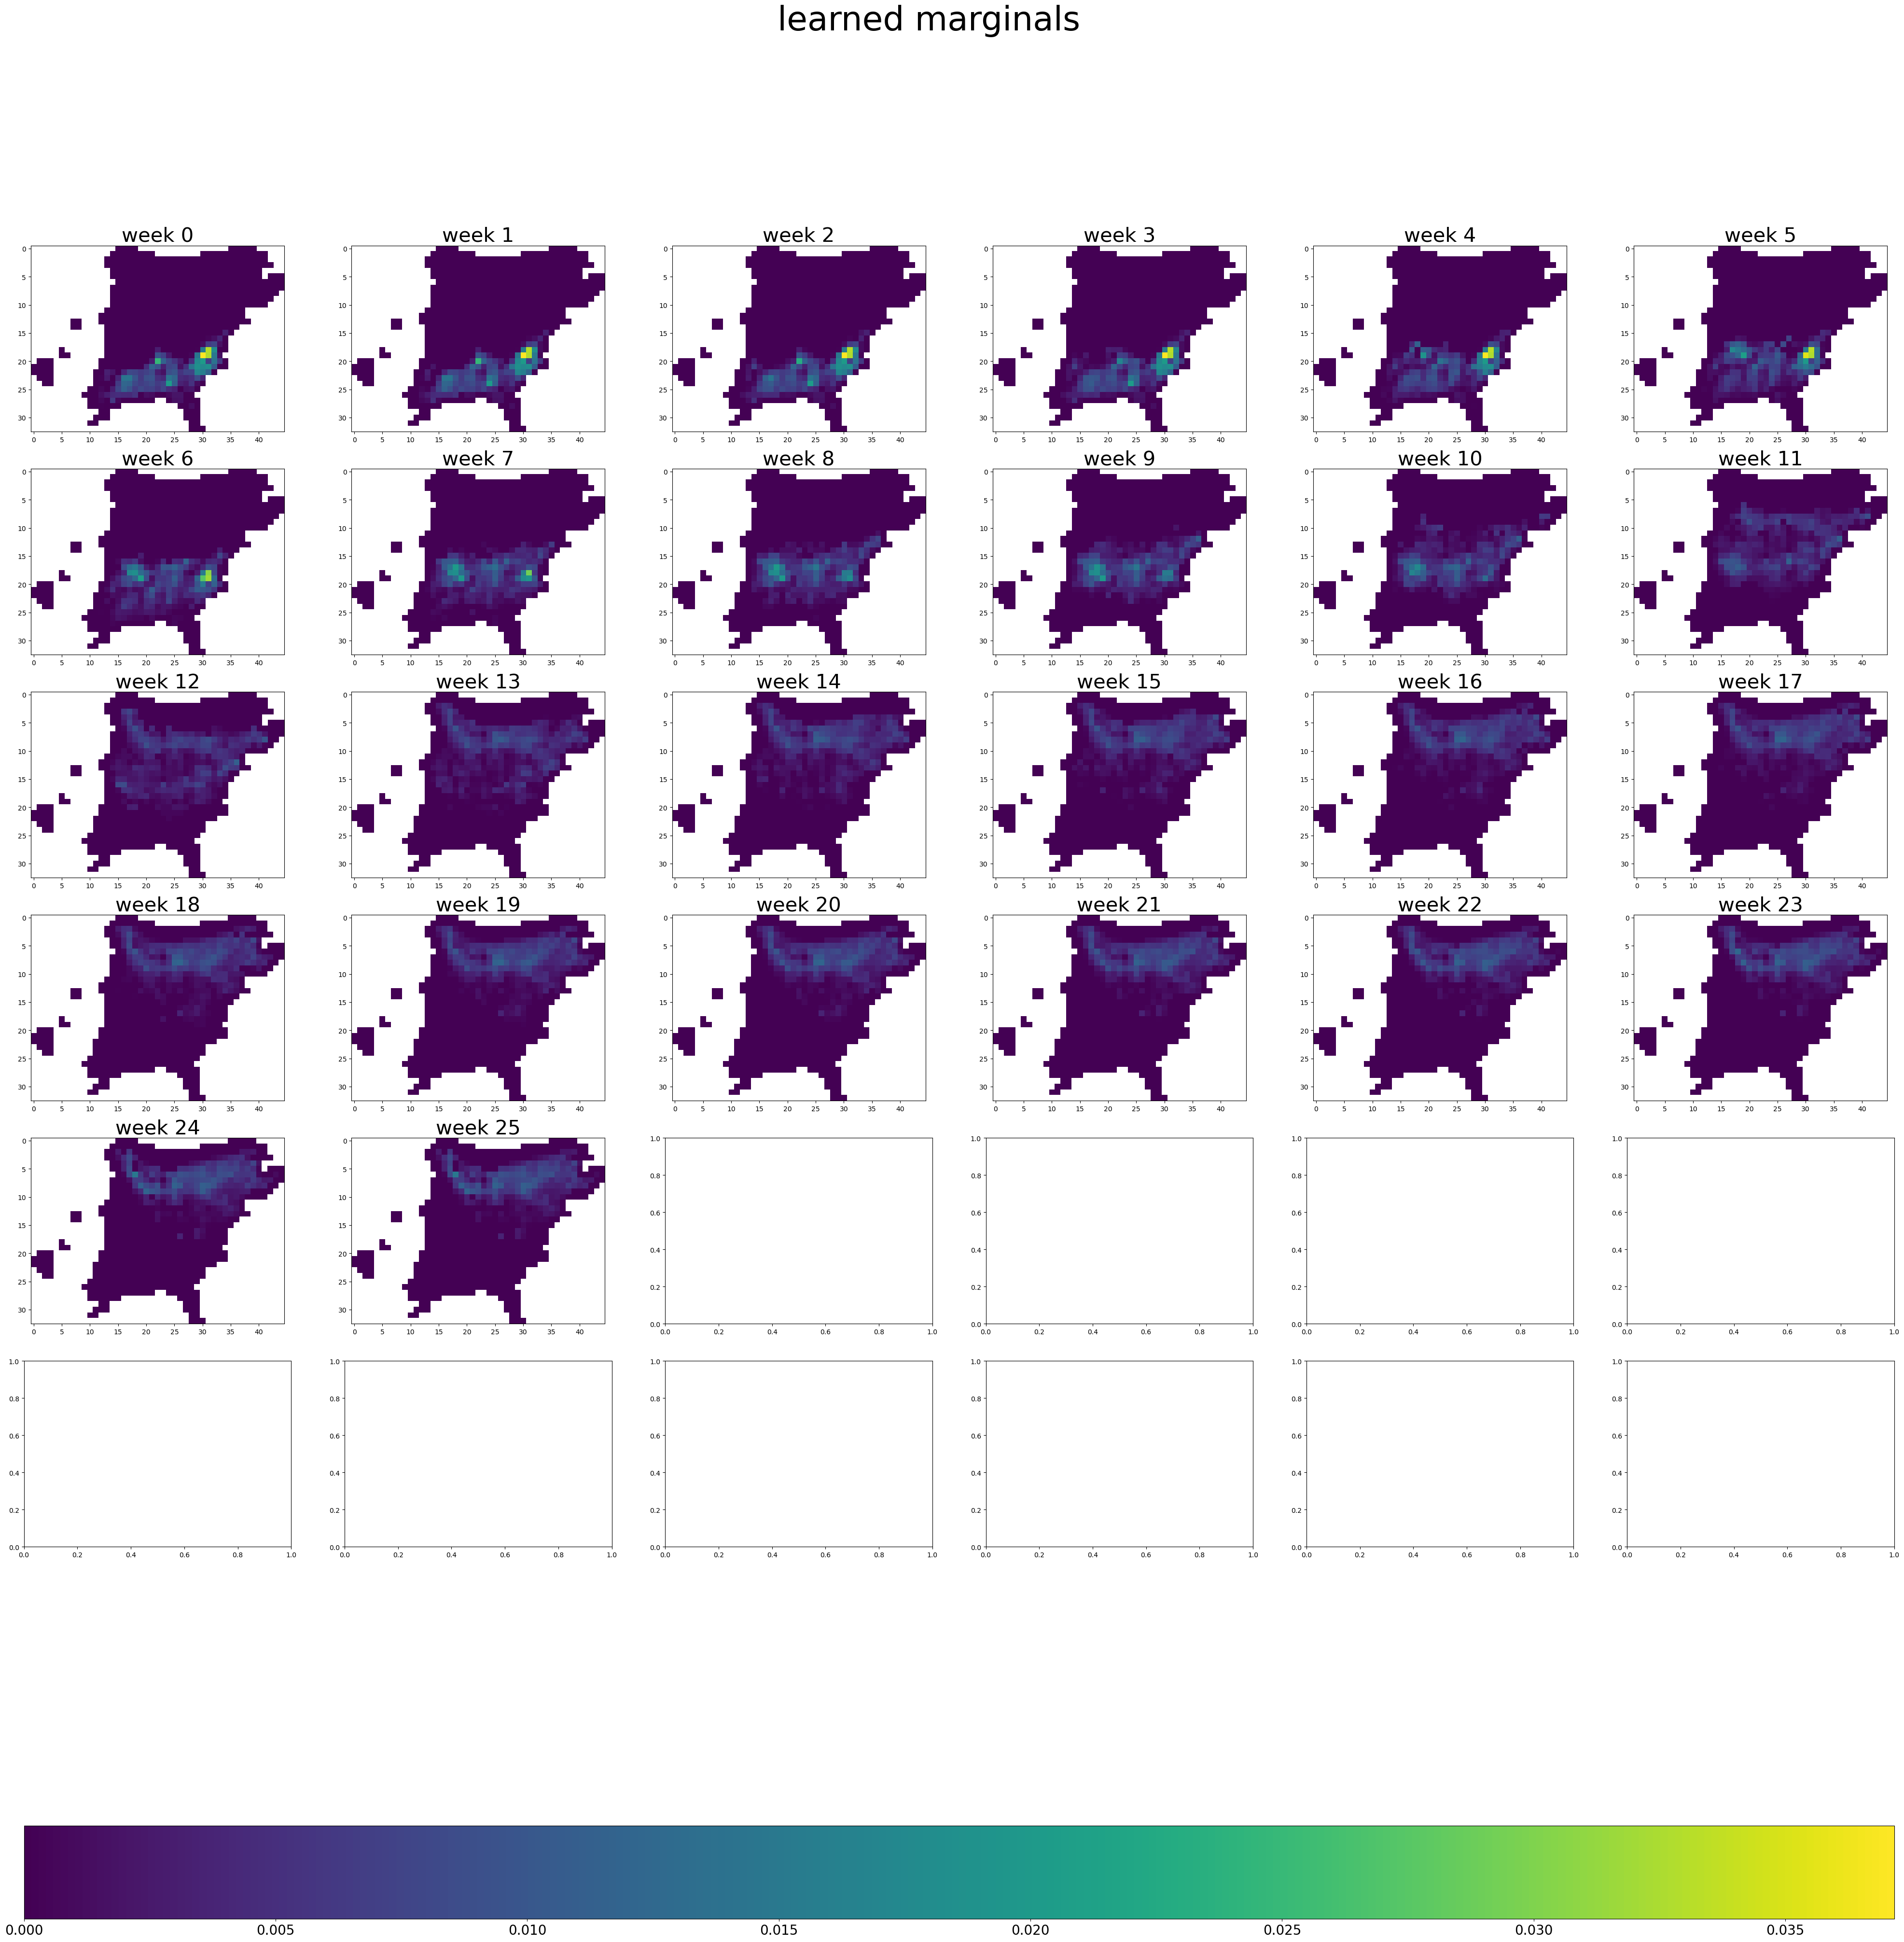

In [117]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with open(os.path.join(experiment_dir, 'ex47_w2_params_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl'),
          'rb') as f:
    params = pickle.load(f)

hdf_src = '/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(len(params) - 1):
        z = params[f'Flow_Model/Week_{week + 1}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(6, 6, figsize=(50, 50))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in marginals])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=30)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()

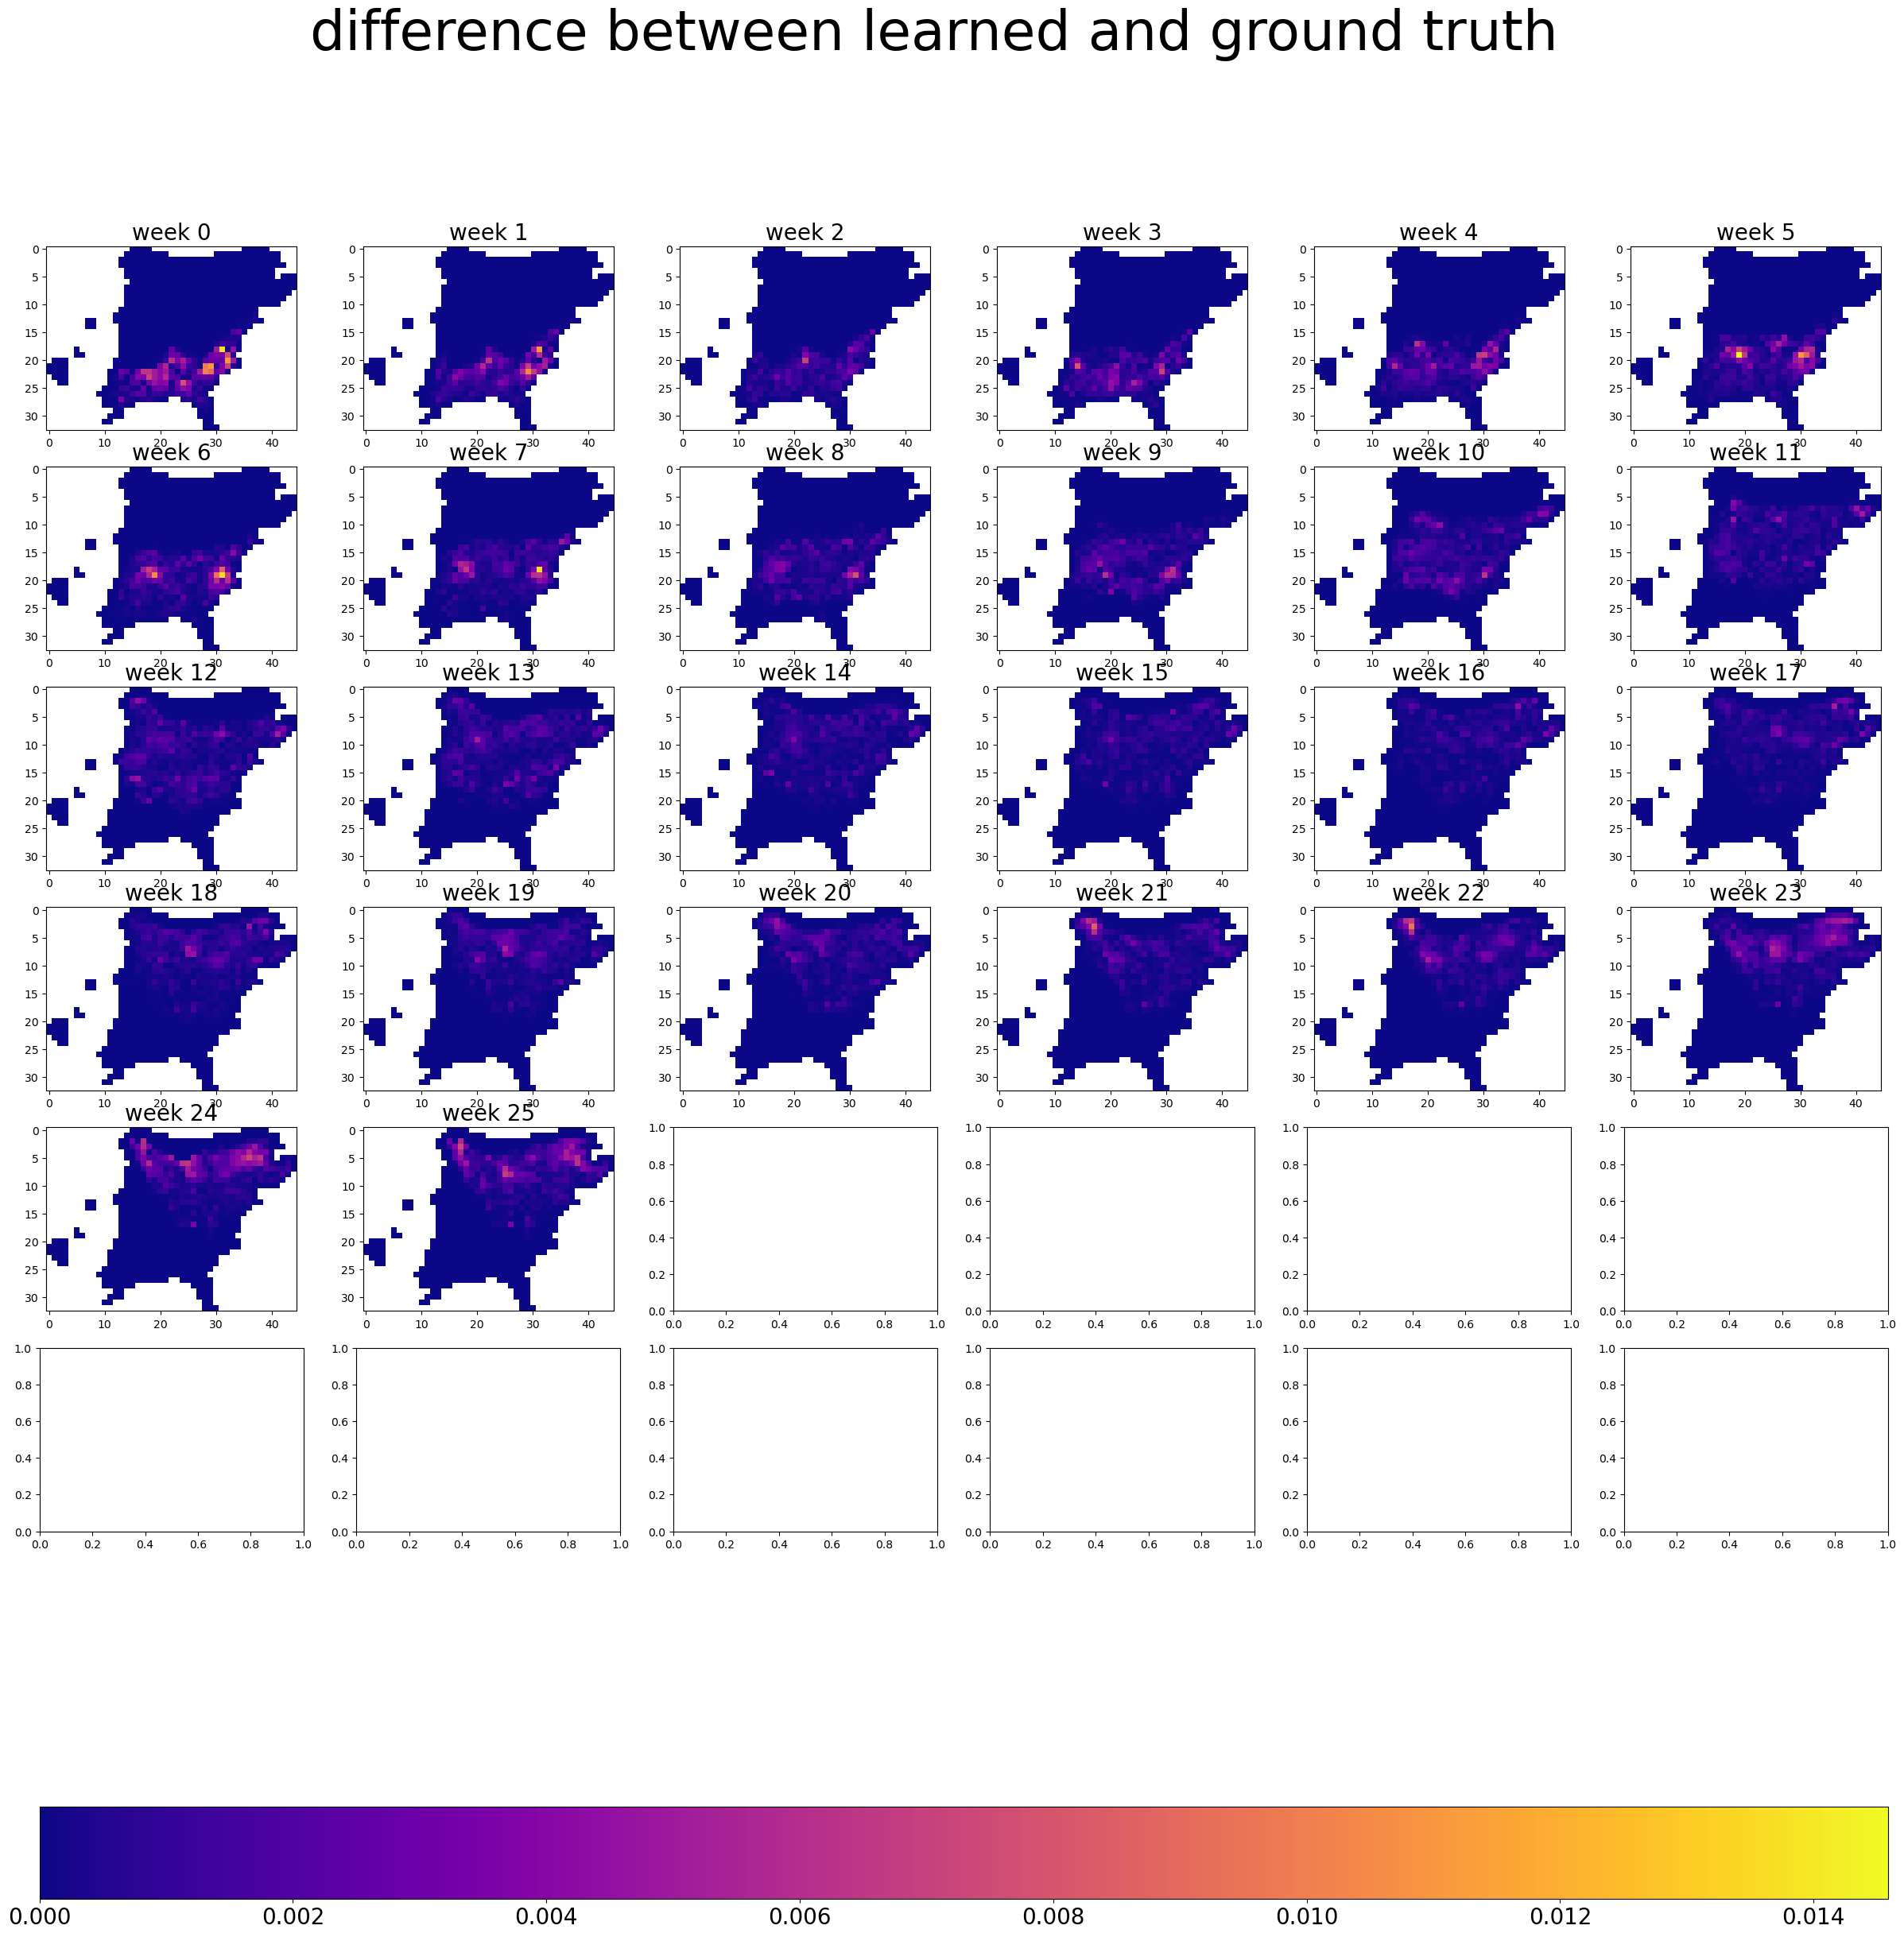

In [ ]:
# plot difference between learned and ground truth for each week
trimmed_masked_densities = masked_densities[:len(params)]
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(6, 6, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(marginals, trimmed_masked_densities)])
for week, marginal in enumerate(marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(trimmed_masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_learned - grid_true)
    pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=20)

cbar = fig.b(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=50)

plt.show()

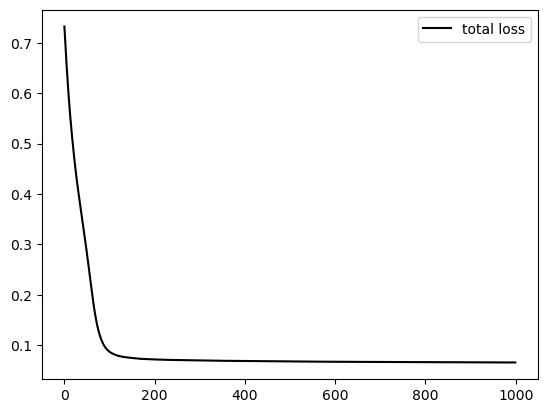

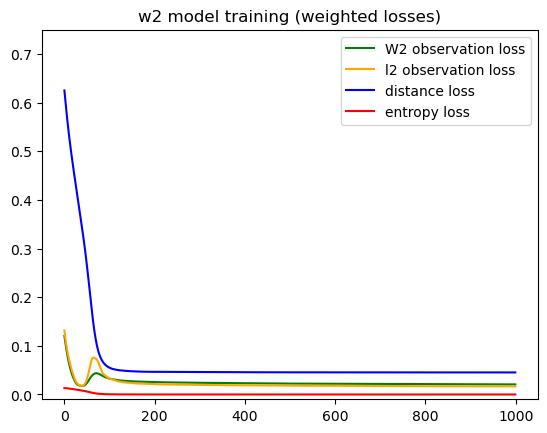

In [134]:
experiment_file = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results/ex47_w2_losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl"
with open(experiment_file, 'rb') as f:
    loss_dict = pickle.load(f)

# hyperparameter weights
dw = 1e-2
ew = 1e-4
ow = 1

plt.figure(0)
plt.plot(jnp.arange(1000), loss_dict['total'], 'black', label='total loss')
plt.legend()

plt.figure(1)
plt.plot(jnp.arange(1000), ow * jnp.array(loss_dict['w2_obs']), 'green', label='W2 observation loss')
plt.plot(jnp.arange(1000), ow * jnp.array(loss_dict['l2_obs']), label="l2 observation loss", color='orange')
plt.plot(jnp.arange(1000), dw * jnp.array(loss_dict['dist']), 'blue', label='distance loss')
plt.plot(jnp.arange(1000), ew * jnp.array(loss_dict['ent']), 'red', label='entropy loss')
plt.title("w2 model training (weighted losses)")
plt.ylim(-0.01, 0.75)
plt.legend()


<class 'jaxlib.xla_extension.ArrayImpl'>


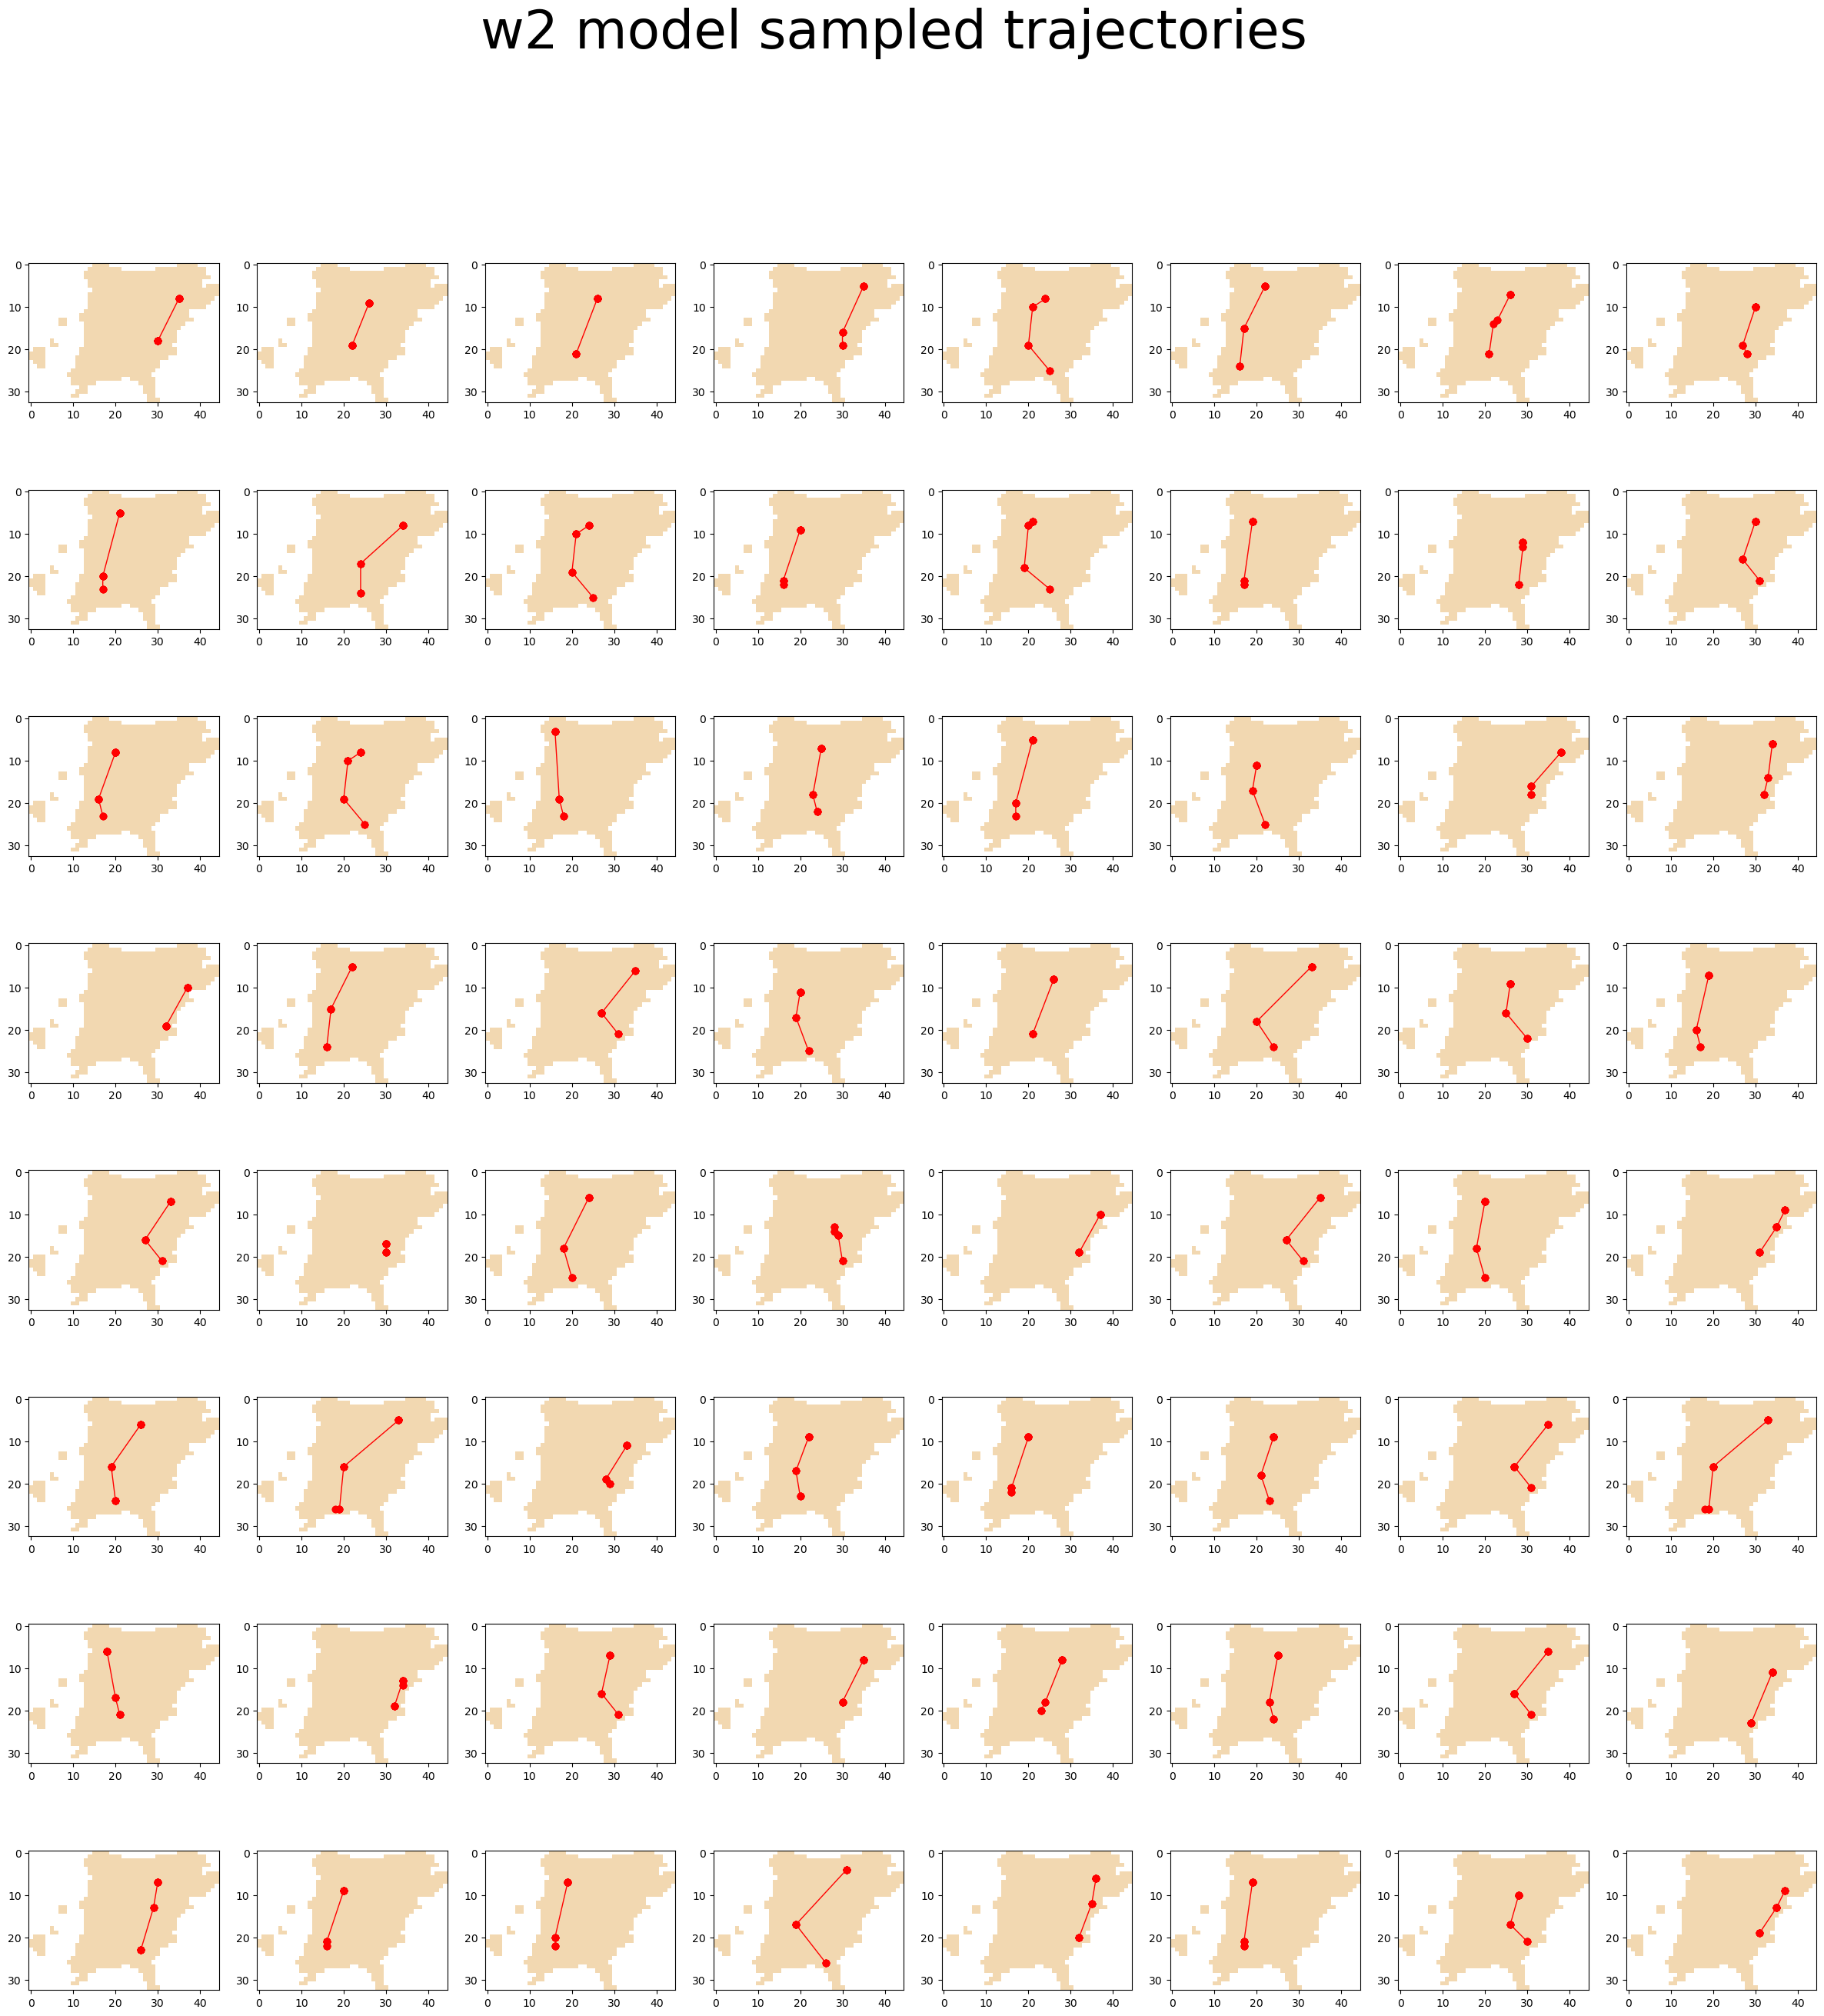

In [122]:
from flow_model import sample_trajectory
import matplotlib.colors as mcolors
import random

# plot sampled routes from the model
# rng sequence
def rng_sequence(seed):
    key = jax.random.PRNGKey(seed)
    while True:
        key, subkey = jax.random.split(key)
        yield subkey

trajectory = sample_trajectory(rng_sequence(90), params)

# create big grid for land pixels
big_grid = jnp.zeros(big_mask.shape[0])
big_grid = big_grid.at[big_mask].set(1) # mask for the land pixels
big_grid = big_grid.reshape(nrow, ncol) # reshape into a square

# colormap for plotting land pixels
cmap = mcolors.ListedColormap(['white', '#f2d8b1'])  # 0 = water, 1 = land
bounds = [0, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# convert trajectory to get indices in the big grid
dynamic_masks_for_traj = dynamic_masks[:len(trajectory)]

print(type(dynamic_masks_for_traj[0]))

def index_of_nth_occurrence(arr, value, n):
    """
    Returns index of nth occurence of value in arr
    """
    indices = jnp.where(arr == value)[0]
    if n - 1 >= len(indices) or n - 1 < 0:
        raise ValueError(f"{n}th occurrence of value {value} not found in array.")
    return indices[n-1]

def convert_trajectory(traj, dynamic_masks_for_traj, big_mask, nrow, ncol):
    # convert trajectory to coordinates in big grid
    traj_big_grid = [] # get points for the trajectory in flattened big grid
    for x, mask in zip(traj, dynamic_masks_for_traj):
        x_in_medium_grid = index_of_nth_occurrence(mask, True, x + 1) # use x + 1 since x is an index, not a count
        x_in_flattened_big_grid = index_of_nth_occurrence(big_mask, True, x_in_medium_grid + 1) # use x_in_medium_grid + 1 since x is an index, not a count
        x_in_big_grid = jnp.unravel_index(x_in_flattened_big_grid, (nrow, ncol))
        traj_big_grid.append(x_in_big_grid)
        # print(f"converted {x} to {x_in_medium_grid} to {x_in_flattened_big_grid} to {x_in_big_grid}")
    
    traj_big_grid = jnp.array(traj_big_grid)
    traj_coords_in_big_grid = traj_big_grid[:, [1, 0]] # swap columns to get plot coordinates

    return traj_coords_in_big_grid

def convert_to_coordinates_in_mask(cells, dynamic_mask, big_mask, nrow, ncol):
    cells_in_big_grid = [] # get points for the trajectory in flattened big grid
    for x in cells:
        x_in_medium_grid = index_of_nth_occurrence(dynamic_mask, True, x + 1) # use x + 1 since x is an index, not a count
        x_in_flattened_big_grid = index_of_nth_occurrence(big_mask, True, x_in_medium_grid + 1) # use x_in_medium_grid + 1 since x is an index, not a count
        x_in_big_grid = jnp.unravel_index(x_in_flattened_big_grid, (nrow, ncol))
        cells_in_big_grid.append(x_in_big_grid)
    
    # postprocess
    cells_in_big_grid = jnp.array(cells_in_big_grid)
    coords_in_big_grid = cells_in_big_grid[:, [1, 0]] # swap columns to get plot coordinates
    
    return coords_in_big_grid

# plot test marginal
# coords = convert_to_coordinates_in_mask(jnp.arange(337), dynamic_masks[25], big_mask, nrow, ncol)
# coords_x = coords[:, 0]
# coords_y = coords[:, 1]

# print(coords)
# print(coords_x)
# print(coords_y)
# plt.scatter(coords_x, coords_y, marker='o', color='red')
# plt.scatter([10], [10])

# plot 100 trajectories
num_trajectories = 64
fig, axes = plt.subplots(8, 8, figsize=(30, 30))
ax_list = axes.flat
for i in range(num_trajectories):
    # plot land pixels
    ax_list[i].imshow(big_grid, cmap=cmap, norm=norm)

    # sample trajectory
    seed = random.randint(0, 100)
    trajectory = sample_trajectory(rng_sequence(seed), params)

    # plot trajectory
    traj_in_big_grid = convert_trajectory(trajectory, dynamic_masks_for_traj, big_mask, nrow, ncol)
    traj_xs = traj_in_big_grid[:, 0]
    traj_ys = traj_in_big_grid[:, 1]
    ax_list[i].plot(traj_xs, traj_ys, marker='o', color='red', linewidth=1)

plt.plot()
plt.suptitle("w2 model sampled trajectories", fontsize=50)
plt.show()

### Experiment 4.8
- 1000 training steps
- 53 weeks of s&t data
- Train model with w2 obs loss
- No epsilon schduler, stay constant at 0.01 * `EPS_DEFAULT`
- use multiplier $\alpha = 5 \times 10^{-3}$ for $\mathcal{L}_{W2}^{obs}$
- ow: 1, ew: 1e-4, dw: 1e-2, dp: 0.4
- Random initialization

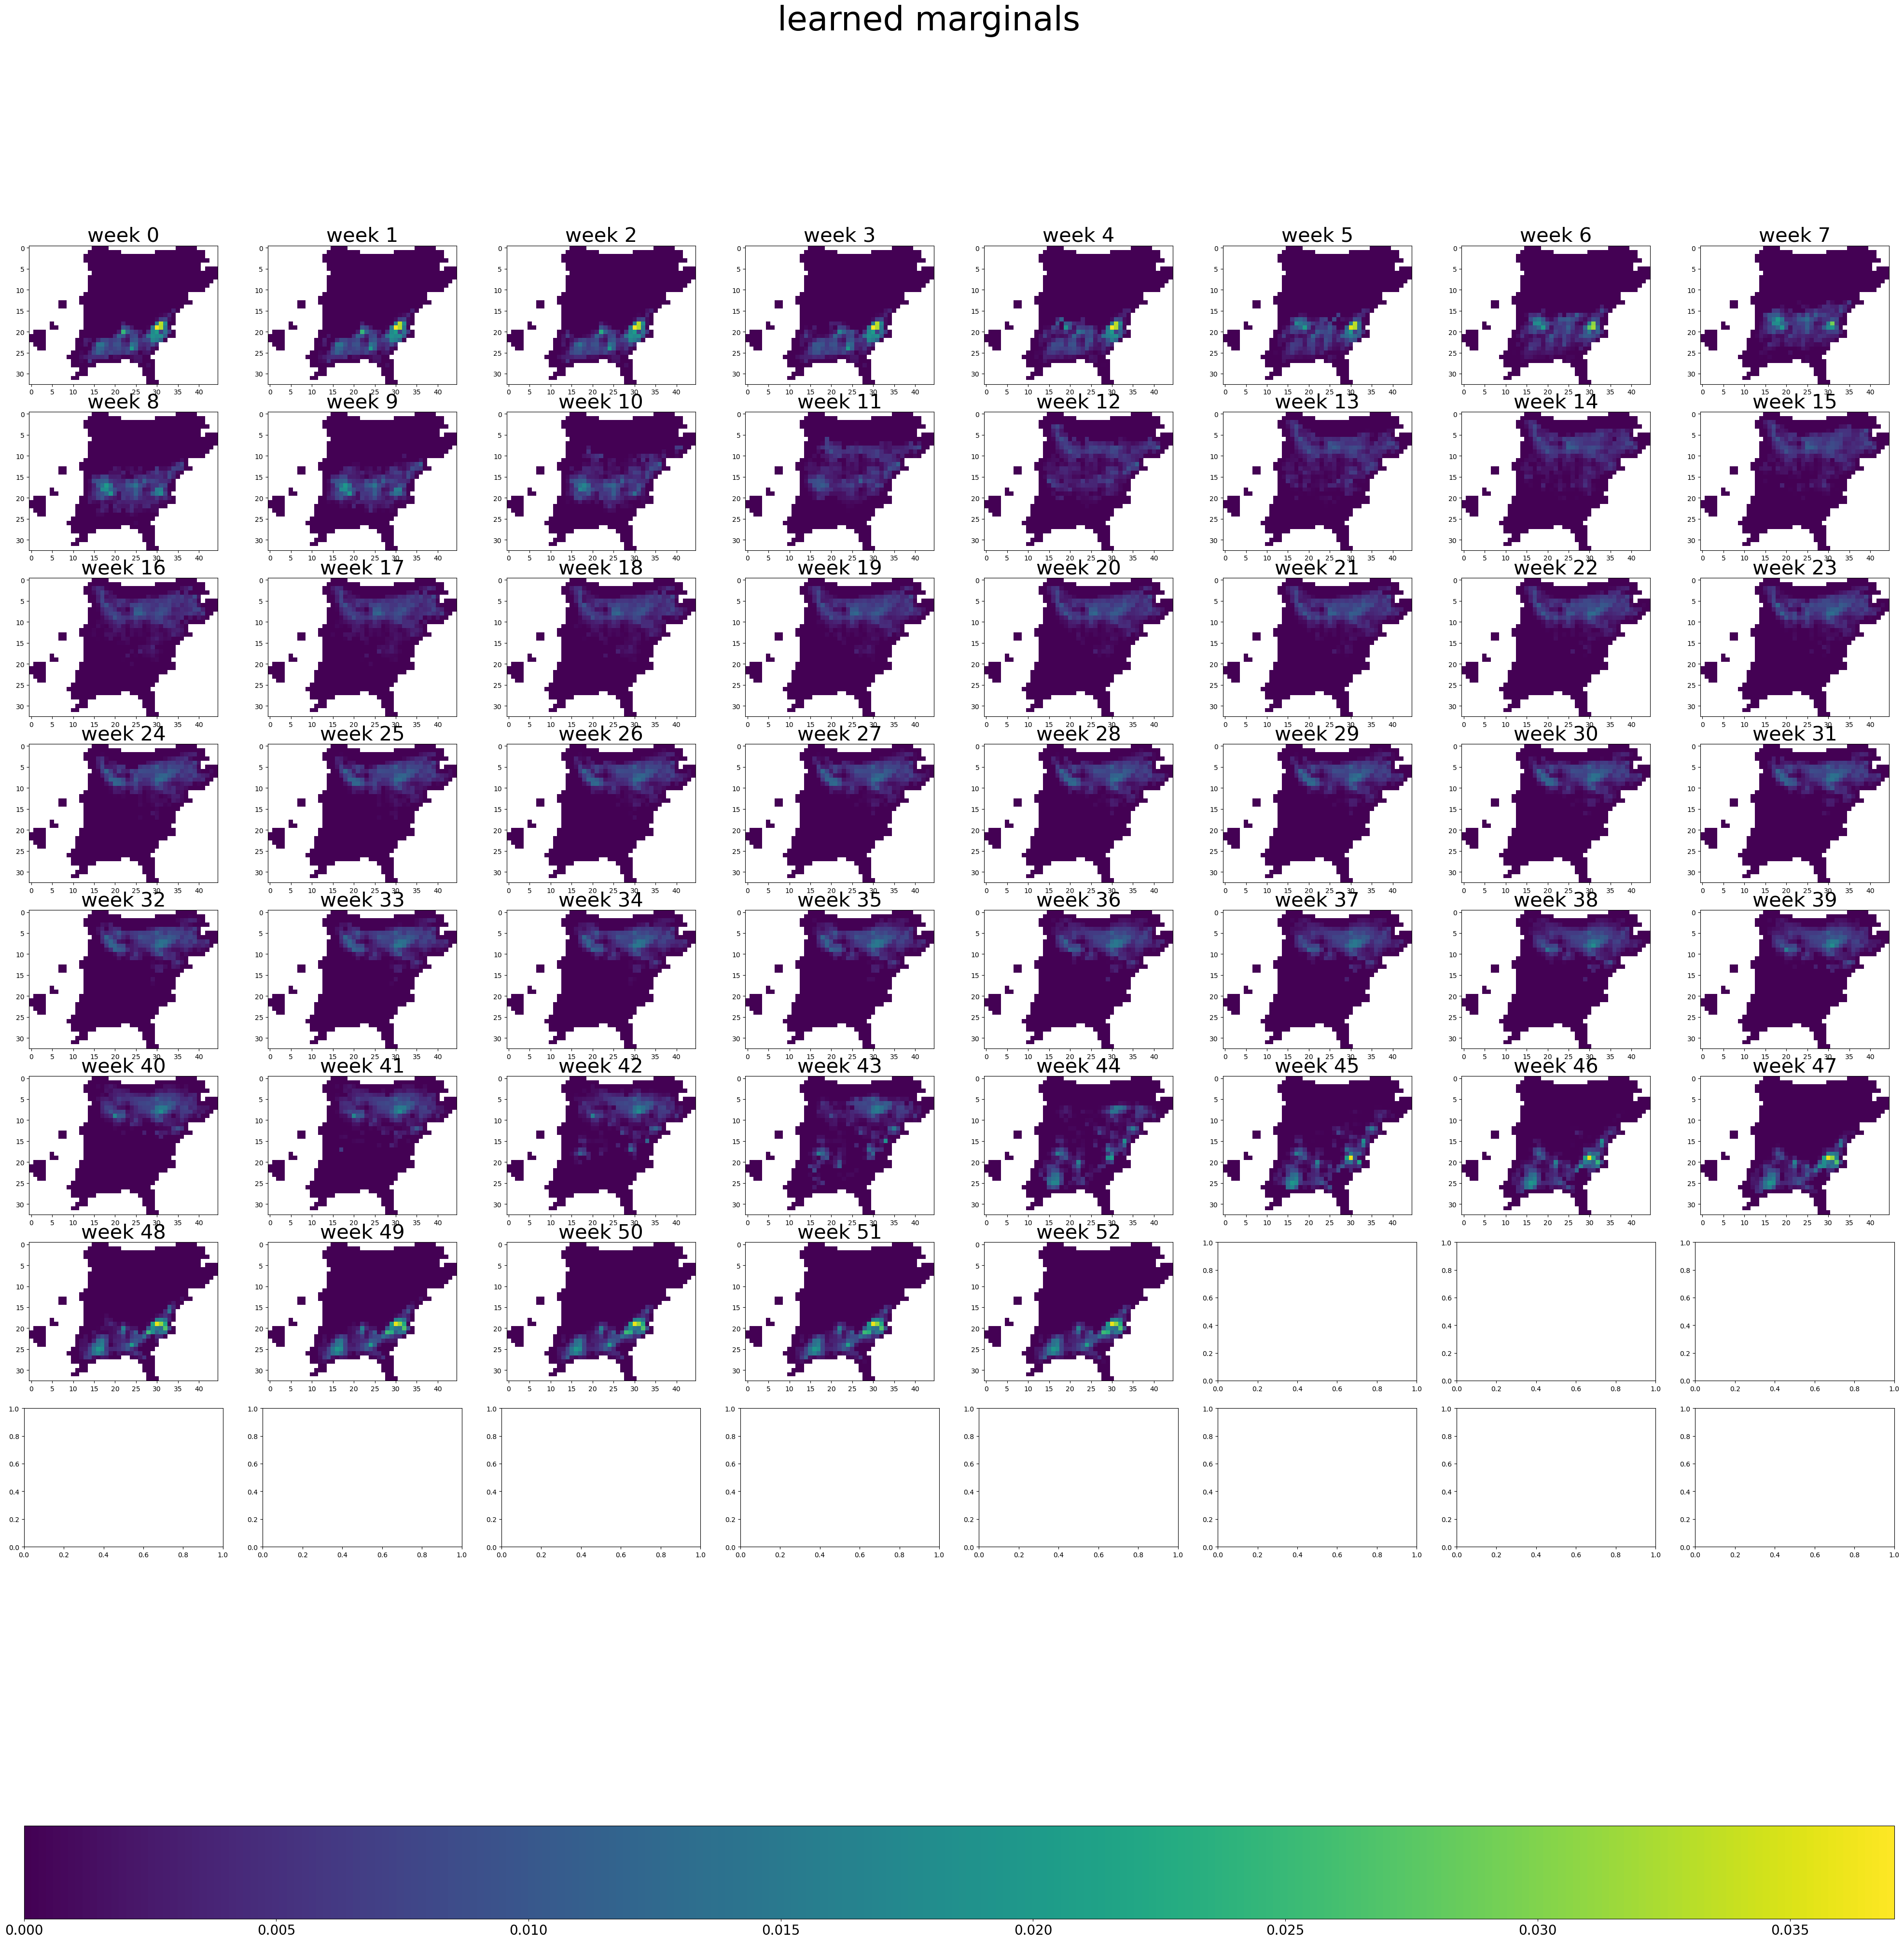

In [210]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with h5py.File(os.path.join(experiment_dir, 'ex48_w2_53w_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.hdf5'),
          'r+') as f:
    losses = f['metadata/loss_values']
    model_marginals = f['marginals']

    model_singletstep_marginals = []
    for i in range(52):
        pairwise = np.array(model_marginals[f'Week{i+1}_to_{i+2}'])
        if i == 0:
            model_singletstep_marginals.append(pairwise.sum(axis=1))
        model_singletstep_marginals.append(pairwise.sum(axis=0))


hdf_src = '/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/ebird-data-loading/amewoo_2021_100km.hdf5'

with h5py.File(hdf_src, 'r') as file:
    true_densities = np.asarray(file['distr']).T

    weeks = true_densities.shape[0]
    total_cells = true_densities.shape[1]

    dist_pow = 0.4
    distance_vector = np.asarray(file['distances'])**dist_pow
    distance_vector *= 1 / (100**dist_pow) # normalize the distance vector
    ncol, nrow, dynamic_masks, big_mask = get_plot_parameters(hdf_src)

    dtuple = Datatuple(weeks, ncol, nrow, total_cells, distance_vector, dynamic_masks, big_mask)
    distance_matrices, distance_matrices_for_week, masked_densities = mask_input(true_densities, dtuple)

def get_single_tstep_marginals(params):
    t_start = 1
    t_end = 53
    single_tstep_marginals = []
    d = jax.nn.softmax(params["Flow_Model/Initial_Params"]["z0"])
    single_tstep_marginals.append(d)
    for week in range(len(params) - 1):
        z = params[f'Flow_Model/Week_{week + 1}']['z']
        trans_prop = jax.nn.softmax(z, axis=1)  # softmax on rows
        flow = trans_prop * d.reshape(-1, 1) # convert d to a column and multiply each row in trans_prop by the corresponding scalar in d
        d = flow.sum(axis=0) # get the single timestep marginal
        single_tstep_marginals.append(d)
    return single_tstep_marginals

# plot marginals at each week
marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(8, 8, figsize=(50, 50))
ax_list = axes.flat
vmin = 0
vmax = max([marginal.max() for marginal in model_singletstep_marginals])
for week, marginal in enumerate(model_singletstep_marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    pos = ax_list[week].imshow(grid_learned, cmap="viridis", vmin=vmin, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=30)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("learned marginals", fontsize=50)
plt.show()

In [212]:
len(model_singletstep_marginals), len(masked_densities)

(53, 53)

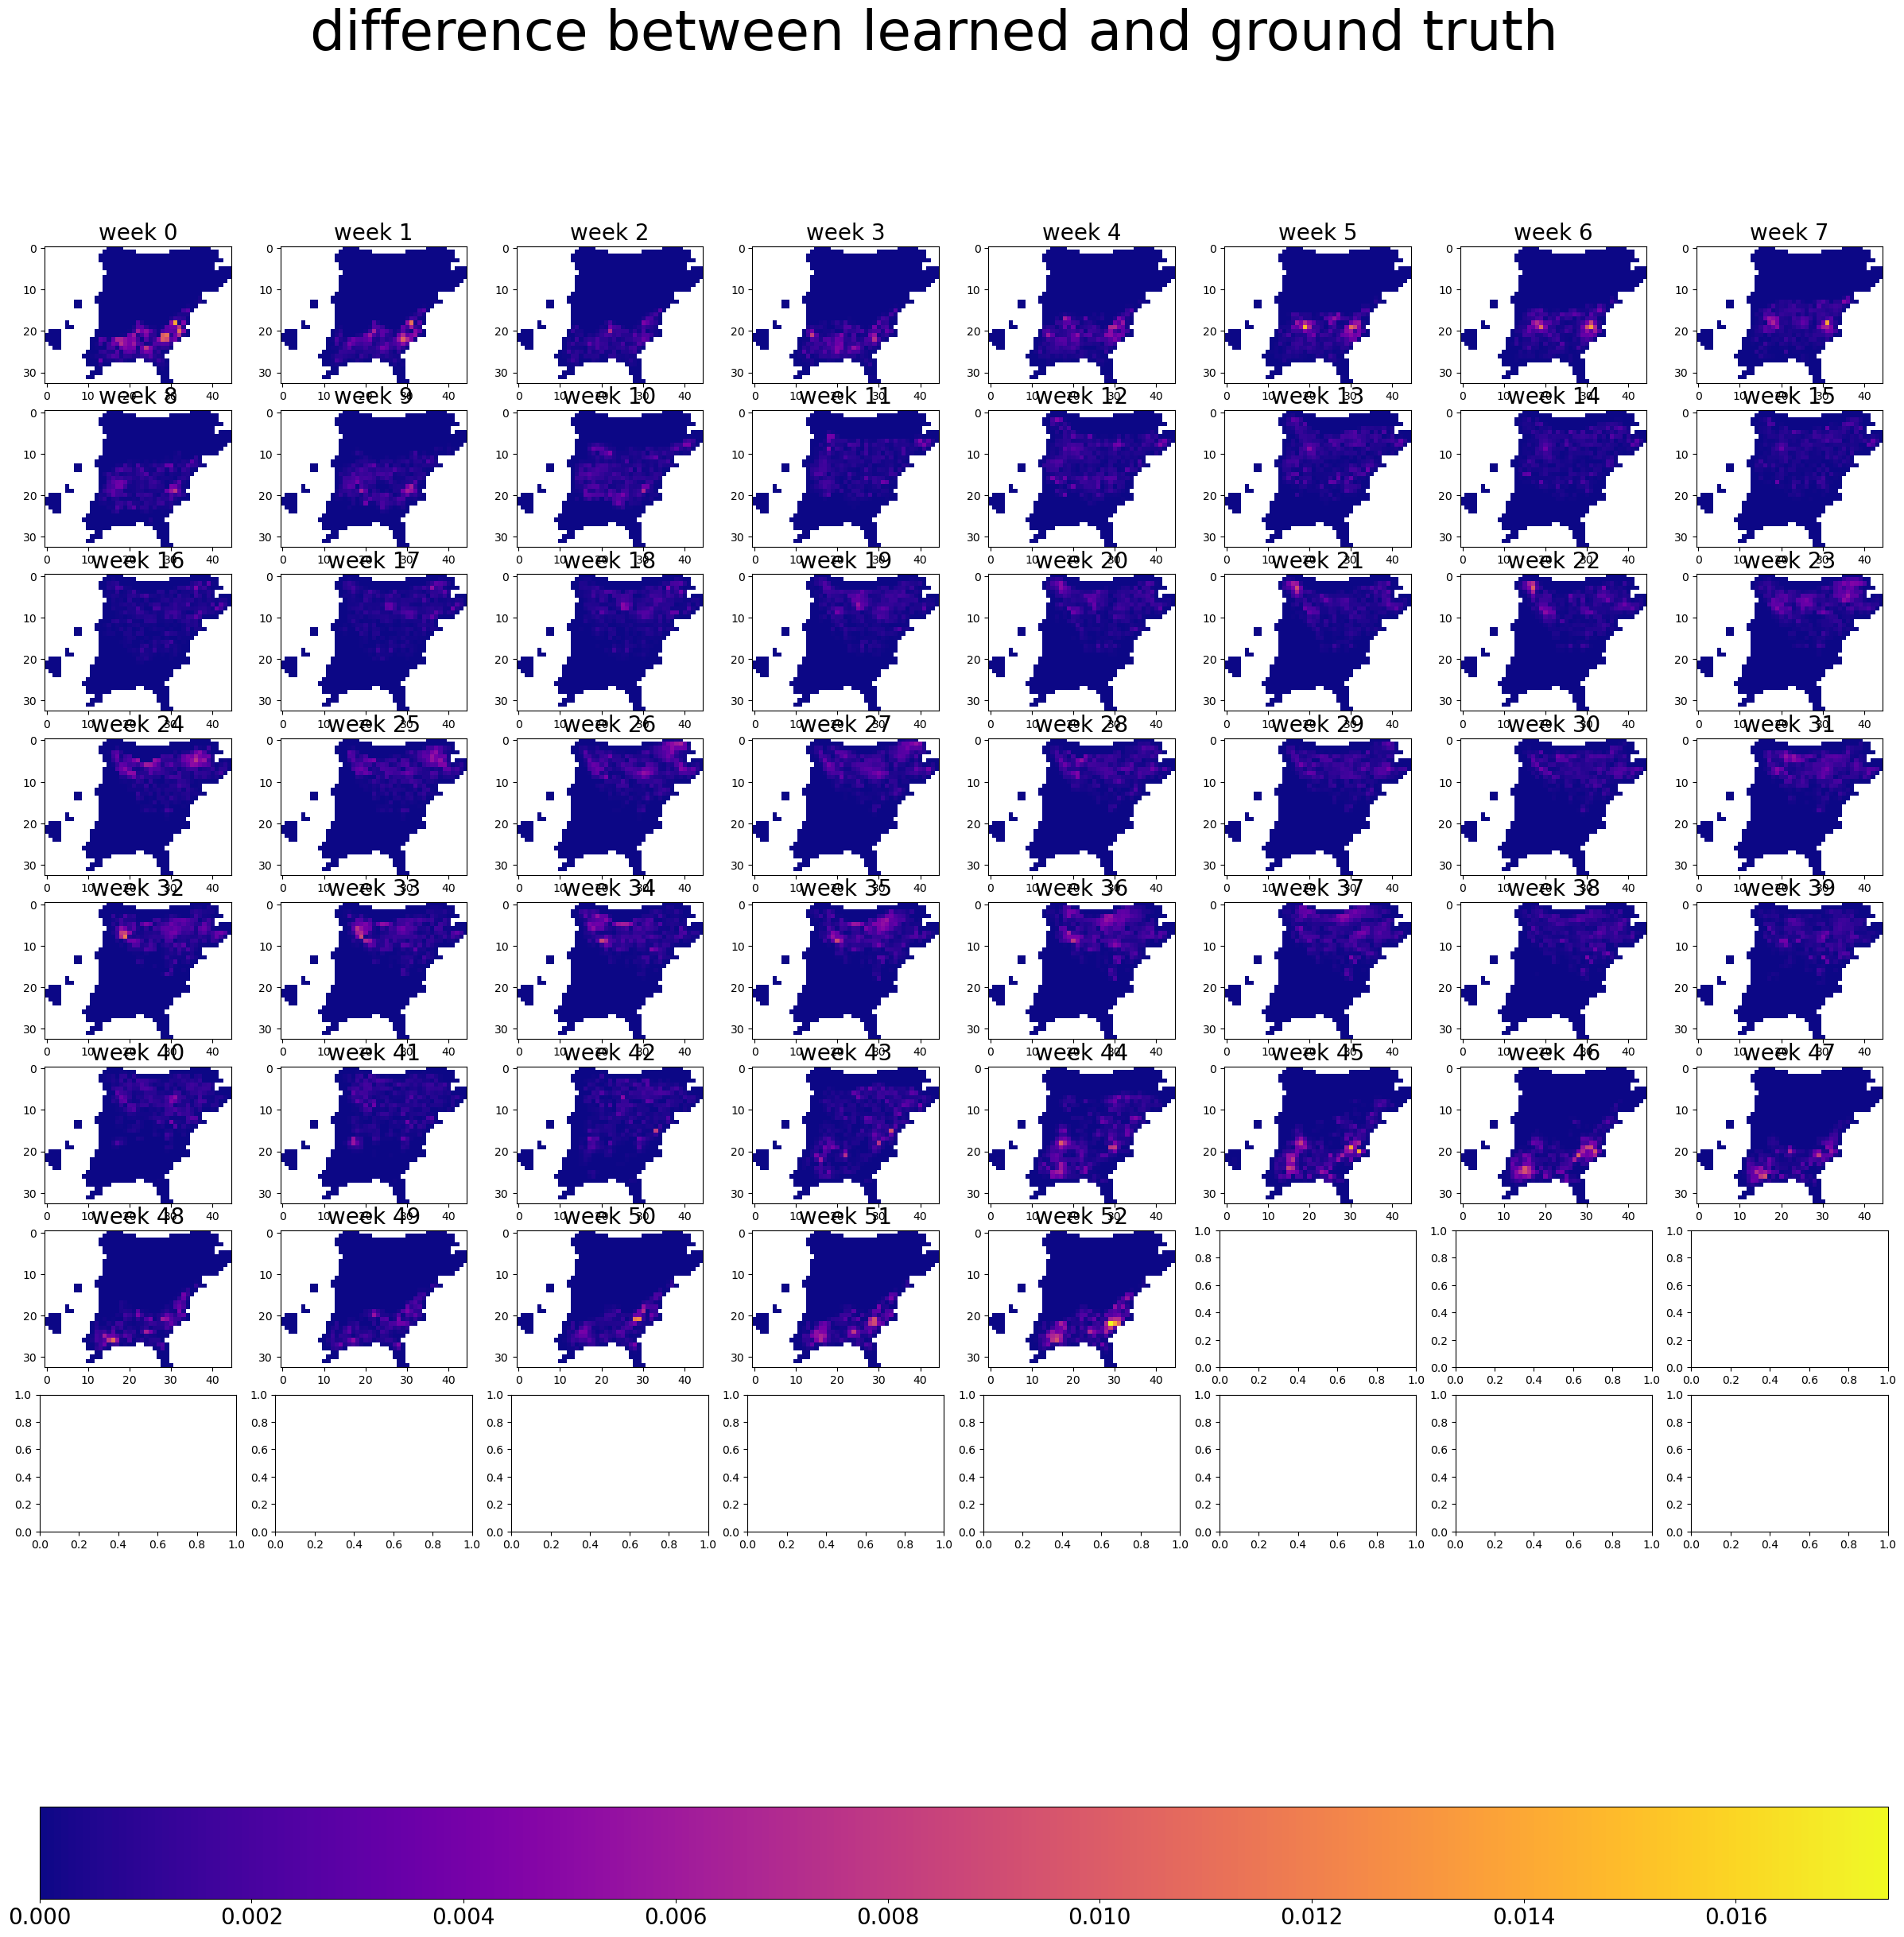

In [205]:
# plot difference between learned and ground truth for each week
# trimmed_masked_densities = masked_densities[:len(params)]
# marginals = get_single_tstep_marginals(params) # get marginals
fig, axes = plt.subplots(8, 8, figsize=(30, 30))
ax_list = axes.flat
vmin = 0
vmax = max([jnp.abs(marginal - ground_truth).max() for marginal, ground_truth in zip(model_singletstep_marginals, masked_densities)])
for week, marginal in enumerate(model_singletstep_marginals):
    grid_learned = make_grid(marginal, dynamic_masks[week], big_mask, ncol, nrow)
    grid_true = make_grid(masked_densities[week], dynamic_masks[week], big_mask, ncol, nrow)
    grid_diff = jnp.abs(grid_learned - grid_true)
    pos = ax_list[week].imshow(grid_diff, cmap="plasma", vmin=0, vmax=vmax)
    ax_list[week].set_title(f"week {week}", fontsize=20)

cbar = fig.colorbar(pos, ax=axes, orientation="horizontal")
cbar.ax.tick_params(labelsize=20)
fig.suptitle("difference between learned and ground truth", fontsize=50)

plt.show()

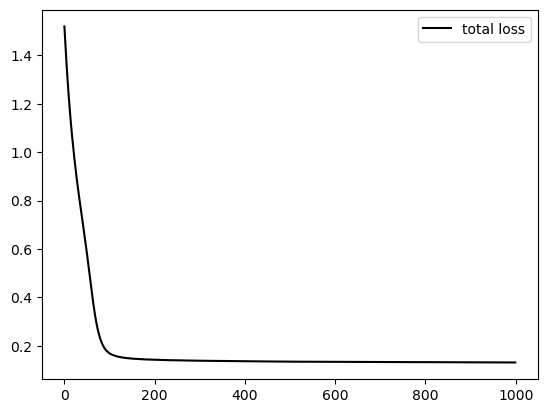

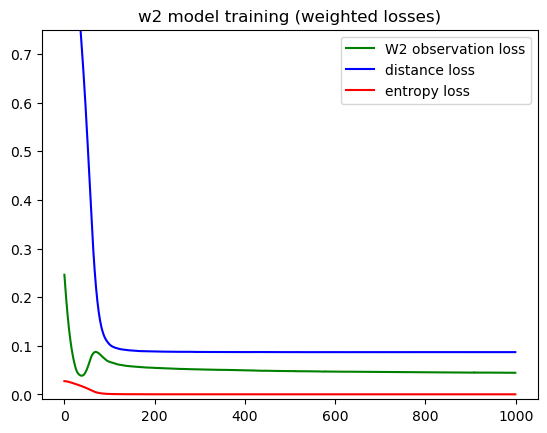

In [209]:
experiment_dir = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results"
with h5py.File(os.path.join(experiment_dir, 'ex48_w2_53w_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.hdf5'),
          'r+') as f:
    losses = f['metadata/loss_values']
    total_losses = np.array(losses['total'])
    obs_losses = np.array(losses['obs'])
    dist_losses = np.array(losses['dist'])
    ent_losses = np.array(losses['ent'])

# hyperparameter weights
dw = 1e-2
ew = 1e-4
ow = 1

plt.figure(0)
plt.plot(jnp.arange(1000), total_losses, 'black', label='total loss')
plt.legend()

plt.figure(1)
plt.plot(jnp.arange(1000), ow * obs_losses, 'green', label='W2 observation loss')
plt.plot(jnp.arange(1000), dw * dist_losses, 'blue', label='distance loss')
plt.plot(jnp.arange(1000), ew * ent_losses, 'red', label='entropy loss')
plt.title("w2 model training (weighted losses)")
plt.ylim(-0.01, 0.75)
plt.legend()

## Grid Search

In [215]:
experiment_file = "/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results/ex46_w2_losses_amewoo_2021_100km_obs1.0_ent0.0001_dist0.01_pow0.4.pkl"
with open(experiment_file, 'rb') as f:
    ex46_loss_dict = pickle.load(f)

l2_obs_values = jnp.array(ex46_loss_dict['l2_obs'])
w2_obs_values = jnp.array(ex46_loss_dict['w2_obs'])

alphas = l2_obs_values / w2_obs_values
alpha_mean, alpha_std = jnp.mean(alphas), jnp.std(alphas)
print(f"alpha: {alpha_mean}, std {alpha_std}")

# set alpha = 5e-3, the sample mean

alpha: 0.004978282377123833, std 0.0033541328739374876


## American Woodcock search results

81 point grid search
```
obs_weights = jnp.linspace(0.75, 1.25, num=3)
dist_weights = jnp.linspace(4e-2, 6e-2, num=3)
ent_weights = jnp.linspace(0.05, 0.015, num=3)
dist_pows = jnp.linspace(0.15, 0.25, num=3)
```

In [33]:
w2_df = pd.read_csv('/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results/amewoo-grid-search/w2/validation/w2_grid_search_avg_lls.csv')
l2_df = pd.read_csv('/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results/amewoo-grid-search/l2/validation/l2_grid_search_avg_lls.csv')
w2_df_smaller = w2_df.drop(['Unnamed: 0', 'learning_rate', 'normalized', 'rng_seed', 'training_steps', 'avg_null_ll', 'avg_null_ll_conf_lower', 'avg_null_ll_conf_upper', 'interval_ll_filepath'], axis=1)
l2_df_smaller = l2_df.drop(['Unnamed: 0', 'learning_rate', 'normalized', 'rng_seed', 'training_steps', 'avg_null_ll', 'avg_null_ll_conf_lower', 'avg_null_ll_conf_upper', 'interval_ll_filepath'], axis=1)
w2_df_smaller = w2_df_smaller.sort_values(by='avg_ll', ascending=False)
l2_df_smaller = l2_df_smaller.sort_values(by='avg_ll', ascending=False)

best_w2_params = w2_df_smaller[:5]
best_l2_params = l2_df_smaller[:5]

print(f"best w2 params \n {best_w2_params} \n")
print(f"best l2 params \n {best_l2_params}")


best w2 params 
     dist_pow  dist_weight  ent_weight  obs_weight    avg_ll  \
8       0.25         0.06       0.015        0.75 -3.180402   
35      0.25         0.06       0.015        1.00 -3.188802   
62      0.25         0.06       0.015        1.25 -3.200737   
34      0.20         0.06       0.015        1.00 -3.410328   
7       0.20         0.06       0.015        0.75 -3.412475   

    avg_ll_conf_lower  avg_ll_conf_upper  
8           -3.321816          -3.038988  
35          -3.331055          -3.046549  
62          -3.343834          -3.057640  
34          -3.547654          -3.273002  
7           -3.549033          -3.275917   

best l2 params 
     dist_pow  dist_weight  ent_weight  obs_weight    avg_ll  \
8       0.25         0.06       0.015        0.75 -3.215065   
34      0.25         0.06       0.015        1.00 -3.229791   
62      0.25         0.06       0.015        1.25 -3.242574   
7       0.20         0.06       0.015        0.75 -3.457677   
33      0.20

In [36]:
# get hyperparameter sensitivity metrics

# hyperparameter sensitivity
# over all pairs of hyperparameters - compute difference in log likelihood, take average
# returns average diff and confidence interval
def hyperparameter_sensitivity(results_df):
    size = len(results_df)
    diffs = []
    for i in range(size):
        for j in range(i+1, size):
            ll_i = results_df.iloc[i]['avg_ll']
            ll_j = results_df.iloc[j]['avg_ll']
            diffs.append(abs(ll_i - ll_j))
    diffs = np.array(diffs)
    confidence_level = 0.95
    ci = stats.t.interval(confidence_level, df=len(diffs)-1, loc=np.mean(diffs), scale=np.std(diffs, ddof=1) / np.sqrt(len(diffs)))
    return diffs.mean(), ci

l2_sensitivity = hyperparameter_sensitivity(l2_df)
w2_sensitivity = hyperparameter_sensitivity(w2_df)
print(f"l2 sensitivity: {l2_sensitivity} \n w2 sensitivity: {w2_sensitivity}")


l2 sensitivity: (np.float64(0.7043244297530243), (np.float64(0.6827570333510501), np.float64(0.7258918261549986))) 
 w2 sensitivity: (np.float64(0.7346146435146279), (np.float64(0.7120443068420655), np.float64(0.7571849801871903)))


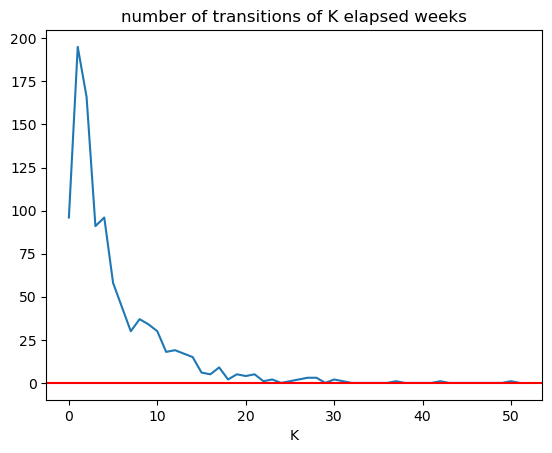

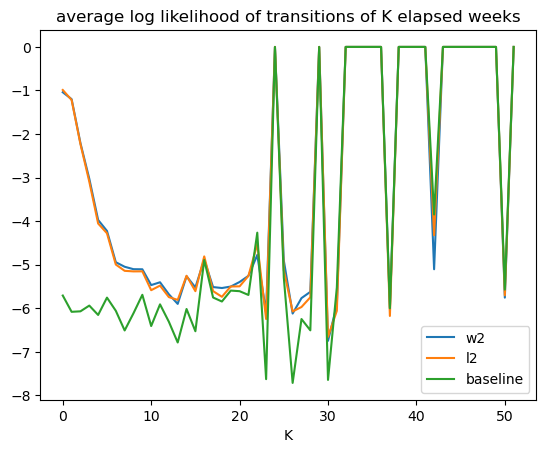

In [64]:
w2_df = w2_df.sort_values(by='avg_ll', ascending=False)
l2_df = l2_df.sort_values(by='avg_ll', ascending=False)

# print(w2_df.iloc[0]['interval_ll_filepath'])

# filenames for best-performing hyperparameters
w2_filename = w2_df.iloc[0]['interval_ll_filepath'].split('/')[-1]
l2_filename = l2_df.iloc[0]['interval_ll_filepath'].split('/')[-1]

w2_validation_dir = '/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results/amewoo-grid-search/w2/validation'
l2_validation_dir = '/Users/jacobepstein/Documents/work/birdflow/birdflow-bilevel/experiment-results/amewoo-grid-search/l2/validation'

w2_best_model_intervals_df = pd.read_csv(os.path.join(w2_validation_dir, w2_filename))
l2_best_model_intervals_df = pd.read_csv(os.path.join(l2_validation_dir, l2_filename))

w2_best_model_intervals_df['elapsed_weeks'] = (w2_best_model_intervals_df['elapsed_days'] / 7).apply(int)
l2_best_model_intervals_df['elapsed_weeks'] = (l2_best_model_intervals_df['elapsed_days'] / 7).apply(int)

counts_arr = [len(w2_best_model_intervals_df[w2_best_model_intervals_df['elapsed_weeks'] == i]) for i in range(52)]

plt.figure(0)
plt.plot(list(range(52)), counts_arr)
plt.axhline(y = 0, xmin=0, xmax=51, color='red')
plt.xlabel("K")
plt.title("number of transitions of K elapsed weeks")

plt.figure(1)
# filter df to just transitions of k elapsed weeks
# return mean Log likelihood
def get_avg_ll_of_transitions(df, k):
    df_k_elapsed = df[df['elapsed_weeks'] == k]
    if len(df_k_elapsed) == 0:
        return 0.0
    return np.array(df_k_elapsed['ll']).mean()

def get_avg_null_ll_of_transitions(df, k):
    df_k_elapsed = df[df['elapsed_weeks'] == k]
    if len(df_k_elapsed) == 0:
        return 0.0
    return np.array(df_k_elapsed['null_ll']).mean()

max_k = 52
plt.plot(list(range(max_k)), [get_avg_ll_of_transitions(w2_best_model_intervals_df, k) for k in range(max_k)],
         label="w2")
plt.plot(list(range(max_k)), [get_avg_ll_of_transitions(l2_best_model_intervals_df, k) for k in range(max_k)],
         label="l2")
plt.plot(list(range(max_k)), [get_avg_null_ll_of_transitions(w2_best_model_intervals_df, k) for k in range(max_k)],
         label="baseline")
plt.xlabel("K")
plt.title("average log likelihood of transitions of K elapsed weeks")
plt.legend()